In [1]:
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
#plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
plt.style.use('plot_style.txt')

In [ ]:
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator

In [ ]:
import itertools

In [ ]:
import re

In [ ]:
import utilities as u
import best

In [ ]:
import numpy as np

In [ ]:
import pandas

In [ ]:
import pathlib

In [10]:
import yaml

In [11]:
values_file = 'configurations/configILC.yaml'
with open(values_file, 'r') as stream:
            data = yaml.safe_load(stream)
values_file

'configurations/configILC.yaml'

In [12]:
plots_directory = data['plotsdirectory']

analysis_directory = data['analysisdirectory']

savingdirectory = data['savingdirectory']

Nsims = data['Nsims']

results_directory = data['resultsdirectory']
spectra_path = data['spectra_path']
sims_directory = data['sims_directory']
WR = u.write_read(sims_directory)

PP = pathlib.Path(analysis_directory)
Pplots = pathlib.Path(plots_directory)

fgnamefiles = data['fgnamefiles']

estimators_dictionary = data['estimators']
estimators = list(estimators_dictionary.keys())

#### List of estimators here

In [13]:
estimatorssub = data['estimatorssubset']
estimatorssub = ['shear', 'bh', 'pbh', 'symm']

In [14]:
if estimatorssub != '':
    estimators = estimatorssub

lista_lmaxes = []

names = {}

labeling = {}

for e in estimators:
    elemento = estimators_dictionary[e]
    names[e] = elemento['direc_name']
    labeling[e] = elemento['label']
    lmax_min, lmax_max = elemento['lmax_min'], elemento['lmax_max']
    num = elemento['number']
    lista_lmaxes += [np.linspace(lmax_min, lmax_max, num, dtype = int)]

lmaxes_configs = list(itertools.product(*lista_lmaxes))


#CHOOSE nu
nu = estimators_dictionary[estimators[0]]['nu']

lmin_sel, lmax_sel = data['lmin_sel'], data['lmax_sel']

optversion = data['optversion']

In [15]:
officialname = ''
for e in estimatorssub:
    officialname += f'{e}' 

In [16]:
inversevariance = True

invvardir = 'inversevariance/' if inversevariance else ''

In [17]:
outputofficial = pathlib.Path('officialplotspaper/')
output_plots = outputofficial/officialname/invvardir
try:
    pathlib.Path(output_plots).mkdir(parents = True, exist_ok = False)
except:
    print('Directory already exists')

Directory already exists


## OPTIMISATION SECTION

### OPTIMISATION RESULTS FOR SET A

#### Setting the reference case for HUOK 3500

In [18]:
lref_ = 3500
reference_directory = pathlib.Path('output_ILC_1503')/f'h{lref_}s{lref_}b{lref_}p{lref_}sy{lref_}sybh{lref_}/total/'

kk = np.load(reference_directory/'kk_total_ilc.npy')
theta = np.load(reference_directory/'theta_total_ilc.npy')
ells = np.load(reference_directory/'ells_total_ilc.npy')
selection = (ells > 30) & (ells < 1200)
biases = np.load(reference_directory/'totalbias_total_ilc.npy')
noises_high = np.load(reference_directory/'N_total_ilc.npy')
estimators_reference = ['h', 's', 'b', 'p', 'sy', 'sybh']
Optimizerkk_high = best.Opt(estimators_reference, lmin_sel, lmax_sel, ells, kk, theta, biases, noises_high)


filtbiases = Optimizerkk_high.filter_(abs(Optimizerkk_high.biases_selected), sigma = 1.5)
Optimizerkk_high_filt = best.Opt(estimators_reference, lmin_sel, lmax_sel, Optimizerkk_high.ells_selected, Optimizerkk_high.theory_selected, Optimizerkk_high.theta_selected, filtbiases, Optimizerkk_high.noises_selected)  

In [19]:
fnb_getter = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = invvar, analytical = True)

def get_est_weights(Opt, index):
    '''
    index = 0, 1, ....
    e.g. h, s, b -> index = 1 gives s
    '''
    Nest = len(Opt.estimators)
    nbins = Opt.nbins
    zeros = np.zeros(Nest*nbins)
    for j in range(nbins):
        zeros[index+Nest*j:index+(Nest*j+1)] = 1.
    return zeros

def get_dir_function(names):
    def get_dir_(*vals):
        stringa = ''
        for i, k in enumerate(names.keys()):
            num = vals[i]
            v = names[k]
            stringa += f'{v}{num}'
        return stringa
    return get_dir_


def get_info(directory, resultspath, fb = 1.0, invvardir = ''):
    kk = np.load(pathlib.Path(analysis_directory)/directory/'kk_ilc.npy')
    theta = np.load(pathlib.Path(analysis_directory)/directory/'theta_ilc.npy')
    ells = np.load(pathlib.Path(analysis_directory)/directory/'ells_ilc.npy')
    selection = (ells > 30) & (ells < 1200)
    biases = np.load(pathlib.Path(analysis_directory)/directory/'total/totalbias_total_ilc.npy')
    noises = np.load(pathlib.Path(analysis_directory)/directory/'total/N_total_ilc.npy')
    w = np.load(resultspath/directory/invvardir/f'w_auto_fb_{fb}.npy')
    x = np.load(resultspath/directory/invvardir/f'x_auto_fb_{fb}.npy')
    return kk, theta, ells, biases, noises, w, x


def make_table(resultsdir, all_lmaxes_directories, names, fb = 0., crosstag = None, optimtag = None, all_ref = None, autoname = 'Auto', include_estimators = True, include_dirs = True, include_ref = False, extradir = ''):
    data = {}
    if include_dirs:
        data['Name'] = all_lmaxes_directories
    superarray = np.zeros((3, 1+len(names), len(all_lmaxes_directories)))
    for i, direc in enumerate(all_lmaxes_directories):
        try:
            results_array = np.load(resultsdir/direc/extradir/f'alens_{fb}{crosstag}{optimtag}.npy')
            superarray[:, :, i] = results_array
        except:
            print(f'Skip {direc} for {fb}')
        
    data[f'Total {autoname}'] = superarray[0, 0]
    data[f'Noise {autoname}'] = superarray[1, 0]
    data[f'Bias {autoname}'] = superarray[2, 0]
    
    if include_ref:
        data[f'Noise {autoname} rtr'] = superarray[1, 0]/all_ref[1]
        data[f'Bias {autoname} rtr'] = superarray[2, 0]/all_ref[2]
        
    if include_estimators:
        for i, n in enumerate(names):
            #data[f'Total {n} rtr'] = superarray[0, i]/all_ref[0]
            data[f'Noise {n} rtr'] = superarray[1, i]/all_ref[1]
            data[f'Bias {n} rtr'] = superarray[2, i]/all_ref[2]
    
    return pandas.DataFrame(data)




In [20]:
x_estimator = get_est_weights(Optimizerkk_high, index = 0)
f, n, b = fnb_getter(Optimizerkk_high, 1., True)
f_ref, n_ref, b_ref = f(x_estimator), n(x_estimator), b(x_estimator)
all_ref = [f_ref, n_ref, b_ref]

In [21]:
all_ref

[0.0008459729944576088, 0.006859550712226799, 0.02826516510625752]

In [22]:
x_estimator = get_est_weights(Optimizerkk_high_filt, index = 0)
f, n, b = fnb_getter(Optimizerkk_high_filt, 1., True)
f_ref_filt, n_ref_filt, b_ref_filt = f(x_estimator), n(x_estimator), b(x_estimator)
all_ref_filt = [f_ref_filt, n_ref_filt, b_ref_filt]

In [23]:
all_ref_filt

[0.006031702179245355, 0.006859550712226799, 0.07736051152410862]

In [24]:
#NOTE!
f_ref, n_ref, b_ref = f_ref_filt, n_ref_filt, b_ref_filt
all_ref_filt = all_ref

In [25]:
get_dir = get_dir_function(names)

In [26]:
names

{'shear': 's', 'bh': 'b', 'pbh': 'p', 'symm': 'sy'}

In [27]:
fbs = data['optimisation']['fbs']
fbs = np.sort(fbs, ).astype(float)
data['optimisation']['fbs']

[0.1, 1.0, 4.0]

In [28]:
fbs = np.array([0, 0.1, 1.0, 4.0, 9.0, 16.0])
fbs

array([ 0. ,  0.1,  1. ,  4. ,  9. , 16. ])

In [29]:
import matplotlib.cm as cm
colors_plotting = cm.rainbow(np.linspace(0, 1, len(fbs)))

#### Looking for the best configuration

In [30]:
invvariance = inversevariance
if invvariance:
    inv_variance_dir = 'inversevariance'
else:
    inv_variance_dir = ''

In [31]:
nocross = False
crosstag = '_nocross' if nocross else ''

optim = True
optimtag = '_ofoptim' if optim else ''

if (nocross and optim):
    precisetitle = 'no cross, with filt abs'
elif (nocross and not optim):
    precisetitle = 'no cross'
elif (not nocross and optim):
    precisetitle = 'with cross, with filt abs'
elif (not nocross and not optim):
    precisetitle = 'with cross'

In [32]:
dd = {}
dd['Name'] = 'HUOK3500'
dd['Total Auto'] = all_ref[0]
dd['Noise Auto'] = all_ref[1]
dd['Bias Auto'] = all_ref[2]

In [33]:
resultspath = pathlib.Path(results_directory)

In [34]:
path = pathlib.Path(results_directory)
l = 3500
lista = [l for e in estimators]
all_lmaxes_directories=  [x.name for x in path.iterdir() if x.is_dir() and len(x.name)==len(get_dir(*lista))]

0.0 [0.0004339997366563499, 0.9123536876729377, 3.914706565755277e-14, 0.08721231259036678]
0.1 [0.0015214650540636369, 0.3536809288176467, 0.6447976061277993, 4.904447180074296e-13]
1.0 [0.06257624164866309, 0.07521602015833449, 0.8622077381929538, 4.859546072327897e-14]
4.0 [0.03526179899138593, 0.09814667585646297, 0.8593603272639372, 0.00723119788821452]
[-0.00000000e+00  1.66383419e-06  1.55742063e-05  8.43132245e-06
  5.18215238e-06  2.52624670e-06 -0.00000000e+00 -0.00000000e+00]
9.0 [0.14762296426350893, 4.914592019140539e-16, 0.8523770357364905, 7.781179987051898e-18]
16.0 [0.13057466135464912, 1.0371981626606043e-16, 0.8694253386453501, 4.422013689095913e-18]


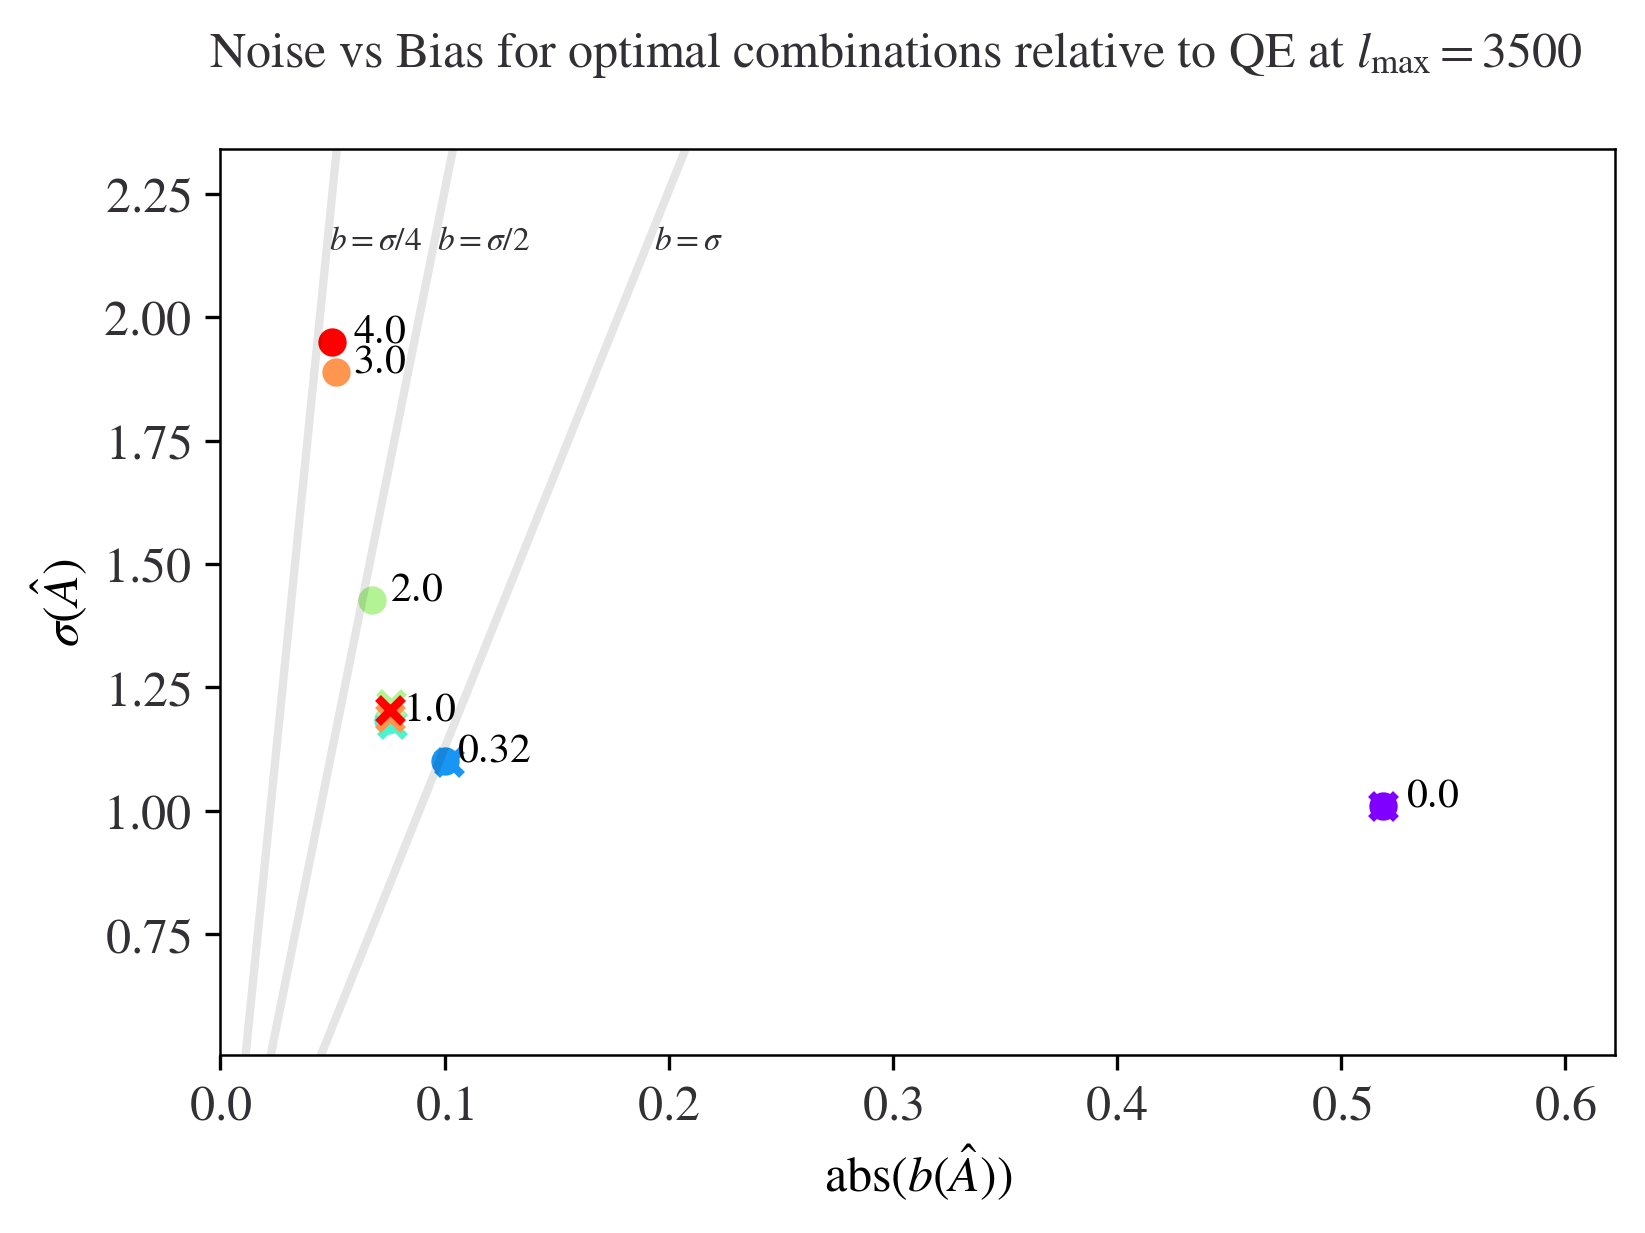

In [37]:
ns = np.array([])
bs = np.array([])
fs = np.array([])

ns_no_filt = np.array([])
bs_no_filt = np.array([])
fs_no_filt = np.array([])

all_best_direcs = []
all_best_direcs_no_inv_variance = []

names_W = list(names)+['$W_L$']
names_W

partial_results = {}

for ii, fb in enumerate(fbs):
    d = make_table(resultspath, all_lmaxes_directories, estimators, fb = fb, crosstag = crosstag, optimtag = optimtag, include_estimators = False, extradir = inv_variance_dir)
    
    d_no_inv_variance = make_table(resultspath, all_lmaxes_directories, estimators, fb = fb, crosstag = crosstag, optimtag = optimtag, include_estimators = False, extradir = '')
    
    dref = make_table(resultspath, all_lmaxes_directories, estimators, fb = fb, crosstag = crosstag, optimtag = optimtag, all_ref = all_ref,
                      include_estimators = False, extradir = inv_variance_dir, include_ref = True)

    Ntop = 5
    
    top5 = list(d.sort_values(by = 'Total Auto').head(Ntop).iloc[:Ntop, 0])
    
    direc = d.sort_values(by = 'Total Auto').head(1).iloc[0, 0]
    
    direc_no_inv_variance = d_no_inv_variance.sort_values(by = 'Total Auto').head(1).iloc[0, 0]

    lmax_directory = direc
    
    all_best_direcs += [direc]
    
    all_best_direcs_no_inv_variance += [direc_no_inv_variance]
    
    kk, theta, ells, biases, noises, w, x = get_info(pathlib.Path(direc), resultspath, fb = fb, invvardir = inv_variance_dir)
    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, (biases), noises, nocrosses = nocross)
    
    if optim:
        filtbiases = Optimizerkk.filter_(abs(Optimizerkk.biases_selected), sigma = 1.5)
        Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, Optimizerkk.ells_selected, Optimizerkk.theory_selected, Optimizerkk.theta_selected, filtbiases, Optimizerkk.noises_selected)              
                  
                  
    resultkk = best.Res()
    f, n, b = fnb_getter(Optimizerkk, fb_val = fb, invvar = invvariance)
    resultkk.load_all(resultspath/lmax_directory/inv_variance_dir, f'auto_fb_{fb}{crosstag}')
    
    fnb_getter_no_analytical = lambda Opt, fb_val, invvar: Opt.get_f_n_b(Opt.ells_selected, Opt.theory_selected, Opt.theta_selected, Opt.biases_selected,
                              sum_biases_squared = False, bias_squared = False, fb = fb_val, inv_variance = invvar, analytical = False)
    
    temp_lista = []
    for i_e, e in enumerate(estimators):
        resultkk.load_all(resultspath/direc_no_inv_variance, f'auto_fb_{fb}{crosstag}')
        x_estimator = get_est_weights(Optimizerkk, index = i_e)*resultkk.x #note I am using analytical result for resultkk.x
        x_estimator = np.append(x_estimator, resultkk.ws[:, -1])# if not invvariance else x_estimator
        ff, nn, bb = fnb_getter_no_analytical(Optimizerkk, fb, False)#NOTE, even if I have invvariance = True, I am appending w in x_estimator, so it should be ok!
        #temp_lista += [ff(x_estimator)]
        
        temp_lista += [Optimizerkk.integerate_discrete(resultkk.ws[:, i_e]*resultkk.ws[:, -1], Optimizerkk.ells_selected)]
    
    print(fb, temp_lista)
    if fb == 4:
        print(resultkk.ws[:, -1])
    
    results_array = np.load(resultspath/direc/inv_variance_dir/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
    ftemp, ntemp, btemp = results_array
    
    
    partial_results[fb] = np.array(temp_lista)
    
    ns = np.append(ns, ntemp)
    bs = np.append(bs, btemp)
    fs = np.append(fs, ftemp)
    
    
    
    #NOTE, HERE I PUT ORIGINAL RESULTS
    results_array = np.load(resultspath/direc_no_inv_variance/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
    ftemp, ntemp, btemp = results_array
    
    ns_no_filt = np.append(ns_no_filt, ntemp)
    bs_no_filt = np.append(bs_no_filt, btemp)
    fs_no_filt = np.append(fs_no_filt, ftemp)
    
    smallns = []
    smallbs = []
    for temp_lmax_directory in top5:
        results_array = np.load(resultspath/temp_lmax_directory/inv_variance_dir/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
        ftemp, ntemp, btemp = results_array
        
        smallns += [ntemp]
        smallbs += [btemp]
        
    smallbs = np.array(smallbs)
    smallns = np.array(smallns)

    
fig, ax = plt.subplots()
fig.suptitle(f'Case of {precisetitle}')
fig.suptitle('Noise vs Bias for optimal combinations relative to QE at $l_{\mathrm{max}}=3500$')
ax.set_ylabel('$\\sigma(\hat{A})$')
ax.set_xlabel('$\mathrm{abs}(b(\hat{A}))$')

alpha = 0.1

cases = [1, 2, 4]
for c in cases:
    
    xmax = max(max(bs/b_ref_filt)*(1+0.2), max(bs_no_filt/b_ref)*(1+0.2))
    
    xx = np.linspace(0, xmax, 500)/b_ref_filt
    yy = c*np.linspace(0, xmax, 500)/n_ref_filt
    rad = np.arctan(c)
    angledeg = np.rad2deg(rad)
    
    
    
    text = '' if c == 1 else f'/{c}'
    
    ymin = min(min(ns/n_ref_filt)*(1-0.5), min(ns_no_filt/n_ref)*(1-0.5))
    ymax = max(max(ns/n_ref_filt)*(1+0.2), max(ns_no_filt/n_ref)*(1+0.2))
    
    bbA = max(yy[ (yy>=ymin) & (yy<=ymax)])
    #bbB = max(yy[ (xx<=xmax)])
    bb = bbA
    aa = xx[np.where(bb==yy)]

    ax.text(aa, bb,  '$b=\sigma$'+f'${{{text}}}$', ha="left", va="top", size = 8)
    ax.plot(xx, yy, lw = 2, color = 'black', alpha = alpha)
    
    
    
    xx = np.linspace(0, xmax, 500)/b_ref
    yy = c*1/n_ref*np.linspace(0, xmax, 500)
    rad = np.arctan(c)
    angledeg = np.rad2deg(rad)
    text = '' if c == 1 else f'/{c}'
    ymax = max(max(ns/n_ref_filt)*(1+0.2), max(ns_no_filt/n_ref)*(1+0.2))
    bbA = max(yy[ (yy>=ymin) & (yy<=ymax)])
    bb = bbA
    aa = xx[bb==yy]
    #ax.text(aa, bb,  '$b=\sigma$'+f'${{{text}}}$', ha="left", va="top", size = 8, alpha = alpha)
    #ax.plot(xx, yy, lw = 2, color = 'black', alpha = alpha/2, ls = '--')



for i, c in enumerate(zip(abs(bs)/b_ref_filt, ns/n_ref)):
    b, n = c
    ax.scatter(b, n, color = colors_plotting[i], marker = 'x')#, label = all_best_direcs[i])
    
    b, n = (abs(bs_no_filt)/b_ref)[i], (ns_no_filt/n_ref)[i]
    ax.scatter(b, n, color = colors_plotting[i])
    
    fbname = np.round(np.sqrt(fbs[i]), 2)
    text = f'{fbname}, b = {round(b, 4)}, n = {round(n, 4)}, brthuok3500 = {round(b/b_ref_filt, 4)}, nrthuok3500 = {round(n/n_ref, 4)}'
    text = f'${fbname}$'
    alpha = 0.2*i/len(fbs)+0.02
    ax.annotate(text, (b*(1+alpha), n), color = 'black')
    

#ax.legend()
ymax = max(max(ns/n_ref_filt)*(1+0.2), max(ns_no_filt/n_ref)*(1+0.2))
ymin = min(min(ns/n_ref_filt)*(1-0.5), min(ns_no_filt/n_ref)*(1-0.5))
ax.set_ylim(ymin, ymax)


xmax = max(max(bs/b_ref_filt)*(1+0.2), max(bs_no_filt/b_ref)*(1+0.2))
ax.set_xlim(0, xmax = xmax)

fig.savefig(output_plots/'optimalcombstrend.png')
plt.show()  


In [38]:
fs_no_filt

array([4.79509518e-05, 6.30307763e-05, 9.94755882e-05, 2.05243445e-04,
       3.09903498e-04, 4.17165167e-04])

In [39]:
fs_no_filt/fs

array([1.        , 0.99825006, 0.99208852, 0.98885076, 0.82817595,
       0.68048869])

In [40]:
# first define the ratios
r1 = 0.2       # 20%
r2 = r1 + 0.4  # 40%

# define some sizes of the scatter marker
sizes = np.array([120])

# calculate the points of the first pie marker
#
# these are just the origin (0,0) +
# some points on a circle cos,sin

ratios_ = [0.19, 0.4, 0.4]

def scatter(ax, xx, yy, x0, y0, ratios, colors, size, text = '', labels = [], alpha = 0):
    
        
    rtemp = 0
    rprec = 0
    xyall = {}
    sall = {}
    flag = False
    for i, r in enumerate(ratios):
        if len(labels) == 0 or flag:
            flag = True
            labels += [None]
        rtemp += r 
        x = [x0] + np.cos(np.linspace(2 * np.pi * rprec, 2 * np.pi * rtemp, 100)).tolist()
        y = [y0] + np.sin(np.linspace(2 * np.pi * rprec, 2 * np.pi * rtemp, 100)).tolist()
        xy = np.column_stack([x, y])
        xyall[i] = xy
        s = np.abs(xy).max()
        sall[i] = s
        
        rprec = rtemp
        
        if text != '':
            ax.annotate(text, (xx*(1+alpha), yy), color = 'black')
        
        ax.scatter(xx, yy, marker = xy,
               s = s ** 2 * np.array([size]), facecolor = colors[i], label = labels[i])

        

#fig, ax = plt.subplots()
#scatter(ax, 0, 0, 0, 0, ratios_, ['blue', 'green', 'red', 'orange'], 120)
#plt.show()

In [41]:
colors = ['red', 'green', 'purple', 'yellow']

In [42]:
labeling

{'shear': 'Shear', 'bh': 'BH', 'pbh': 'PBH', 'symm': 'Symm'}

In [43]:
import matplotlib.patches as mpatches

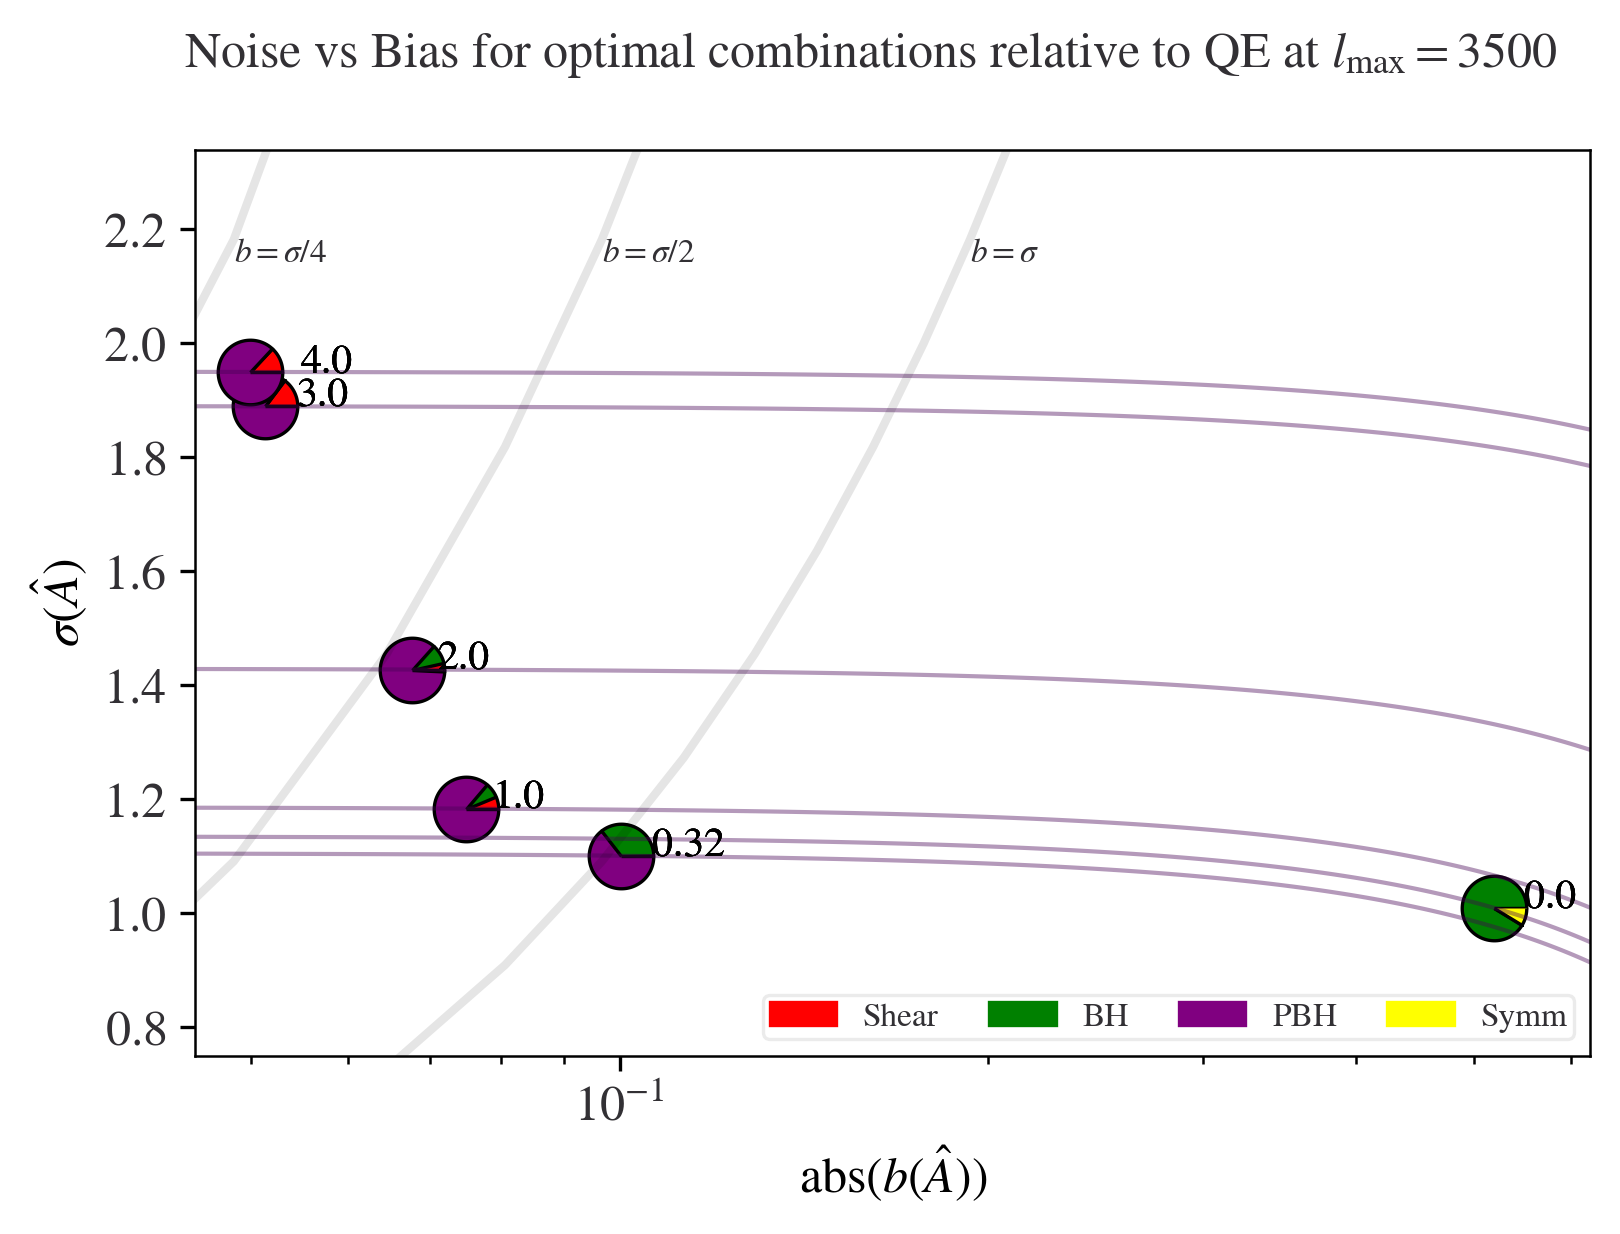

In [107]:
fig, ax = plt.subplots()

cases = [1, 2, 4]

alpha = 0.1

for c in cases:
    
    xmax = max(max(bs/b_ref_filt)*(1+0.2), max(bs_no_filt/b_ref)*(1+0.2))
    
    xx = np.linspace(0, xmax, 500)/b_ref_filt
    yy = c*np.linspace(0, xmax, 500)/n_ref_filt
    rad = np.arctan(c)
    angledeg = np.rad2deg(rad)
    
    
    
    text = '' if c == 1 else f'/{c}'
    
    ymin = min(min(ns/n_ref_filt)*(1-0.5), min(ns_no_filt/n_ref)*(1-0.5))
    ymax = max(max(ns/n_ref_filt)*(1+0.2), max(ns_no_filt/n_ref)*(1+0.2))
    
    bbA = max(yy[ (yy>=ymin) & (yy<=ymax)])
    #bbB = max(yy[ (xx<=xmax)])
    bb = bbA
    aa = xx[np.where(bb==yy)]

    ax.text(aa, bb,  '$b=\sigma$'+f'${{{text}}}$', ha="left", va="top", size = 8)
    ax.plot(xx, yy, lw = 2, color = 'black', alpha = alpha)
    
    
    
    xx = np.linspace(0, xmax, 500)/b_ref
    yy = c*1/n_ref*np.linspace(0, xmax, 500)
    rad = np.arctan(c)
    angledeg = np.rad2deg(rad)
    text = '' if c == 1 else f'/{c}'
    ymax = max(max(ns/n_ref_filt)*(1+0.2), max(ns_no_filt/n_ref)*(1+0.2))
    bbA = max(yy[ (yy>=ymin) & (yy<=ymax)])
    bb = bbA
    aa = xx[bb==yy]
    #ax.text(aa, bb,  '$b=\sigma$'+f'${{{text}}}$', ha="left", va="top", size = 8, alpha = alpha)
    #ax.plot(xx, yy, lw = 2, color = 'black', alpha = alpha/2, ls = '--')



for i, fb in enumerate(fbs):
    
    b = bs_no_filt[i]/b_ref_filt
    n = ns_no_filt[i]/n_ref_filt
    fff = np.sqrt(b**2+n**2)
    x = np.linspace(1e-11, 4.0, 4000)
    y = np.linspace(1e-11, 4.0, 4000)
    X, Y = np.meshgrid(x,y)
    F = X**2 + Y**2 - fff**2.
    plt.contour(X, Y, F, [0], linewidths= 1, alpha = 0.4)
    
    alpha = 0.3/(len(fbs)-i)/(i+1)*2 if i!= 0 else 0.35/(len(fbs)-i)
    scatter(ax, bs_no_filt[i]/b_ref_filt, ns_no_filt[i]/n_ref_filt, 0, 0, partial_results[fb], colors, 240, np.round(np.sqrt(fb), 2), [], alpha)
    
frefff = np.sqrt(b_ref_filt**2+n_ref**2.)
x = np.linspace(1e-11, 1.0, 1000)
y = np.linspace(1e-11, 1.0, 1000)
X, Y = np.meshgrid(x,y)
F = X**2 + Y**2 - frefff**2.
plt.contour(X,Y,F,[0], linewidths= 1, alpha = 0.4)

patches = []
for i, k in enumerate(labeling.keys()):
    patches += [mpatches.Patch(color = colors[i], label = labeling[k])]
    

#ax.legend()
ymax = max(max(ns/n_ref_filt)*(1+0.2), max(ns_no_filt/n_ref)*(1+0.2))
ymin = min(min(ns/n_ref_filt)*(1-0.5), min(ns_no_filt/n_ref)*(1-0.5))
ax.set_ylim(0.75, ymax)


xmax = max(max(bs/b_ref_filt)*(1+0.2), max(bs_no_filt/b_ref)*(1+0.2))
ax.set_xlim(4.5e-2, xmax = xmax)



ax.legend(handles = patches, ncol = len(labeling.keys()), prop = {'size': 8})
fig.suptitle('Noise vs Bias for optimal combinations relative to QE at $l_{\mathrm{max}}=3500$')

ax.set_ylabel('$\\sigma(\hat{A})$')
ax.set_xlabel('$\mathrm{abs}(b(\hat{A}))$')
ax.set_xscale('log')
fig.savefig(output_plots/'piechart_fbs.png')
plt.show()
    


In [52]:
def arc_patch(center, radius, theta1, theta2, ax=None, resolution=50, **kwargs):
    # make sure ax is not empty
    if ax is None:
        ax = plt.gca()
    # generate the points
    theta = np.linspace(np.radians(theta1), np.radians(theta2), resolution)
    points = np.vstack((radius*np.cos(theta) + center[0], 
                        radius*np.sin(theta) + center[1]))
    # build the polygon and add it to the axes
    poly = mpatches.Polygon(points.T, closed=True, **kwargs)
    ax.add_patch(poly)
    return poly

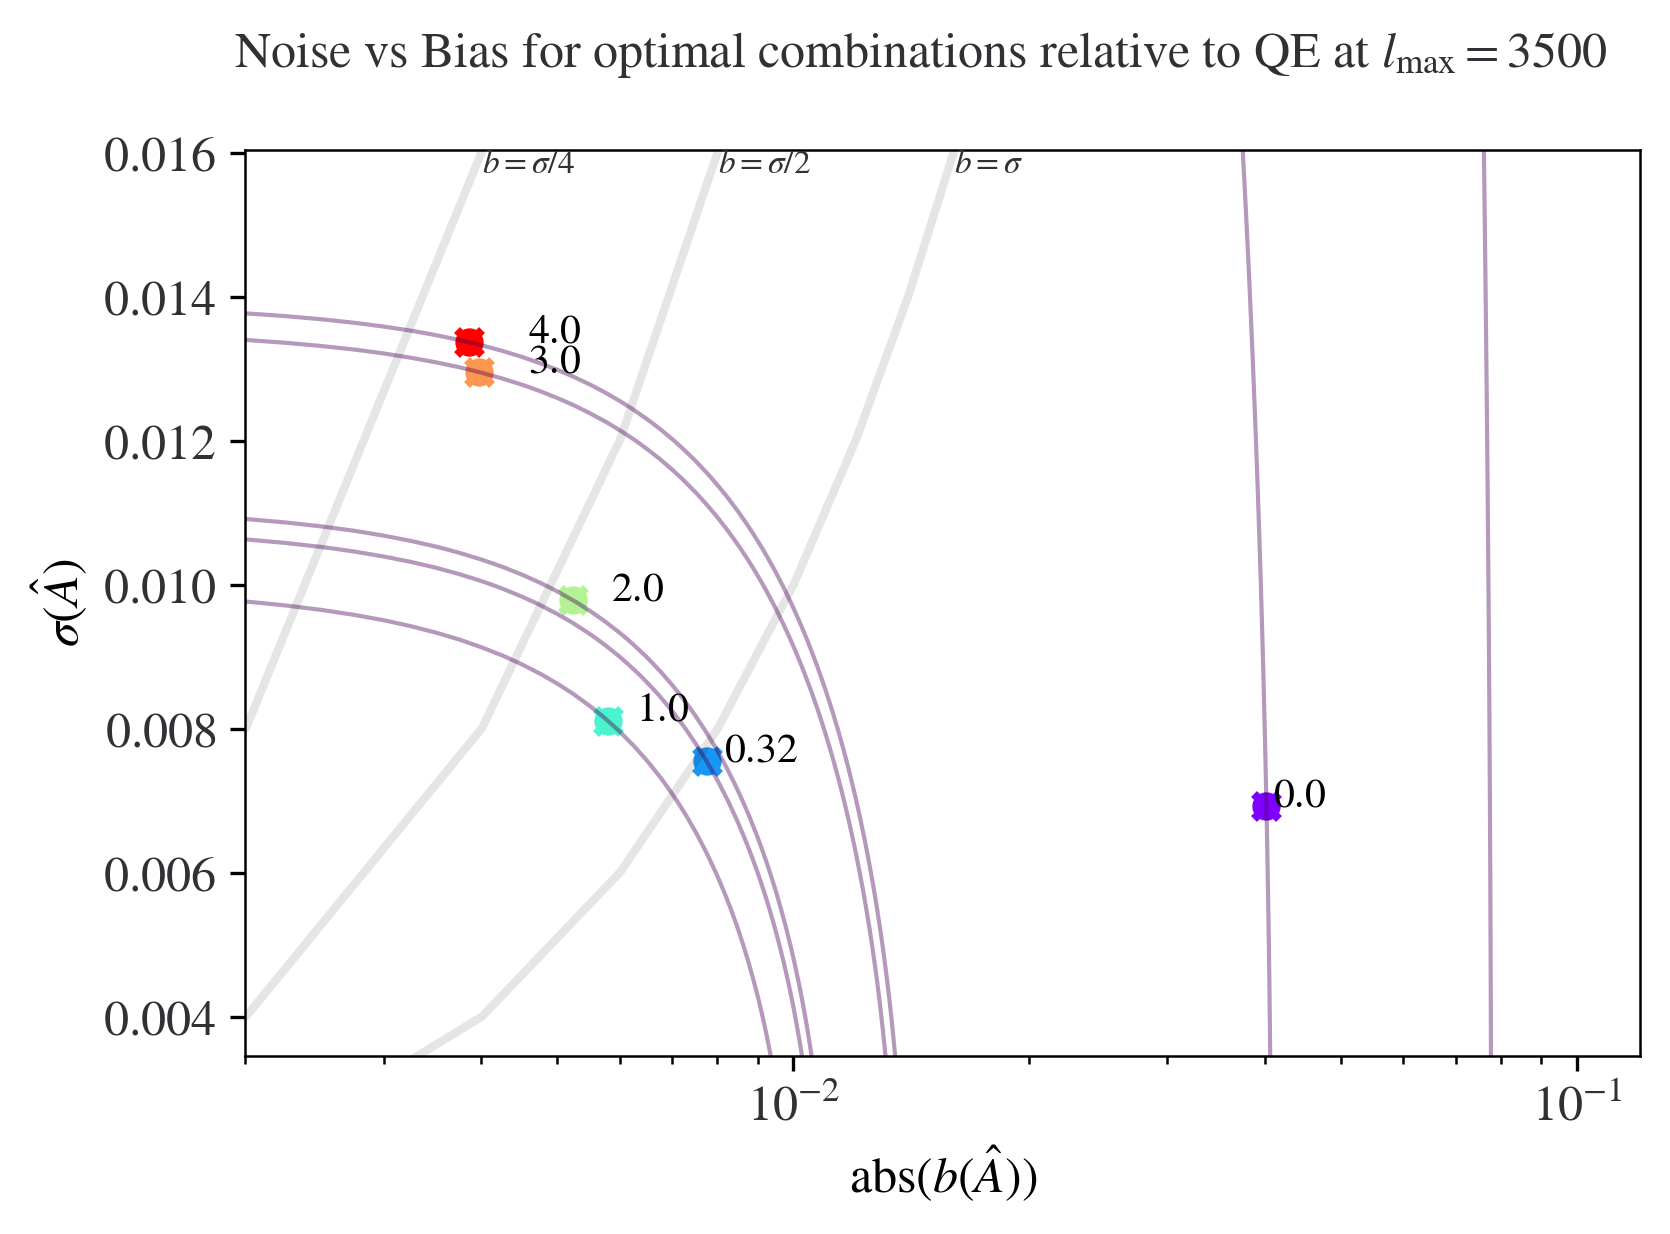

In [103]:
fig, ax = plt.subplots()
fig.suptitle(f'Case of {precisetitle}')
fig.suptitle('Noise vs Bias for optimal combinations relative to QE at $l_{\mathrm{max}}=3500$')
ax.set_ylabel('$\\sigma(\hat{A})$')
ax.set_xlabel('$\mathrm{abs}(b(\hat{A}))$')

alpha = 0.1

cases = [1, 2, 4]
for c in cases:
    
    xmax = 1.
    
    xx = np.linspace(0, xmax, 500)
    yy = c*np.linspace(0, xmax, 500)
    rad = np.arctan(c)
    angledeg = np.rad2deg(rad)
    
    
    
    text = '' if c == 1 else f'/{c}'
    
    ymin = min(min(ns)*(1-0.5), min(ns_no_filt)*(1-0.5))
    ymax = max(max(ns)*(1+0.2), max(ns_no_filt)*(1+0.2))
    
    bbA = max(yy[ (yy>=ymin) & (yy<=ymax)])
    #bbB = max(yy[ (xx<=xmax)])
    bb = bbA
    aa = xx[np.where(bb==yy)]

    ax.text(aa, bb,  '$b=\sigma$'+f'${{{text}}}$', ha="left", va="top", size = 8)
    ax.plot(xx, yy, lw = 2, color = 'black', alpha = alpha)
    
    
    
    xx = np.linspace(0, xmax, 500)
    yy = c*np.linspace(0, xmax, 500)
    rad = np.arctan(c)
    angledeg = np.rad2deg(rad)
    text = '' if c == 1 else f'/{c}'
    ymax = max(max(ns)*(1+0.2), max(ns_no_filt)*(1+0.2))
    bbA = max(yy[ (yy>=ymin) & (yy<=ymax)])
    bb = bbA
    aa = xx[bb==yy]
    #ax.text(aa, bb,  '$b=\sigma$'+f'${{{text}}}$', ha="left", va="top", size = 8, alpha = alpha)
    #ax.plot(xx, yy, lw = 2, color = 'black', alpha = alpha/2, ls = '--')



for i, c in enumerate(zip(abs(bs), ns)):
    b, n = c
    ax.scatter(b, n, color = colors_plotting[i], marker = 'x')#, label = all_best_direcs[i])
    
    b, n = (abs(bs_no_filt))[i], (ns_no_filt)[i]
    ax.scatter(b, n, color = colors_plotting[i])
    
    fbname = np.round(np.sqrt(fbs[i]), 2)
    text = f'{fbname}, b = {round(b, 4)}, n = {round(n, 4)}, brthuok3500 = {round(b/b_ref_filt, 4)}, nrthuok3500 = {round(n/n_ref, 4)}'
    text = f'${fbname}$'
    alpha = 0.2*i/len(fbs)+0.02
    ax.annotate(text, (b*(1+alpha), n), color = 'black')
    
    
    fff = np.sqrt(b**2+n**2)
    #circle = plt.Circle((2e-9, 2e-9), fff, edgecolor = colors_plotting[i], fill = False)
    #ax.add_patch(circle)

    x = np.linspace(1e-11, 1.0, 4000)
    y = np.linspace(1e-11, 1.0, 4000)
    X, Y = np.meshgrid(x,y)
    F = X**2 + Y**2 - fff**2.
    plt.contour(X, Y, F, [0], linewidths= 1, alpha = 0.4)
    
frefff = np.sqrt(b_ref_filt**2+n_ref**2.)
x = np.linspace(1e-11, 1.0, 1000)
y = np.linspace(1e-11, 1.0, 1000)
X, Y = np.meshgrid(x,y)
F = X**2 + Y**2 - frefff**2.
plt.contour(X,Y,F,[0], linewidths= 1, alpha = 0.4)

#ax.legend()
ymax = max(max(ns)*(1+0.2), max(ns_no_filt)*(1+0.2))
ymin = min(min(ns)*(1-0.5), min(ns_no_filt)*(1-0.5))
ax.set_ylim(ymin, ymax)


xmax = max(max(bs)*(1+0.2), max(bs_no_filt)*(3))
ax.set_xlim(2e-3, xmax = xmax)
ax.set_xscale('log')
fig.savefig(output_plots/'optimalcombstrendabsolute.png')
plt.show()  


In [81]:
frefff

0.07766403401346955

In [88]:
fff = np.sqrt(bs**2+ns**2)

frefff = np.sqrt(b_ref_filt**2+n_ref**2.)

In [89]:
fff#/frefff

array([0.04071574, 0.01082186, 0.00997374, 0.01110043, 0.0135537 ,
       0.01391854])

In [88]:
fs_no_filt/fs

array([1.        , 0.99825006, 0.99208852, 0.98885076, 0.82817595,
       0.68048869])

In [89]:
bs/ns

array([5.79415566, 1.04566186, 0.73520371, 0.70425856, 0.71567171,
       0.70633238])

In [90]:
bs_no_filt

array([0.04012257, 0.00775183, 0.00579376, 0.00522889, 0.00397179,
       0.00385953])

In [91]:
bs

array([0.04012257, 0.00788888, 0.00593139, 0.00587365, 0.00584517,
       0.00583518])

In [92]:
fbs

array([ 0. ,  0.1,  1. ,  4. ,  9. , 16. ])

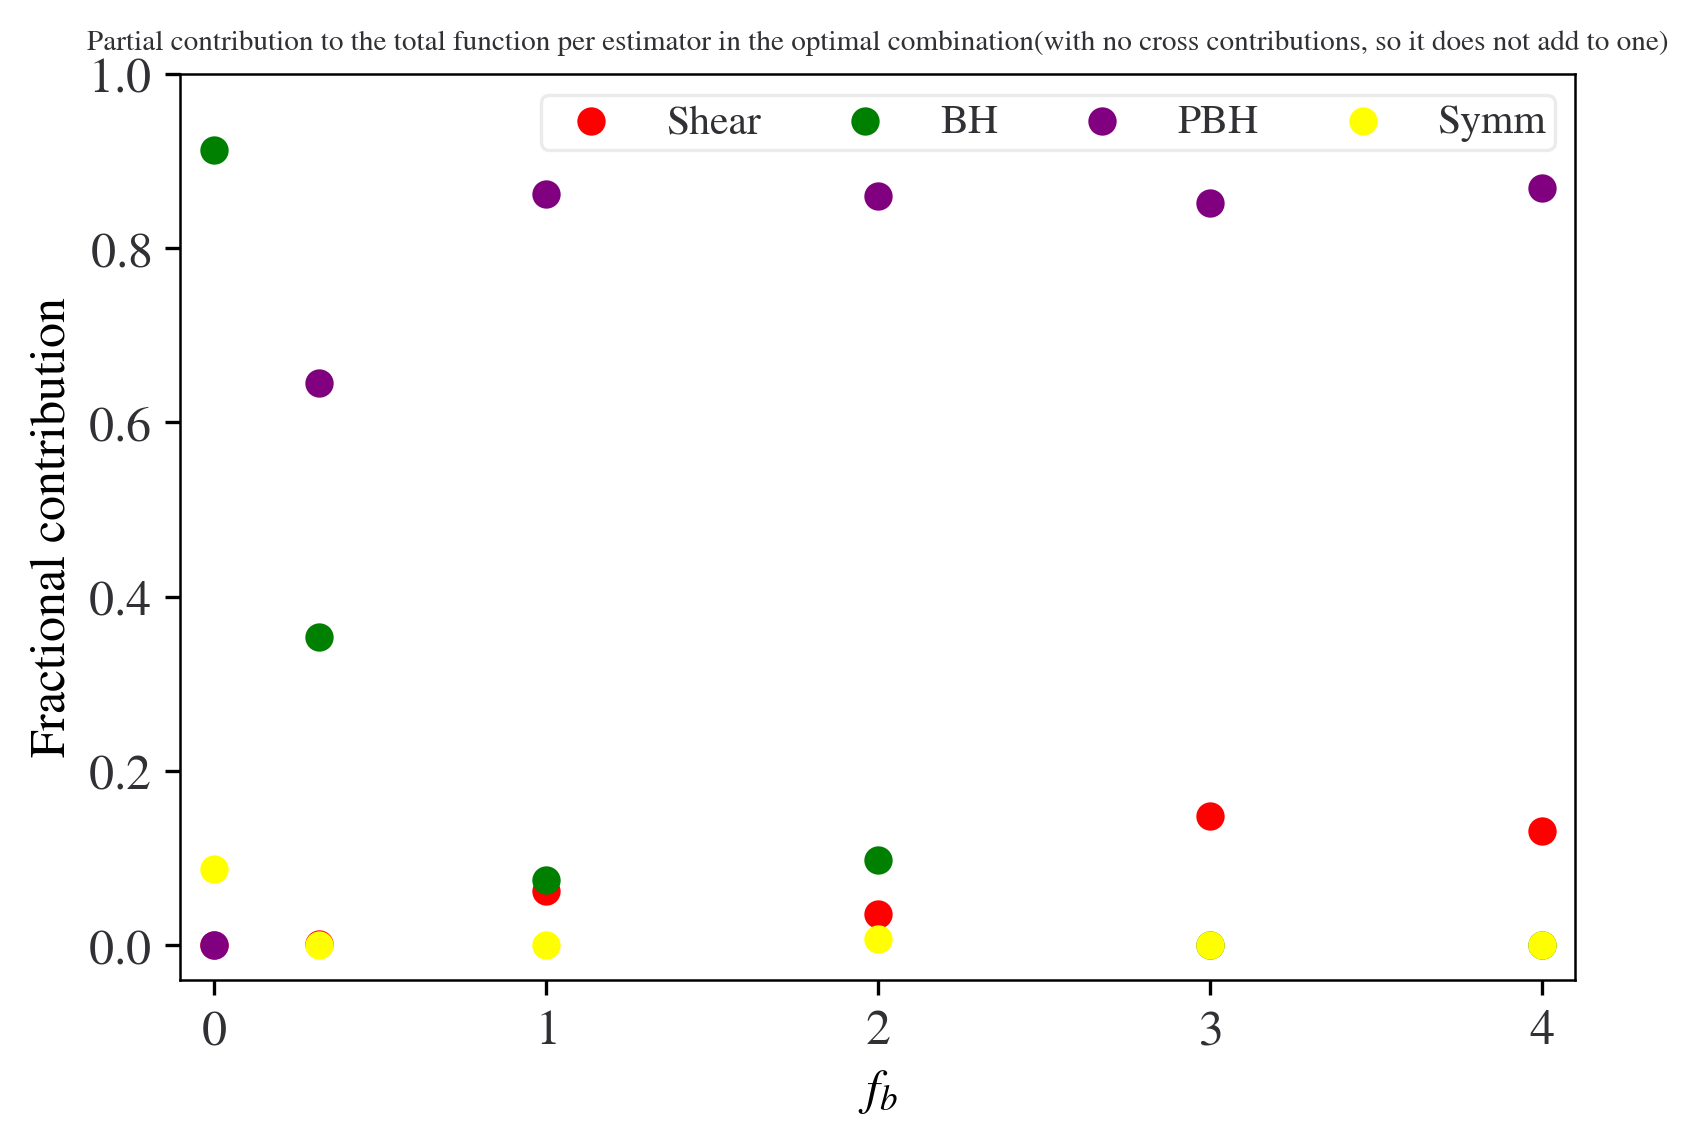

In [46]:
fig, ax = plt.subplots()
ax.set_title('Partial contribution to the total function per estimator in the optimal combination(with no cross contributions, so it does not add to one)', size = 7)
for fb in fbs:
    temp_list = partial_results[fb]
    #print(sum(temp_list))
    for i, e in enumerate(estimators):
        label = labeling[e] if fb == 0. else None
        ax.scatter(np.sqrt(fb), temp_list[i], label = label, color = colors[i])
ax.set_ylabel('$\mathrm{Fractional\ contribution}$')
ax.set_xlabel('$f_{b}$')
#xticklabs = [f'{np.round(np.sqrt(fb), 2)}' for fb in fbs]
#ax.set_xticklabels(['']+xticklabs)

#yticklabs = [f'{round(0.2*i, 2)}' for i in range(6)]
#ax.set_yticklabels(['']+yticklabs)
ax.legend(loc = 'best', ncol = len(estimators))
ax.set_xlim(-0.1, 4.1)
ax.set_ylim(-0.04)
fig.savefig(output_plots/'optimalcombscontributiontrend.png')
plt.show()

### Looking for the best

In [48]:
relevant_directorties = all_best_direcs_no_inv_variance
colors = ['red', 'green', 'purple', 'yellow']
names_W = list(names)+['$W_L$']
names_W

['shear', 'bh', 'pbh', 'symm', '$W_L$']

In [49]:
all_best_direcs_no_inv_variance

['s4500b4500p3000sy4500',
 's3000b3500p4000sy3000',
 's3000b3500p3500sy3500',
 's3000b3000p3500sy3000',
 's3000b3000p4000sy4500',
 's3000b3500p4000sy4000']

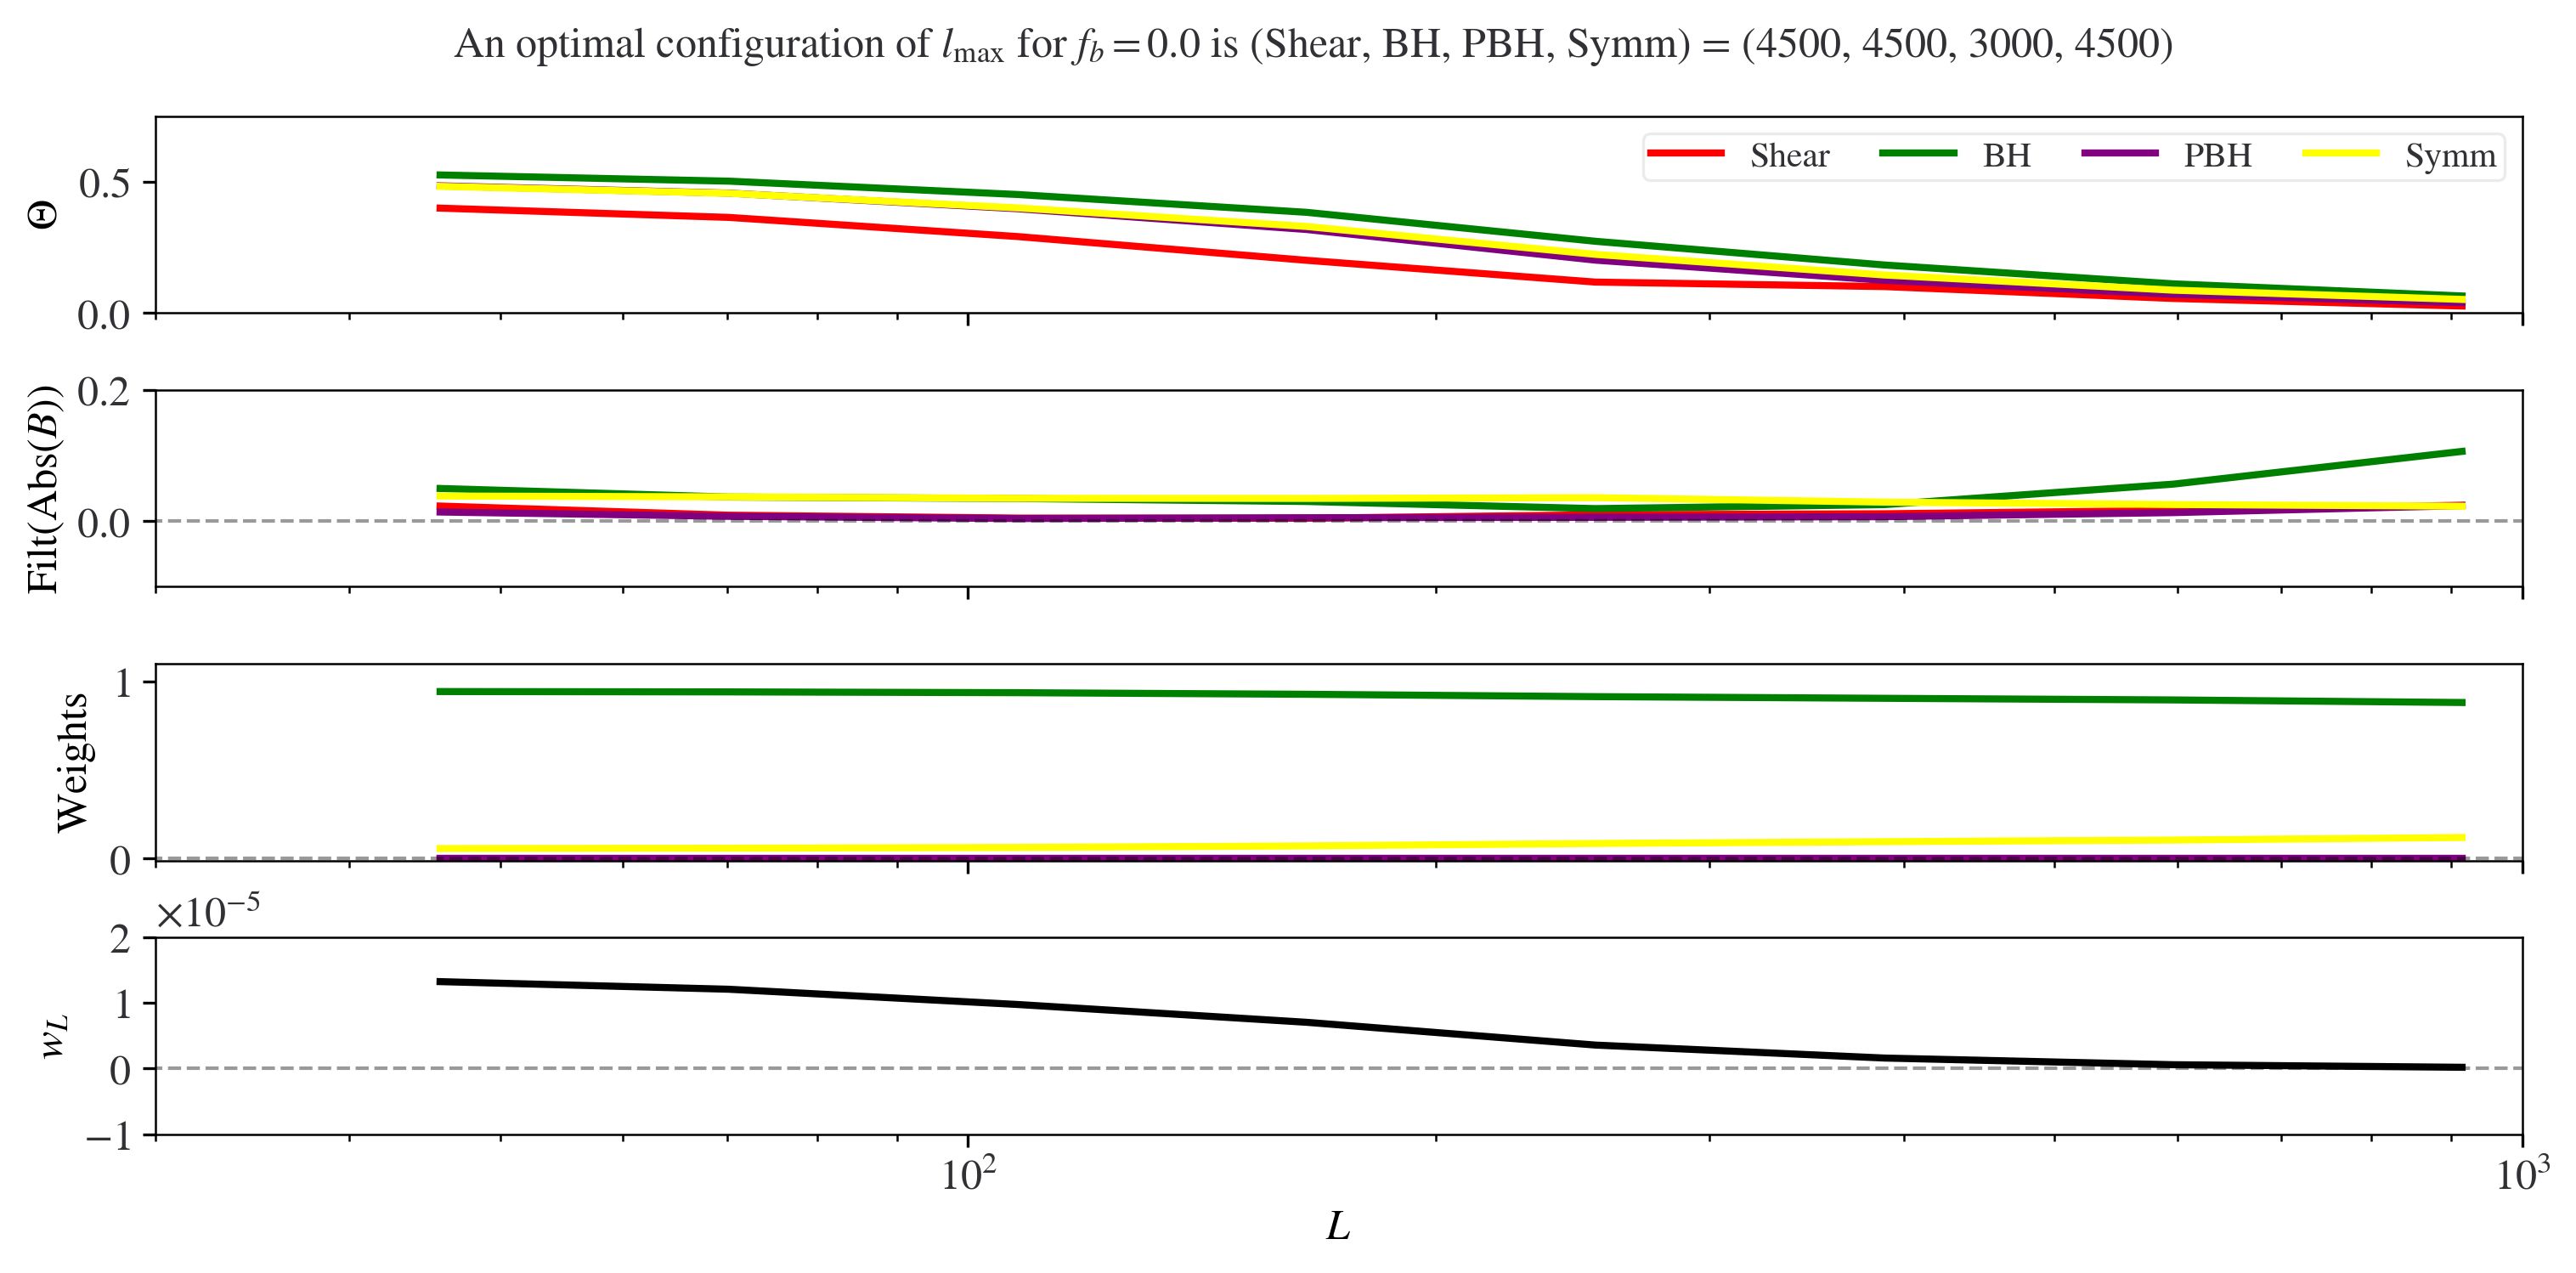

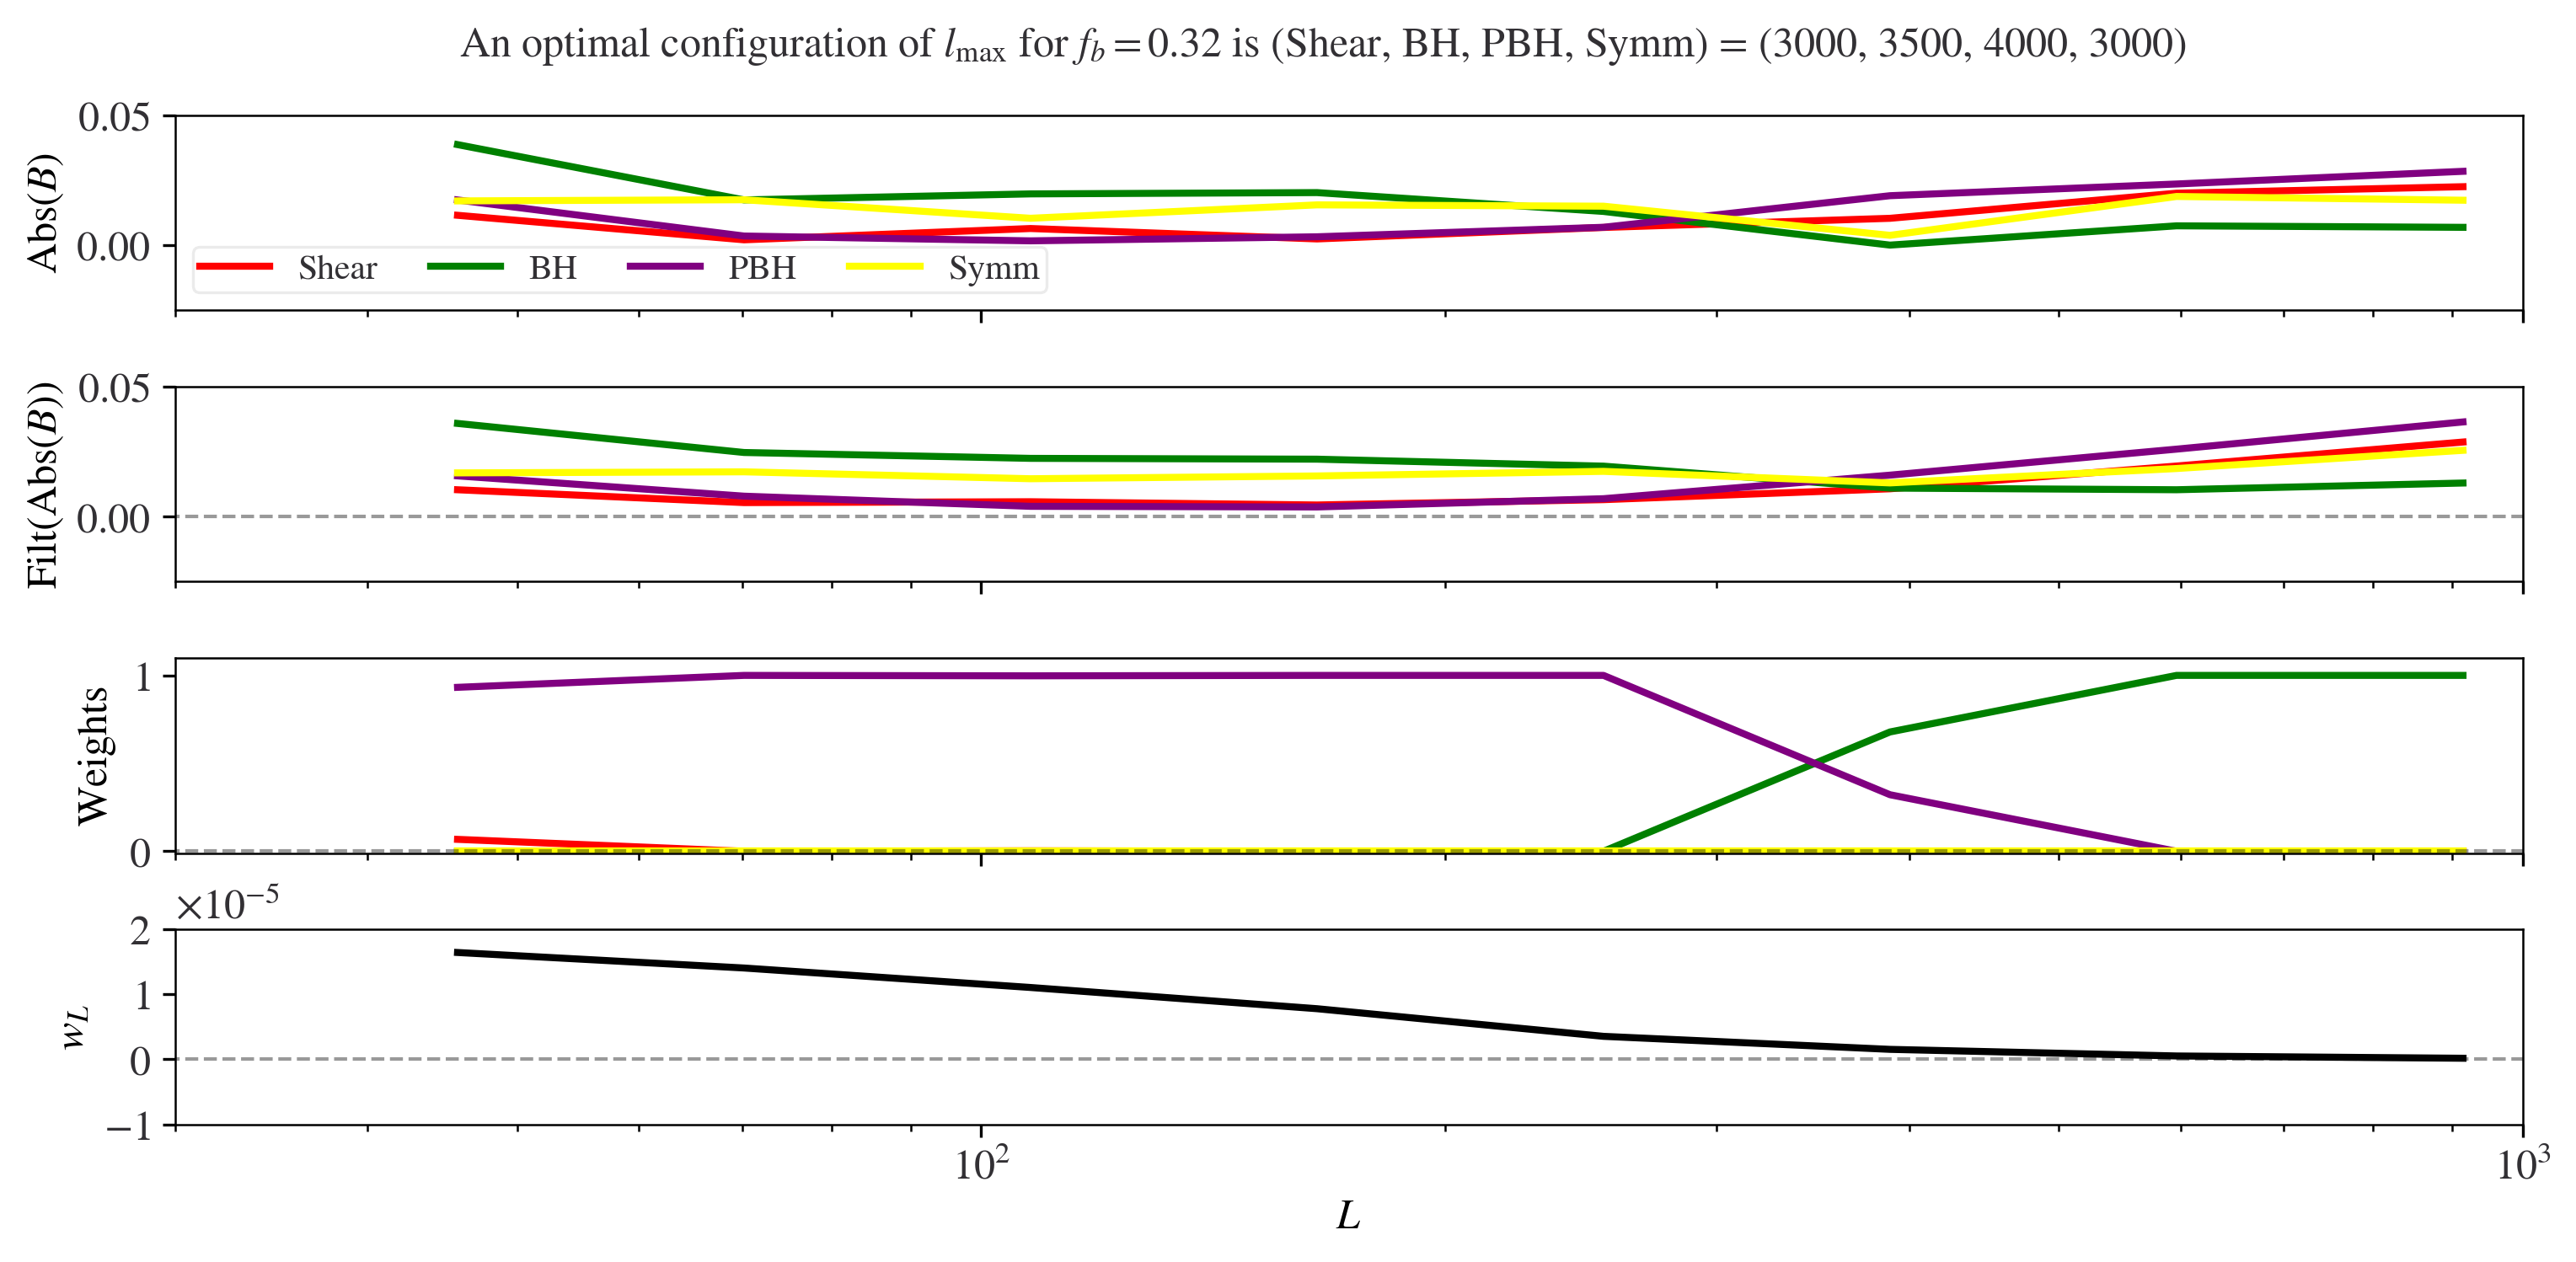

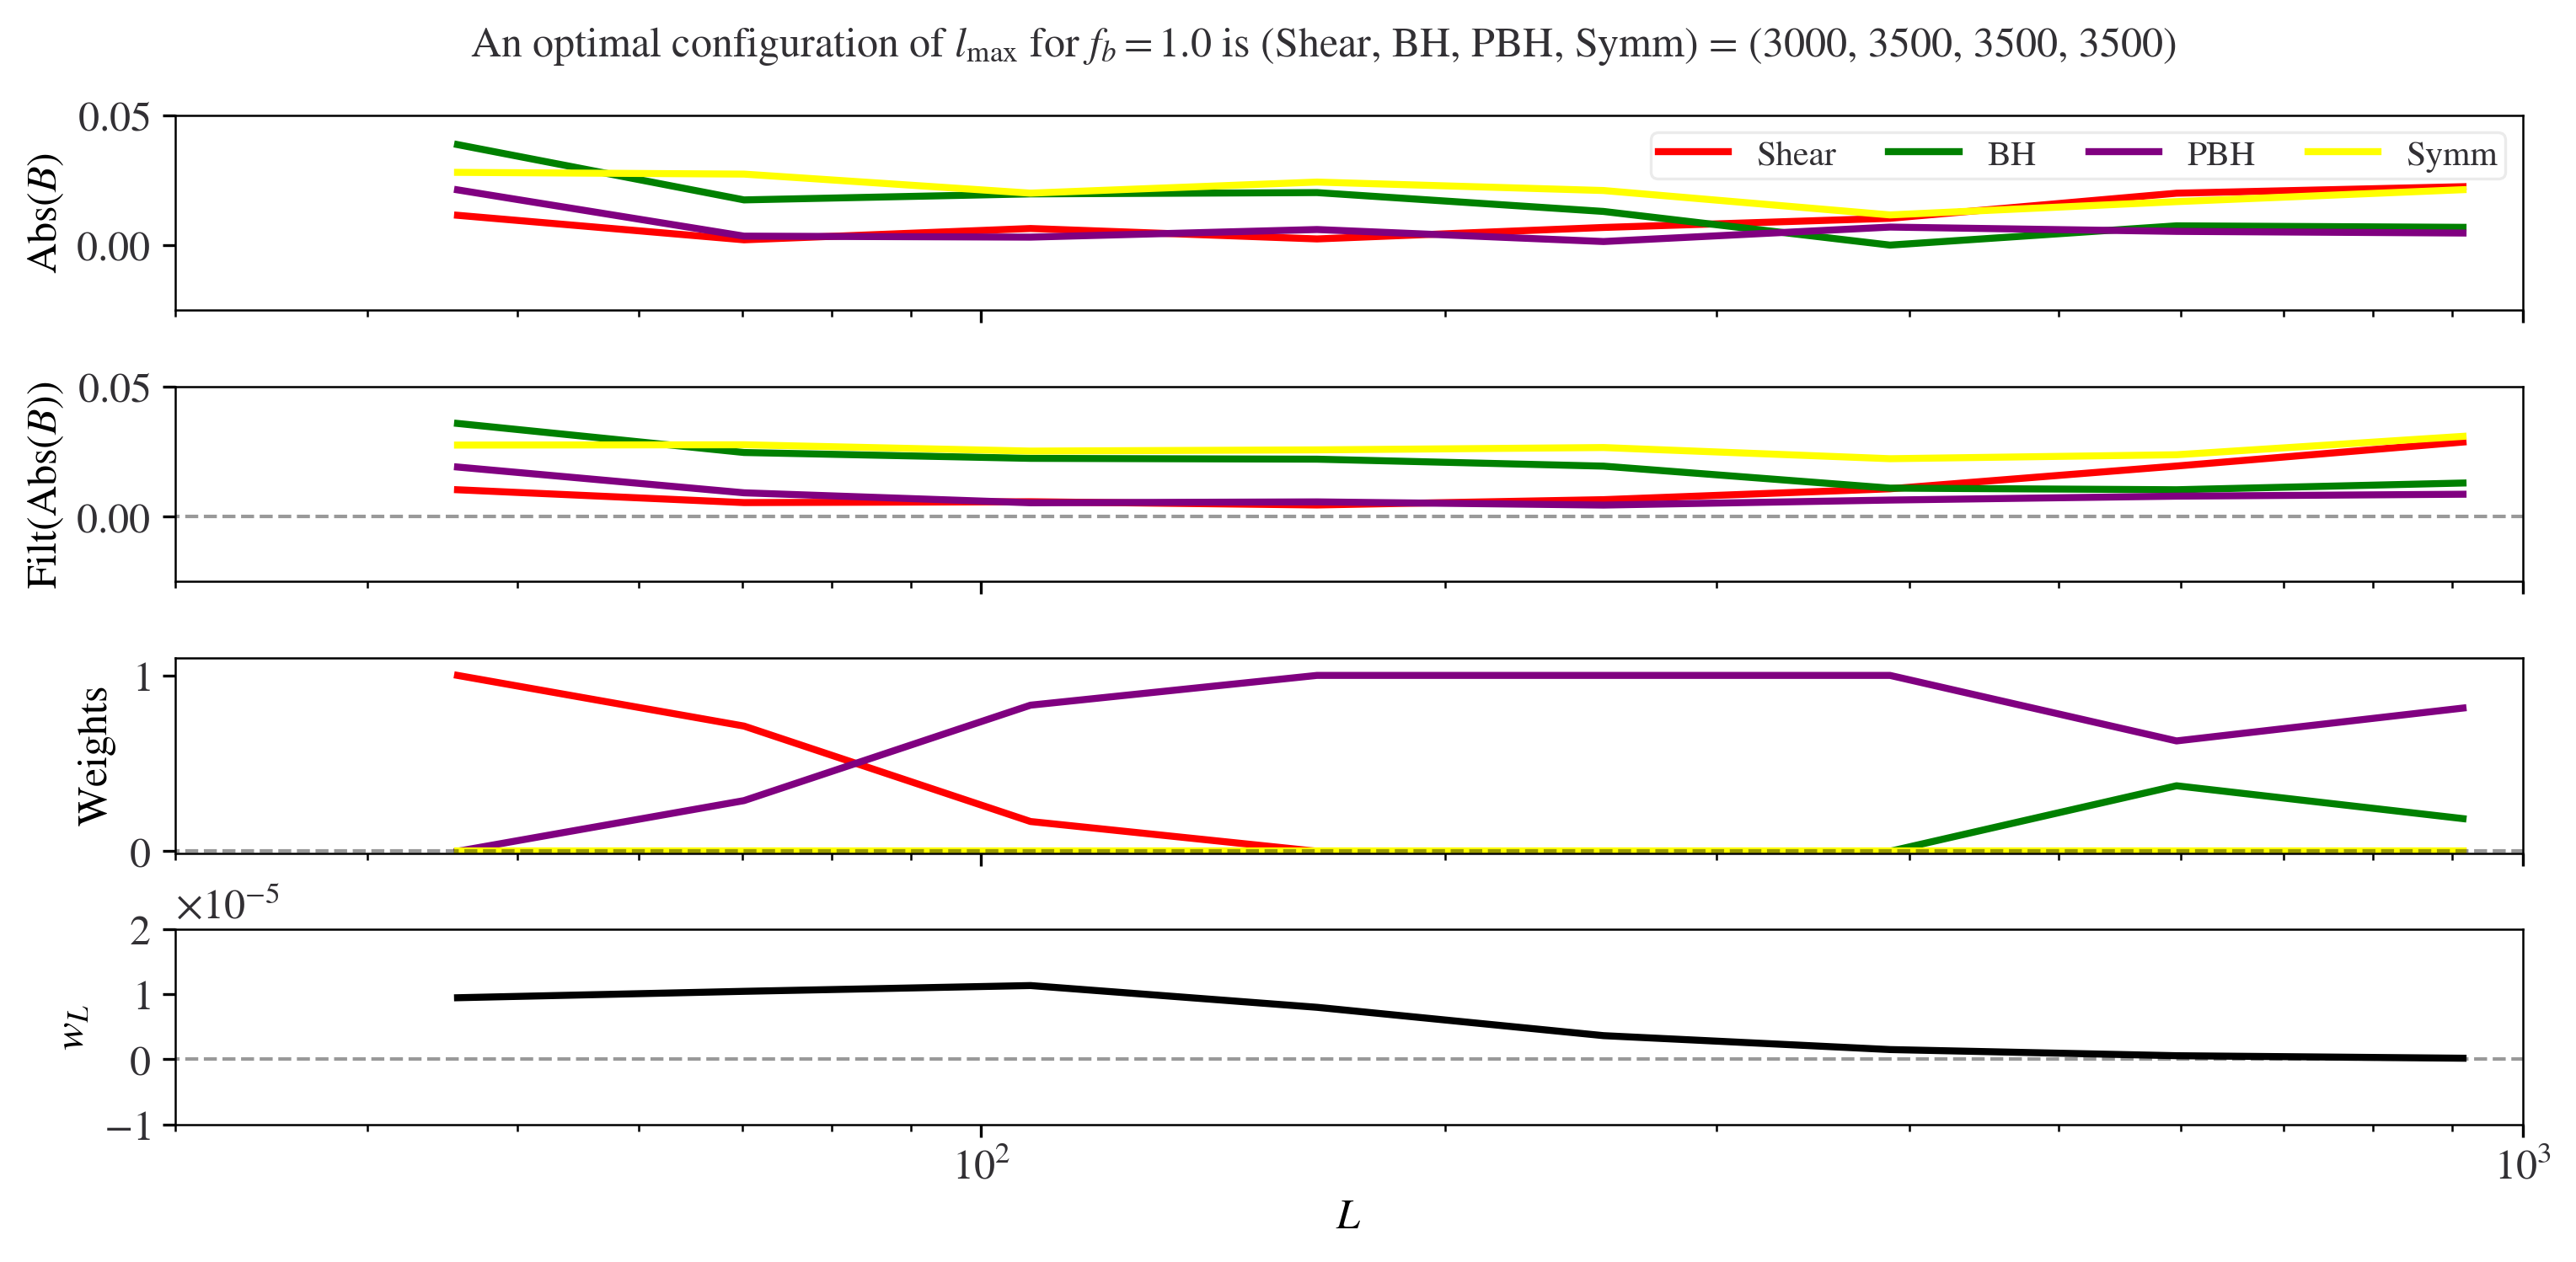

[[ 2.89154398e-01  1.70358400e-01  3.08384630e-01  2.32102573e-01
  -0.00000000e+00]
 [ 2.72177268e-15  1.04581894e-14  3.32938007e-14  1.00000000e+00
   1.66383419e-06]
 [ 2.21347939e-01  4.95714213e-15  7.78652061e-01  0.00000000e+00
   1.55742063e-05]
 [ 1.13885887e-12  1.00885376e-17  1.00000000e+00  0.00000000e+00
   8.43132245e-06]
 [ 2.03320123e-15  1.61554209e-15  1.00000000e+00  0.00000000e+00
   5.18215238e-06]
 [ 7.61377944e-16  2.91345430e-01  7.08654570e-01  0.00000000e+00
   2.52624670e-06]
 [ 2.03327736e-01  4.75937611e-01  6.63012776e-02  2.54433375e-01
  -0.00000000e+00]
 [ 3.25779875e-01  6.21918972e-02  2.00815222e-01  4.11213005e-01
  -0.00000000e+00]]


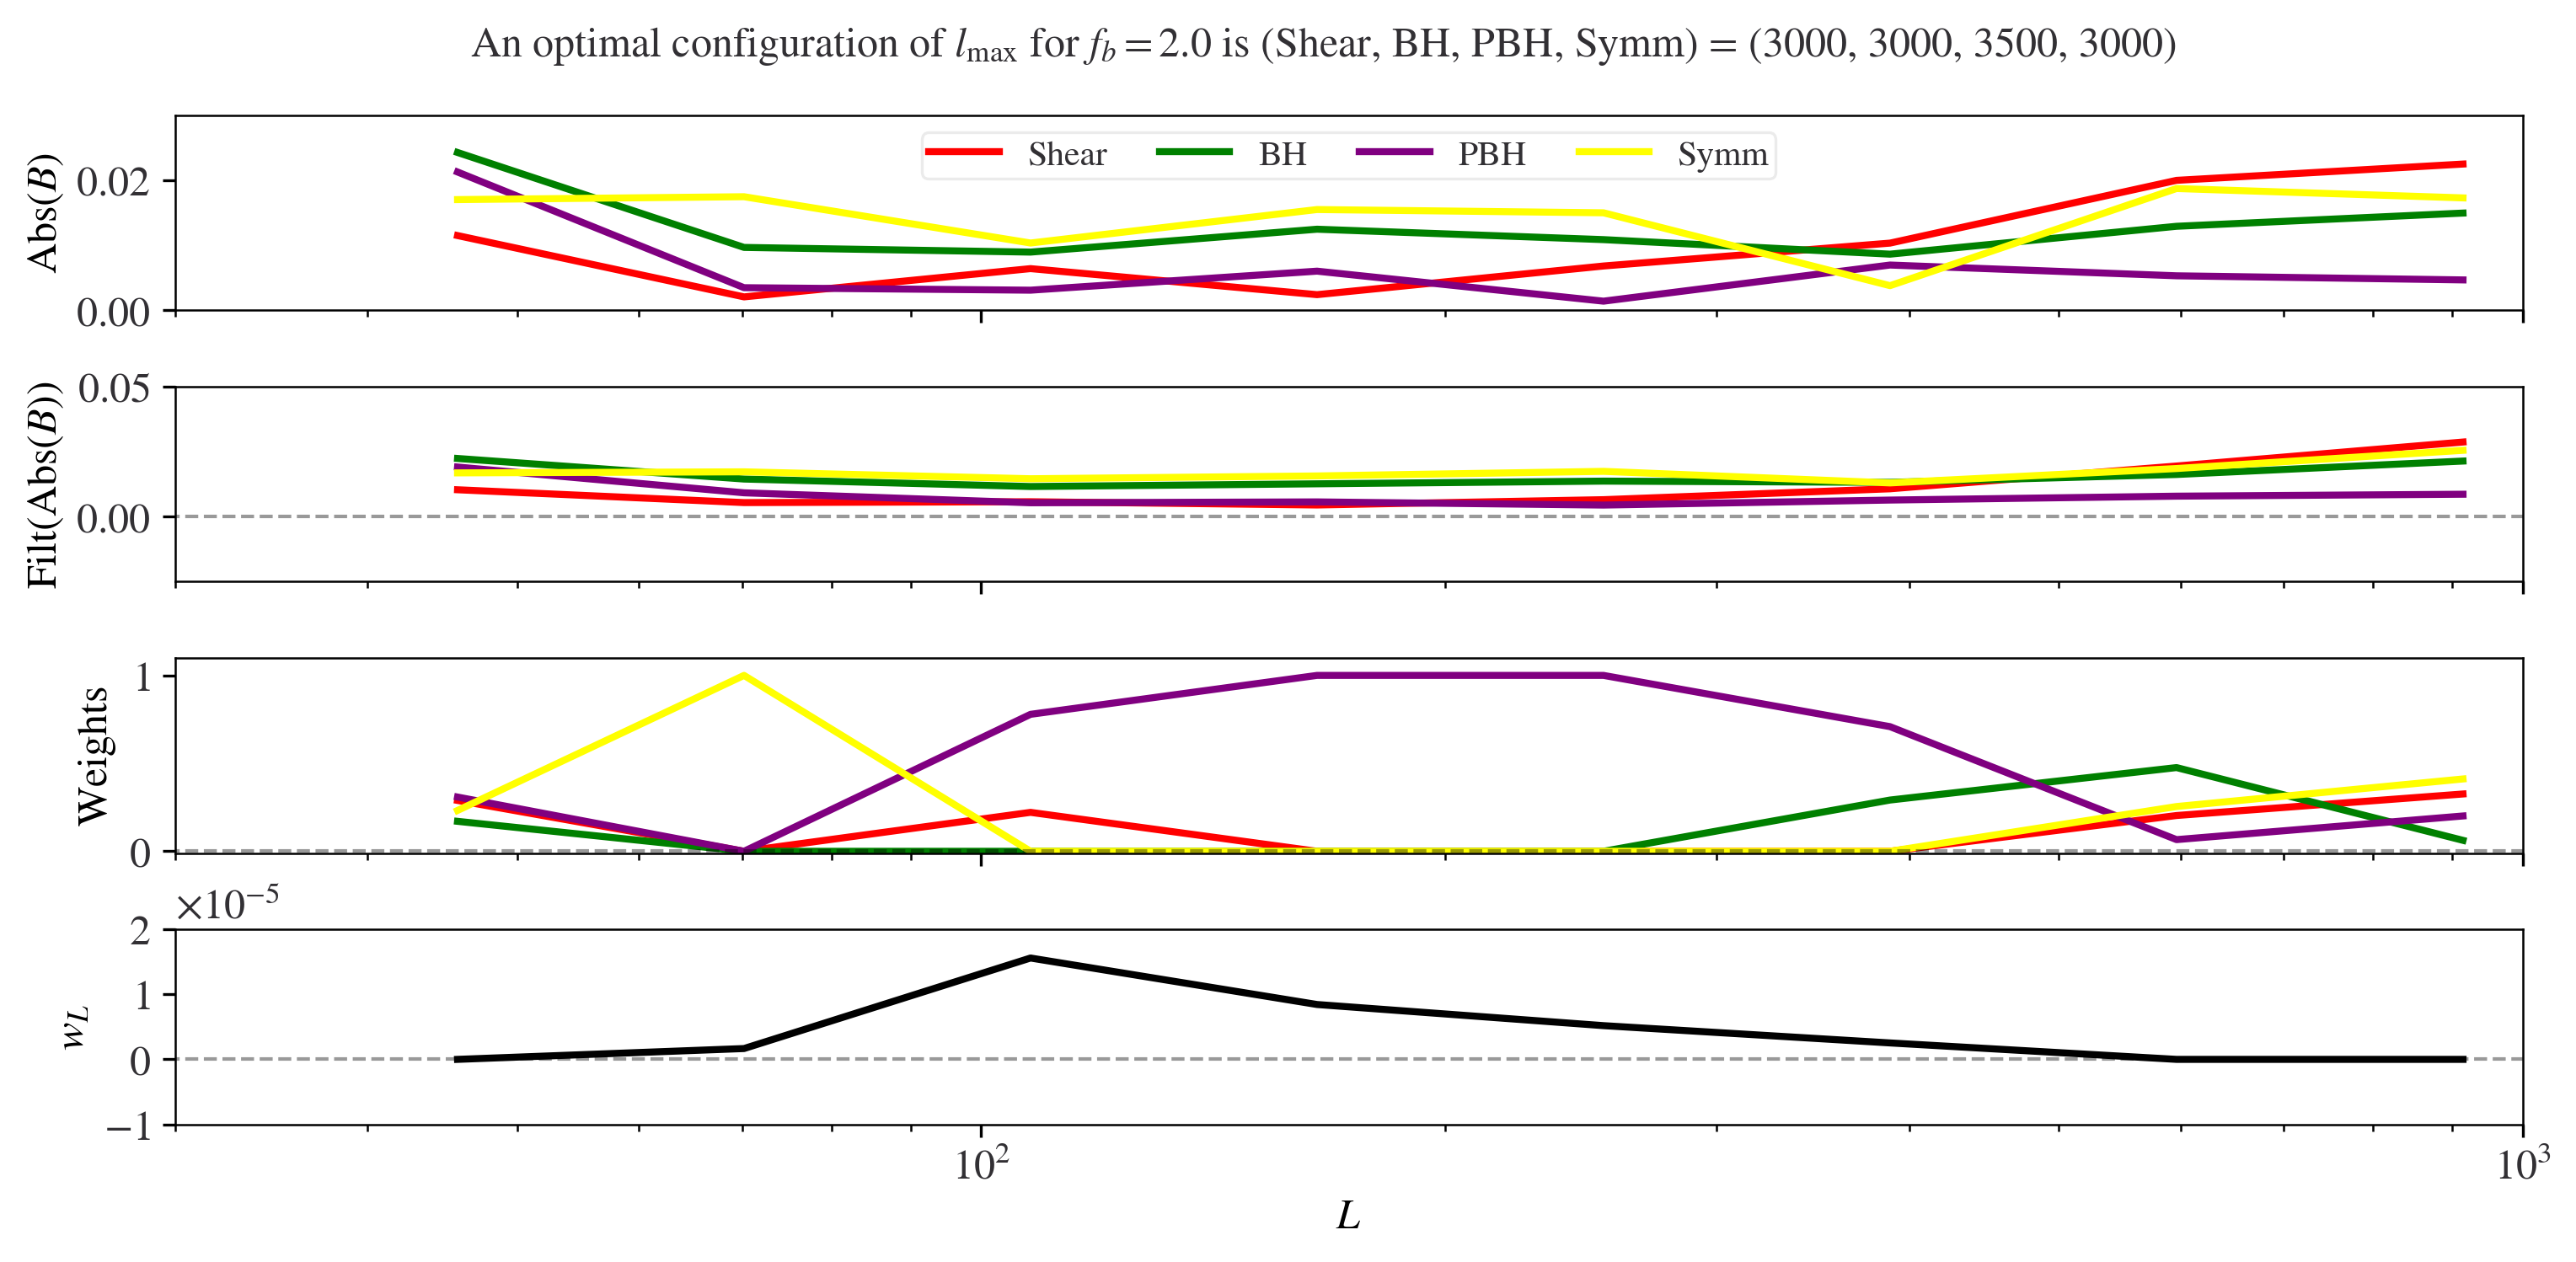

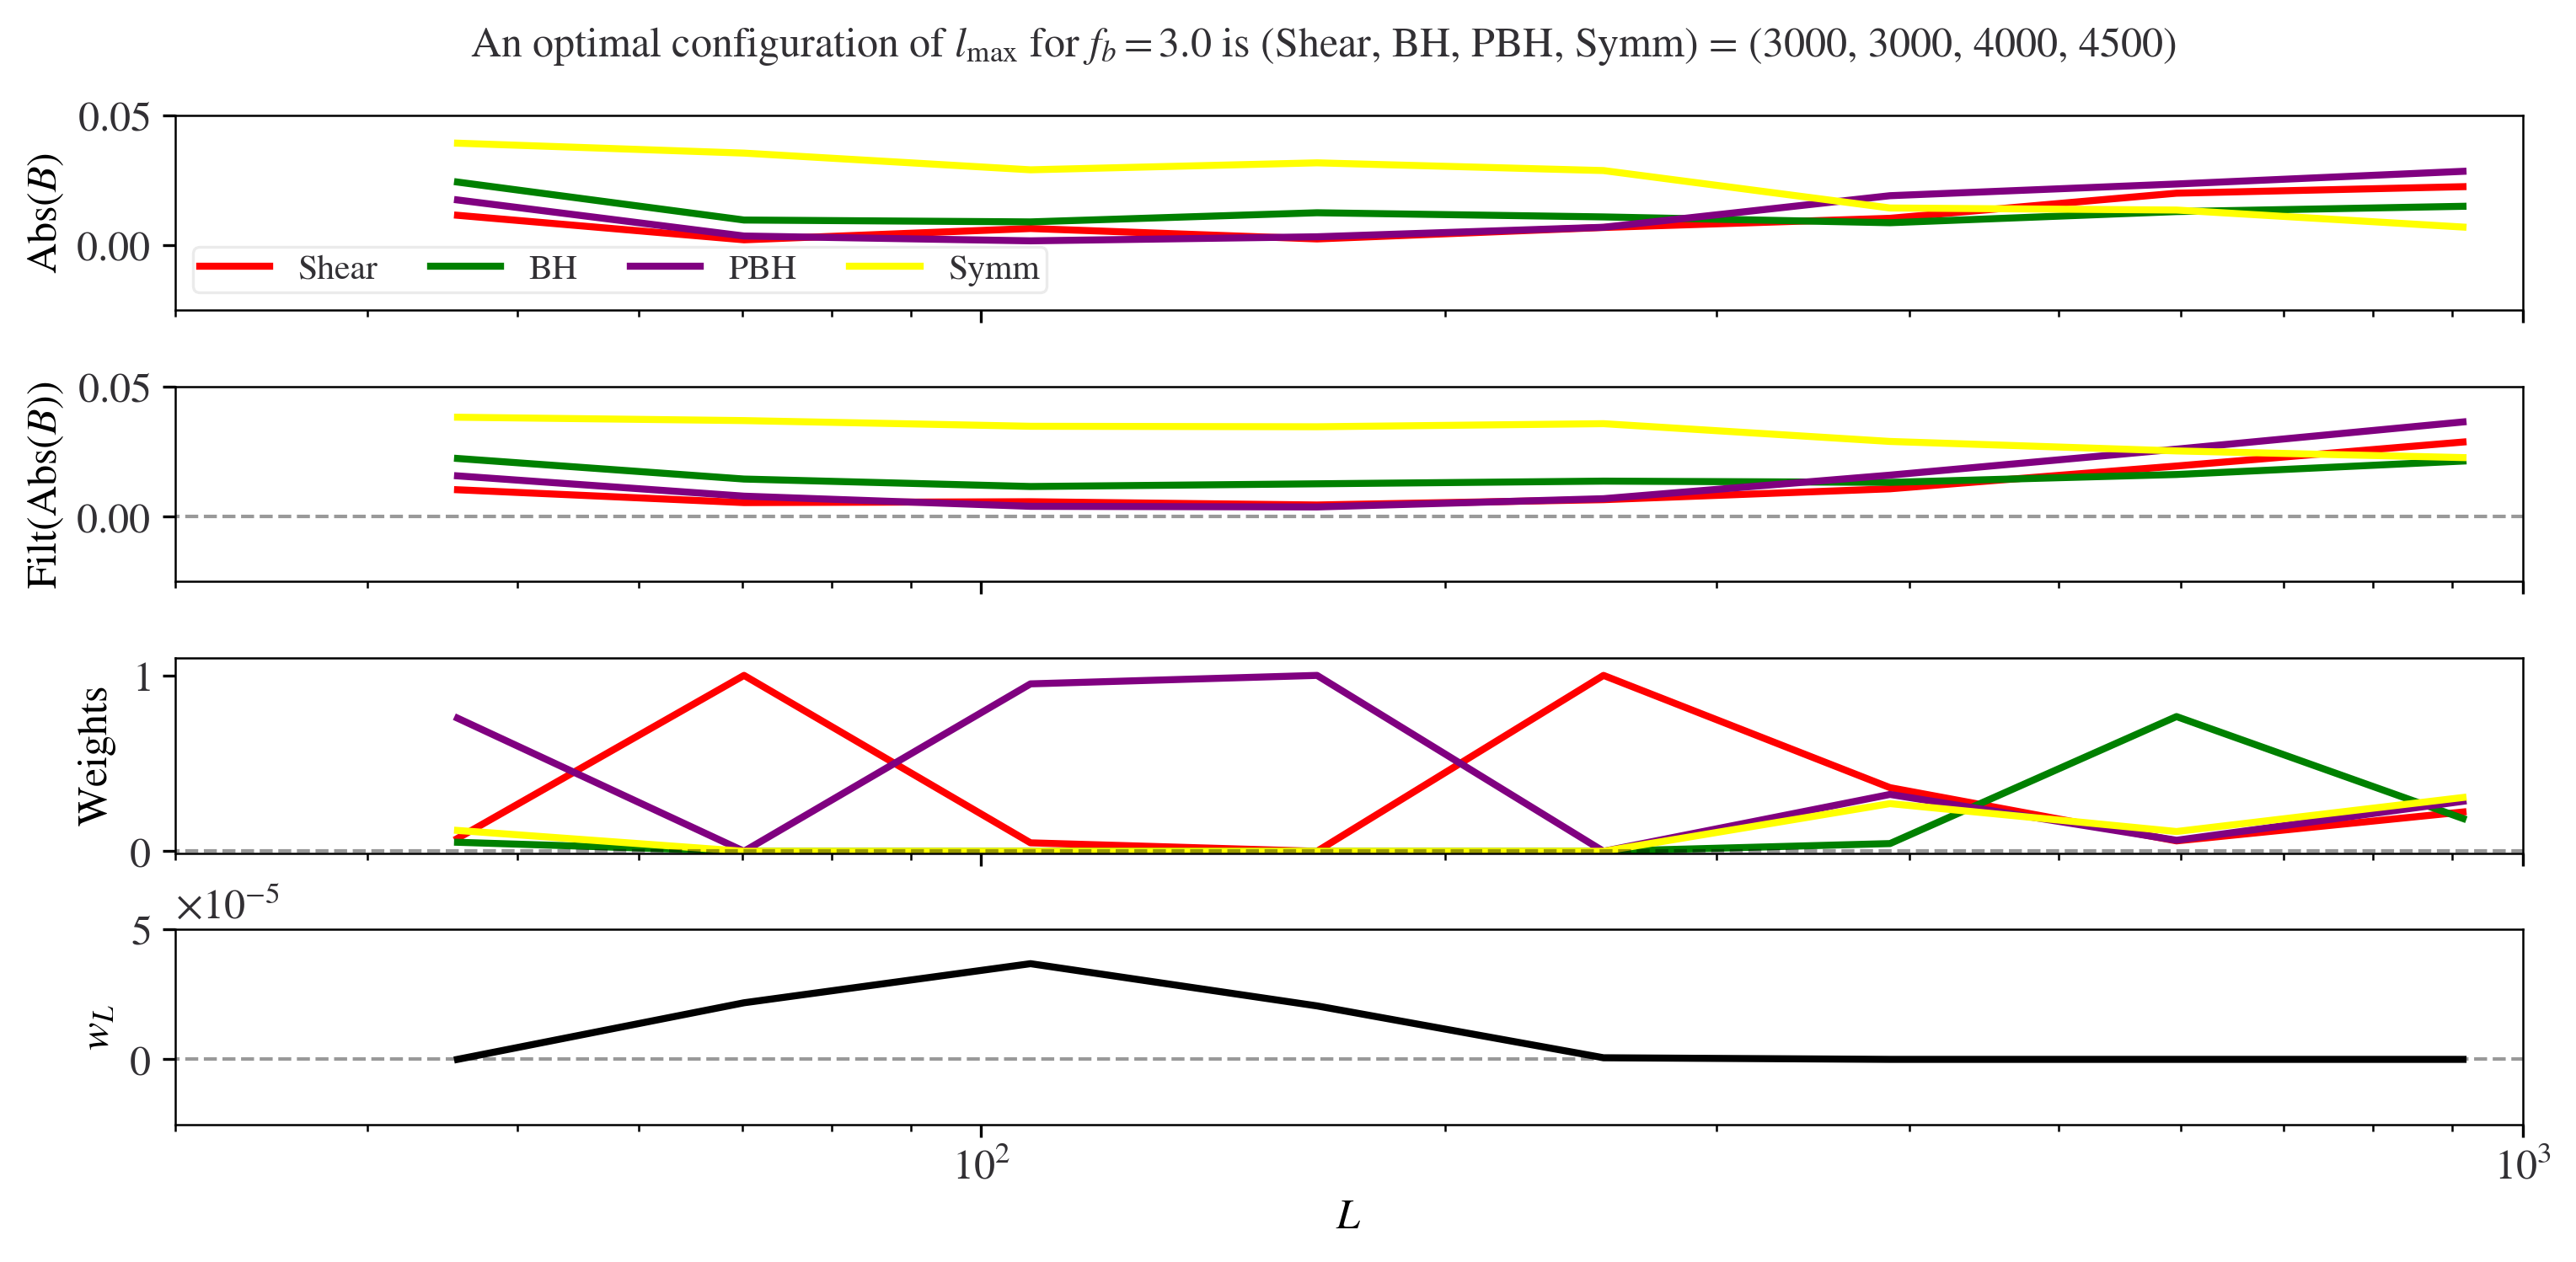

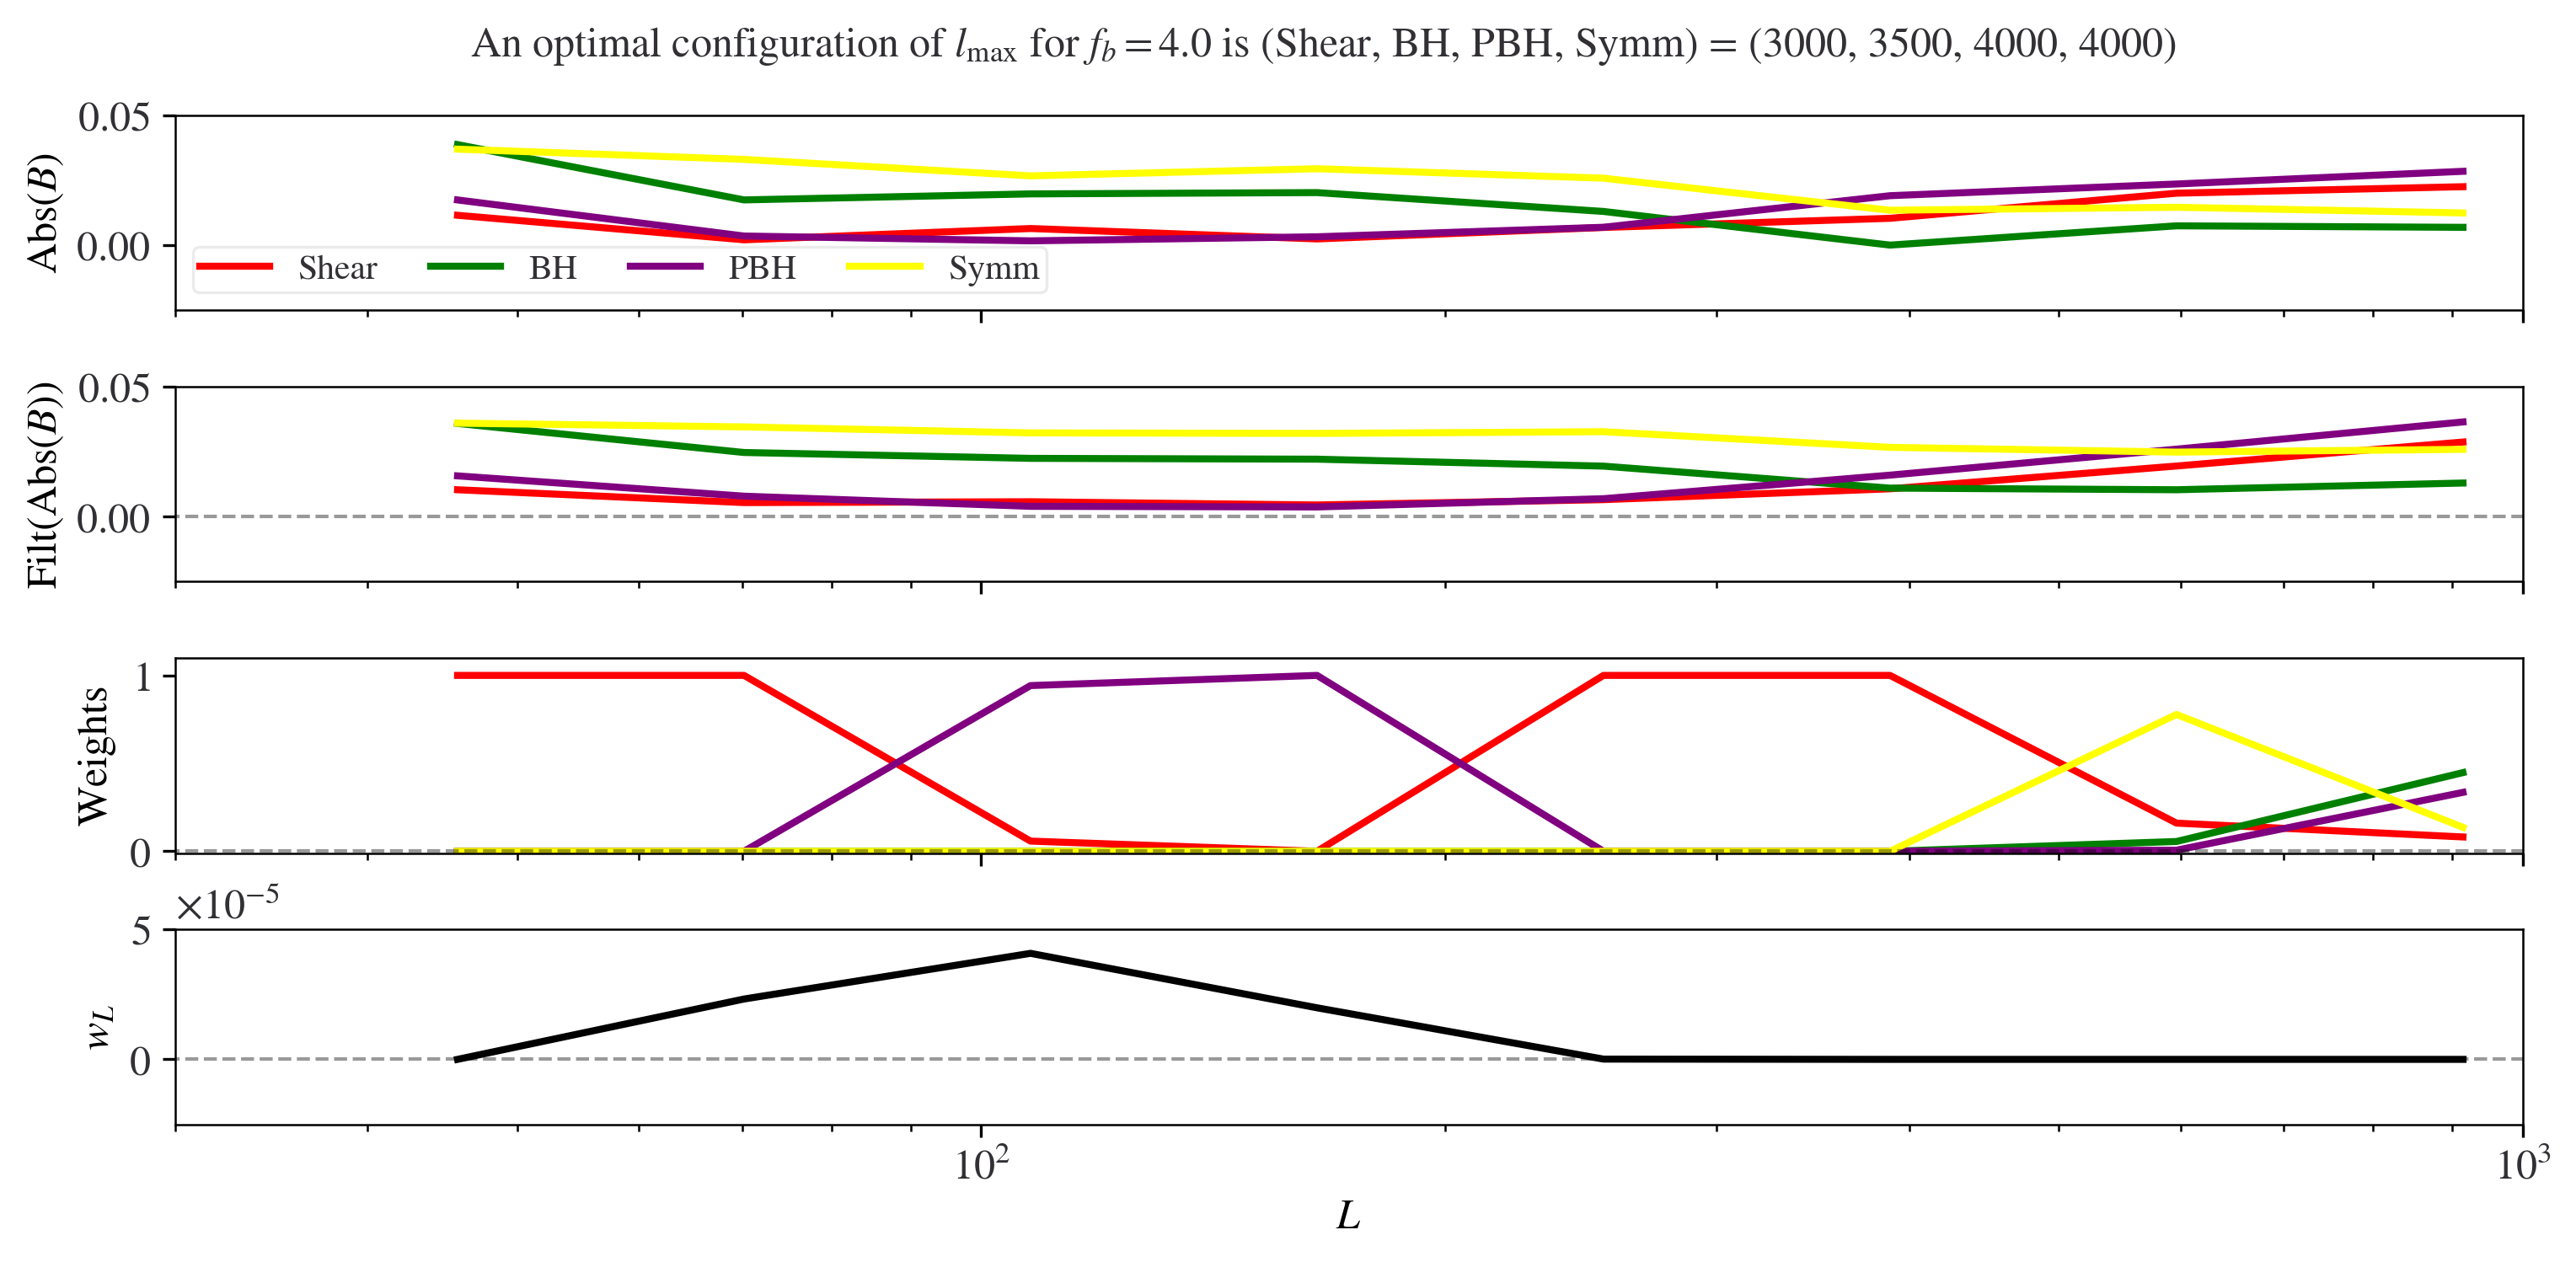

In [51]:
Ndir = len(relevant_directorties)

Nplots = 2
extranumber = 2
extraplots = 3


ns = np.array([])
bs = np.array([])
fs = np.array([])

for i, couple in enumerate(zip(relevant_directorties, fbs)):
    
    lmax_directory, fb = couple
    fbname = np.round(np.sqrt(fb), 2)
    
    lista_numeri = re.findall(r'\d+', lmax_directory)
    superlabel = '('
    superlabelnum = ' = ('
    for i_e, e in enumerate(estimators):
        extra = ', ' if i_e<len(estimators[:-1]) else ''
        superlabel += f'{labeling[e]}{extra}' 
        superlabelnum += f'${lista_numeri[i_e]}${extra}'
        
    superlabel += ')'
    superlabelnum += ')'
        
    superlabel += superlabelnum
    
    lmax_directory = pathlib.Path(lmax_directory)
    
    fig, axs = plt.subplots(nrows = Nplots+extranumber, figsize = (10, 5), sharex = True)

    fig.tight_layout(rect = [0, 0.03, 1, 0.95])
    fig.suptitle('An optimal configuration of $l_{\mathrm{max}}$'+f' for $f_b={fbname}$ is {superlabel}')
    #fig.subplots_adjust(hspace = 0.8)

    
    kk, theta, ells, biases, noises, w, x = get_info(pathlib.Path(lmax_directory), resultspath, fb = fb, invvardir = inv_variance_dir)
    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, abs(biases), noises)
    Ne = Optimizerkk.Ne
    
    for k in range(Optimizerkk.Ne):
        ff = lambda x: abs(x)
        #for j in range(k, Optimizerkk.Ne):
        if fb>0:
            axs[0].plot(Optimizerkk.ells_selected, ff(Optimizerkk.biases_selected[k, k]/Optimizerkk.theory_selected), label = labeling[names_W[k]], color = colors[k])
        elif fb == 0:
            axs[0].plot(Optimizerkk.ells_selected, np.sqrt((Optimizerkk.theta_selected[k, k, k, k]/Optimizerkk.theory_selected**2)**-1), label = labeling[names_W[k]], color = colors[k])
            
        axs[1].plot(Optimizerkk.ells_selected, Optimizerkk.filter_(abs(Optimizerkk.biases_selected), sigma = 1.5)[k, k]/Optimizerkk.theory_selected, color = colors[k])
    
    axs[1].plot(Optimizerkk.ells, Optimizerkk.ells*0., color = 'black', ls = '--', alpha = 0.4, lw = 1)
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    
    #print(fb, lmax_directory)
    
    results_array = np.load(resultspath/lmax_directory/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
    ftemp, ntemp, btemp = results_array
    
    bs = np.append(bs, btemp)
    ns = np.append(ns, ntemp)
    fs = np.append(fs, ftemp)
        
    for k in range(Optimizerkk.Ne):
        resultkk = best.Res()
        #d = make_table(resultspath, all_lmaxes_directories, ['BH', 'SYBH', 'PH', 'SY'], fb = fb, include_estimators = False)
        #direc = d.sort_values(by = 'Total Auto').head(1).iloc[0, 0]
        resultkk.load_all(resultspath/lmax_directory, f'auto_fb_{fb}{crosstag}')
        weights = resultkk.ws[:, k]
        weights[weights<1e-5] = 0.
        #print(d.sort_values(by = 'Total Auto').head(1))
        fbname = np.round(np.sqrt(fb), 2)
        label = f'{fbname} {lmax_directory}' if k == 0 else None
        axs[0+extranumber].plot(Optimizerkk.ells_selected, weights, color = colors[k])
        
    if fb == 4:
            print(resultkk.ws)
        
    axs[0+extranumber].set_ylabel('$\mathrm{Weights}$')
    #axs[0+extranumber].legend(ncol = 2, loc = 'best')
    axs[0+extranumber].set_ylim(-0.01, 1.1)
    axs[0+extranumber].set_yscale('linear')
    
    wl = resultkk.ws[:, -1]
    axs[1+extranumber].plot(Optimizerkk.ells_selected, wl, color = 'black')
    #axs[1+extranumber].legend(ncol = 1, loc = 'best')
    axs[1+extranumber].set_ylabel('$w_L$')
    
    axs[1+extranumber].set_xlabel('$L$')    
    axs[1+extranumber].set_xscale('log')
    
    axs[0+extranumber].plot(Optimizerkk.ells, Optimizerkk.ells*0., color = 'black', ls = '--', alpha = 0.4, lw = 1)
    axs[1+extranumber].plot(Optimizerkk.ells, Optimizerkk.ells*0., color = 'black', ls = '--', alpha = 0.4, lw = 1)

    if fb > 0:
        axs[0].set_ylabel('$\mathrm{Abs}(B)$')
    elif fb == 0.:
        axs[0].set_ylabel('$\Theta$')
        
    axs[0].legend(ncol = Ne)
    axs[1].set_ylabel('$\mathrm{Filt}(\mathrm{Abs}(B))$')
    np.round(np.sqrt(fb), 2)
    
    axs[-1].set_xlim(30, 1000)
    fig.savefig(output_plots/f'optimalcombs_{fbname}.png', bbox_inches = 'tight')
    plt.show()

### Exploring Optimal Neighbours

                      Name  Total Auto  Noise Auto  Bias Auto
192  s4500b4500p3000sy4500    0.000048    0.006925   0.040123
209  s4500b4500p3500sy4500    0.000048    0.006925   0.040123
18   s4500b4500p4000sy4500    0.000048    0.006925   0.040123
57   s4500b4500p4500sy4500    0.000048    0.006925   0.040123
116  s4000b4500p3000sy4500    0.000048    0.006925   0.040117
     Bias Auto  Noise Auto rtr  Bias Auto rtr
192   0.040123        1.009492       1.419506
209   0.040123        1.009492       1.419506
18    0.040123        1.009492       1.419506
57    0.040123        1.009492       1.419506
116   0.040117        1.009492       1.419321
s4500b4500p3000sy4500
0.006924662578475446 0.006924662578475446


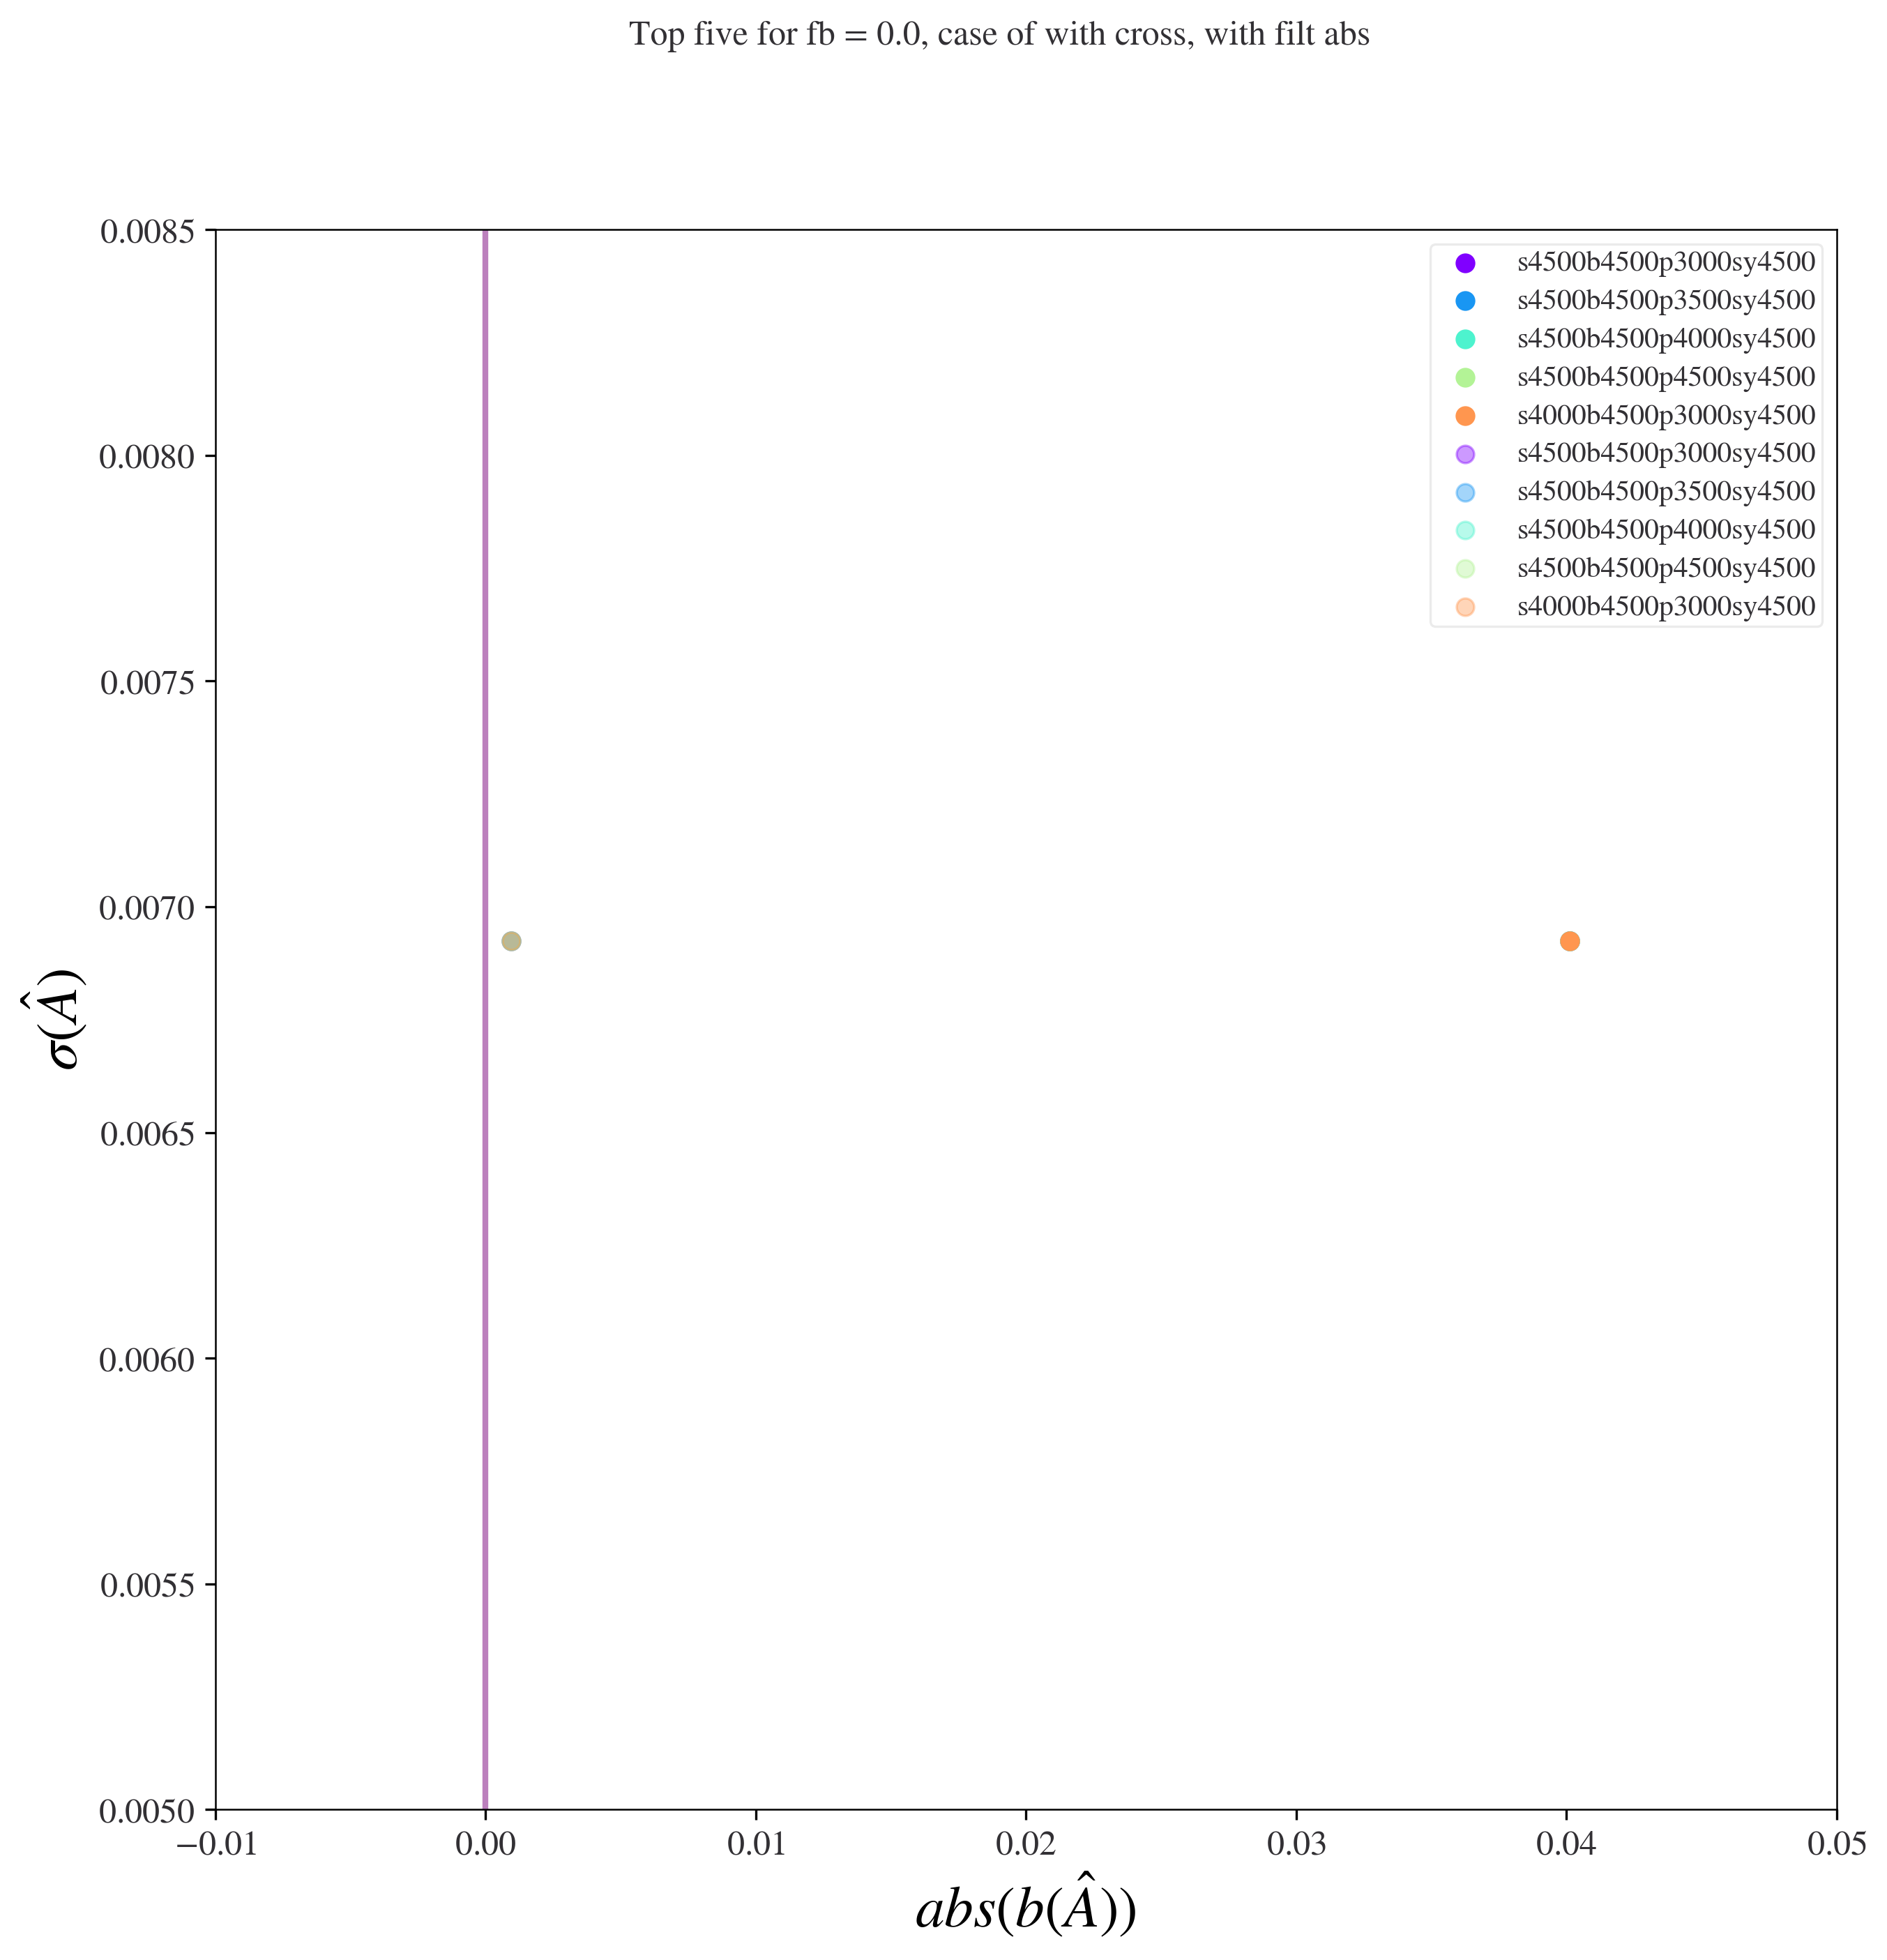

                      Name  Total Auto  Noise Auto  Bias Auto
216  s3000b3500p4000sy4500    0.000063    0.007551   0.007752
190  s4000b3500p4000sy4000    0.000063    0.007551   0.007754
238  s4500b3500p4000sy4500    0.000063    0.007551   0.007754
189  s3500b3500p4000sy3500    0.000063    0.007551   0.007754
14   s3500b3500p4000sy3000    0.000063    0.007551   0.007754
     Bias Auto  Noise Auto rtr  Bias Auto rtr
216   0.007752        1.100840       0.274254
190   0.007754        1.100814       0.274331
238   0.007754        1.100814       0.274331
189   0.007754        1.100814       0.274331
14    0.007754        1.100814       0.274331
s3000b3500p4000sy4500
0.007551270555557539 0.007551270555557539


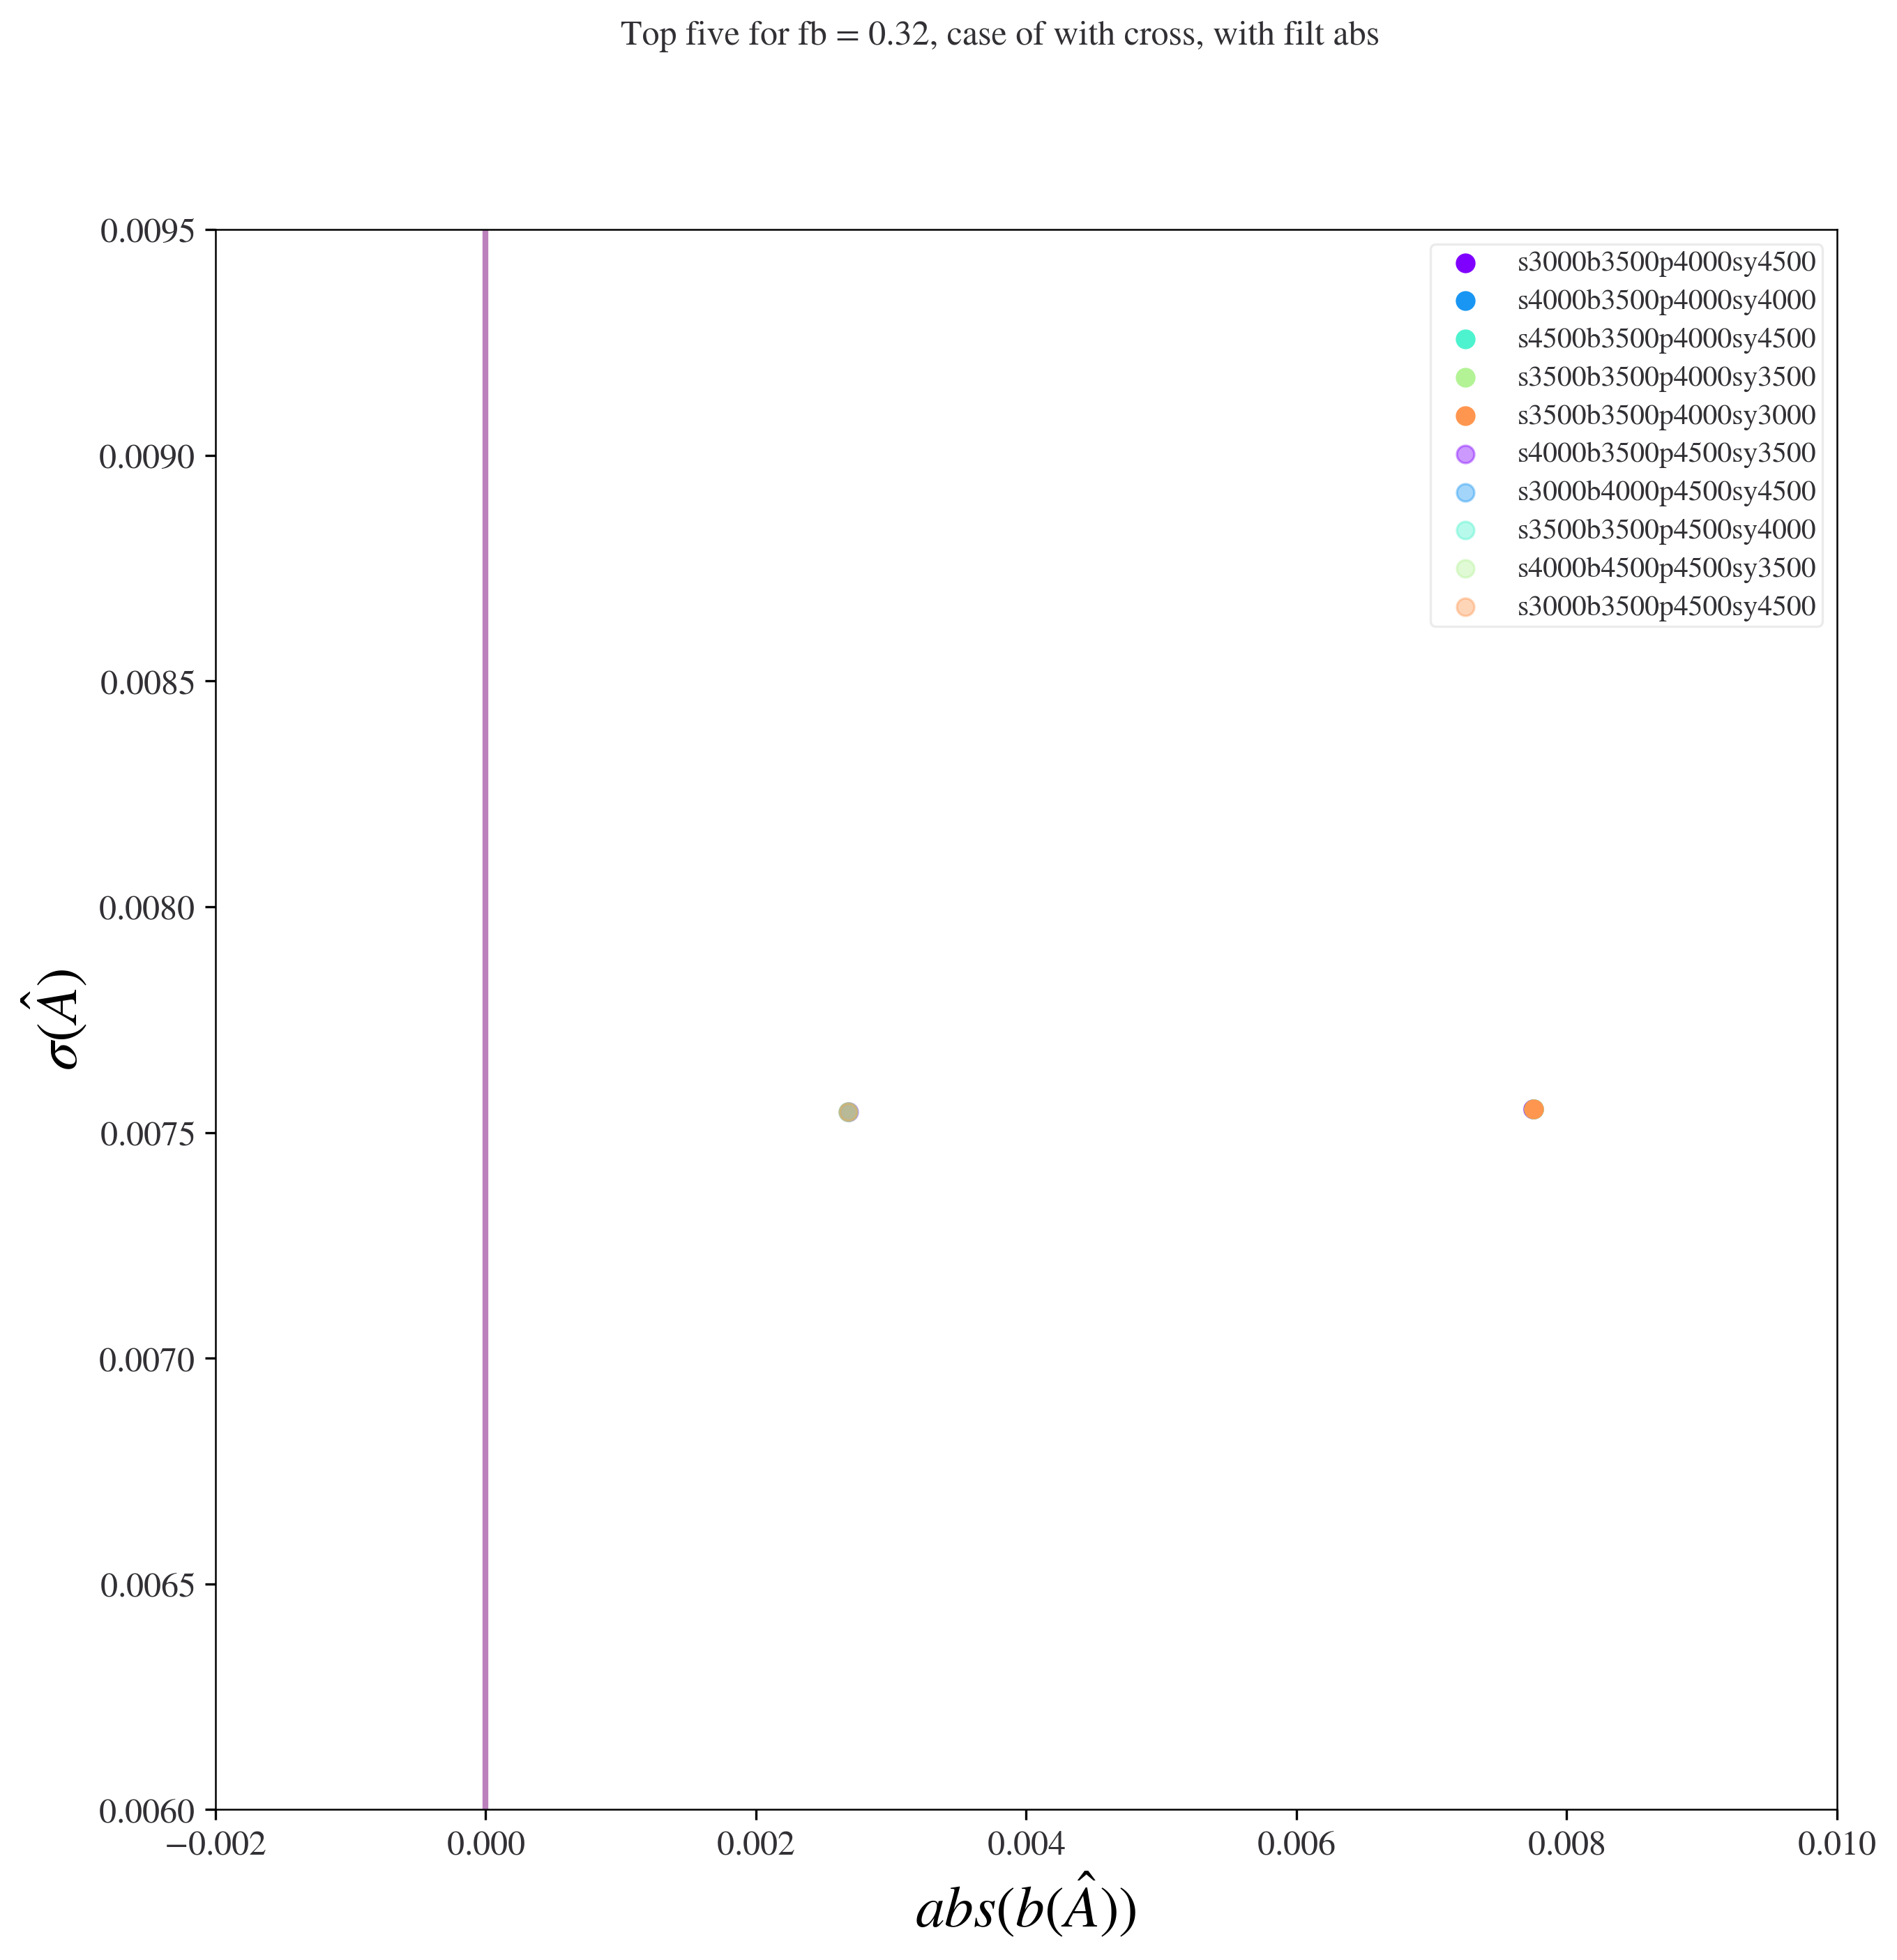

                      Name  Total Auto  Noise Auto  Bias Auto
119  s4500b3500p3500sy3500    0.000101    0.008079   0.005949
204  s4500b3500p3500sy4000    0.000101    0.008079   0.005949
172  s4500b3500p3500sy4500    0.000102    0.008179   0.005886
154  s3000b3500p3500sy4000    0.000102    0.008310   0.005706
70   s4500b4000p3500sy4000    0.000102    0.008101   0.006034
     Bias Auto  Noise Auto rtr  Bias Auto rtr
119   0.005949        1.177765       0.210474
204   0.005949        1.177765       0.210474
172   0.005886        1.192389       0.208253
154   0.005706        1.211383       0.201884
70    0.006034        1.180998       0.213468
s4500b3500p3500sy3500
0.008078937131231713 0.008078937131231713


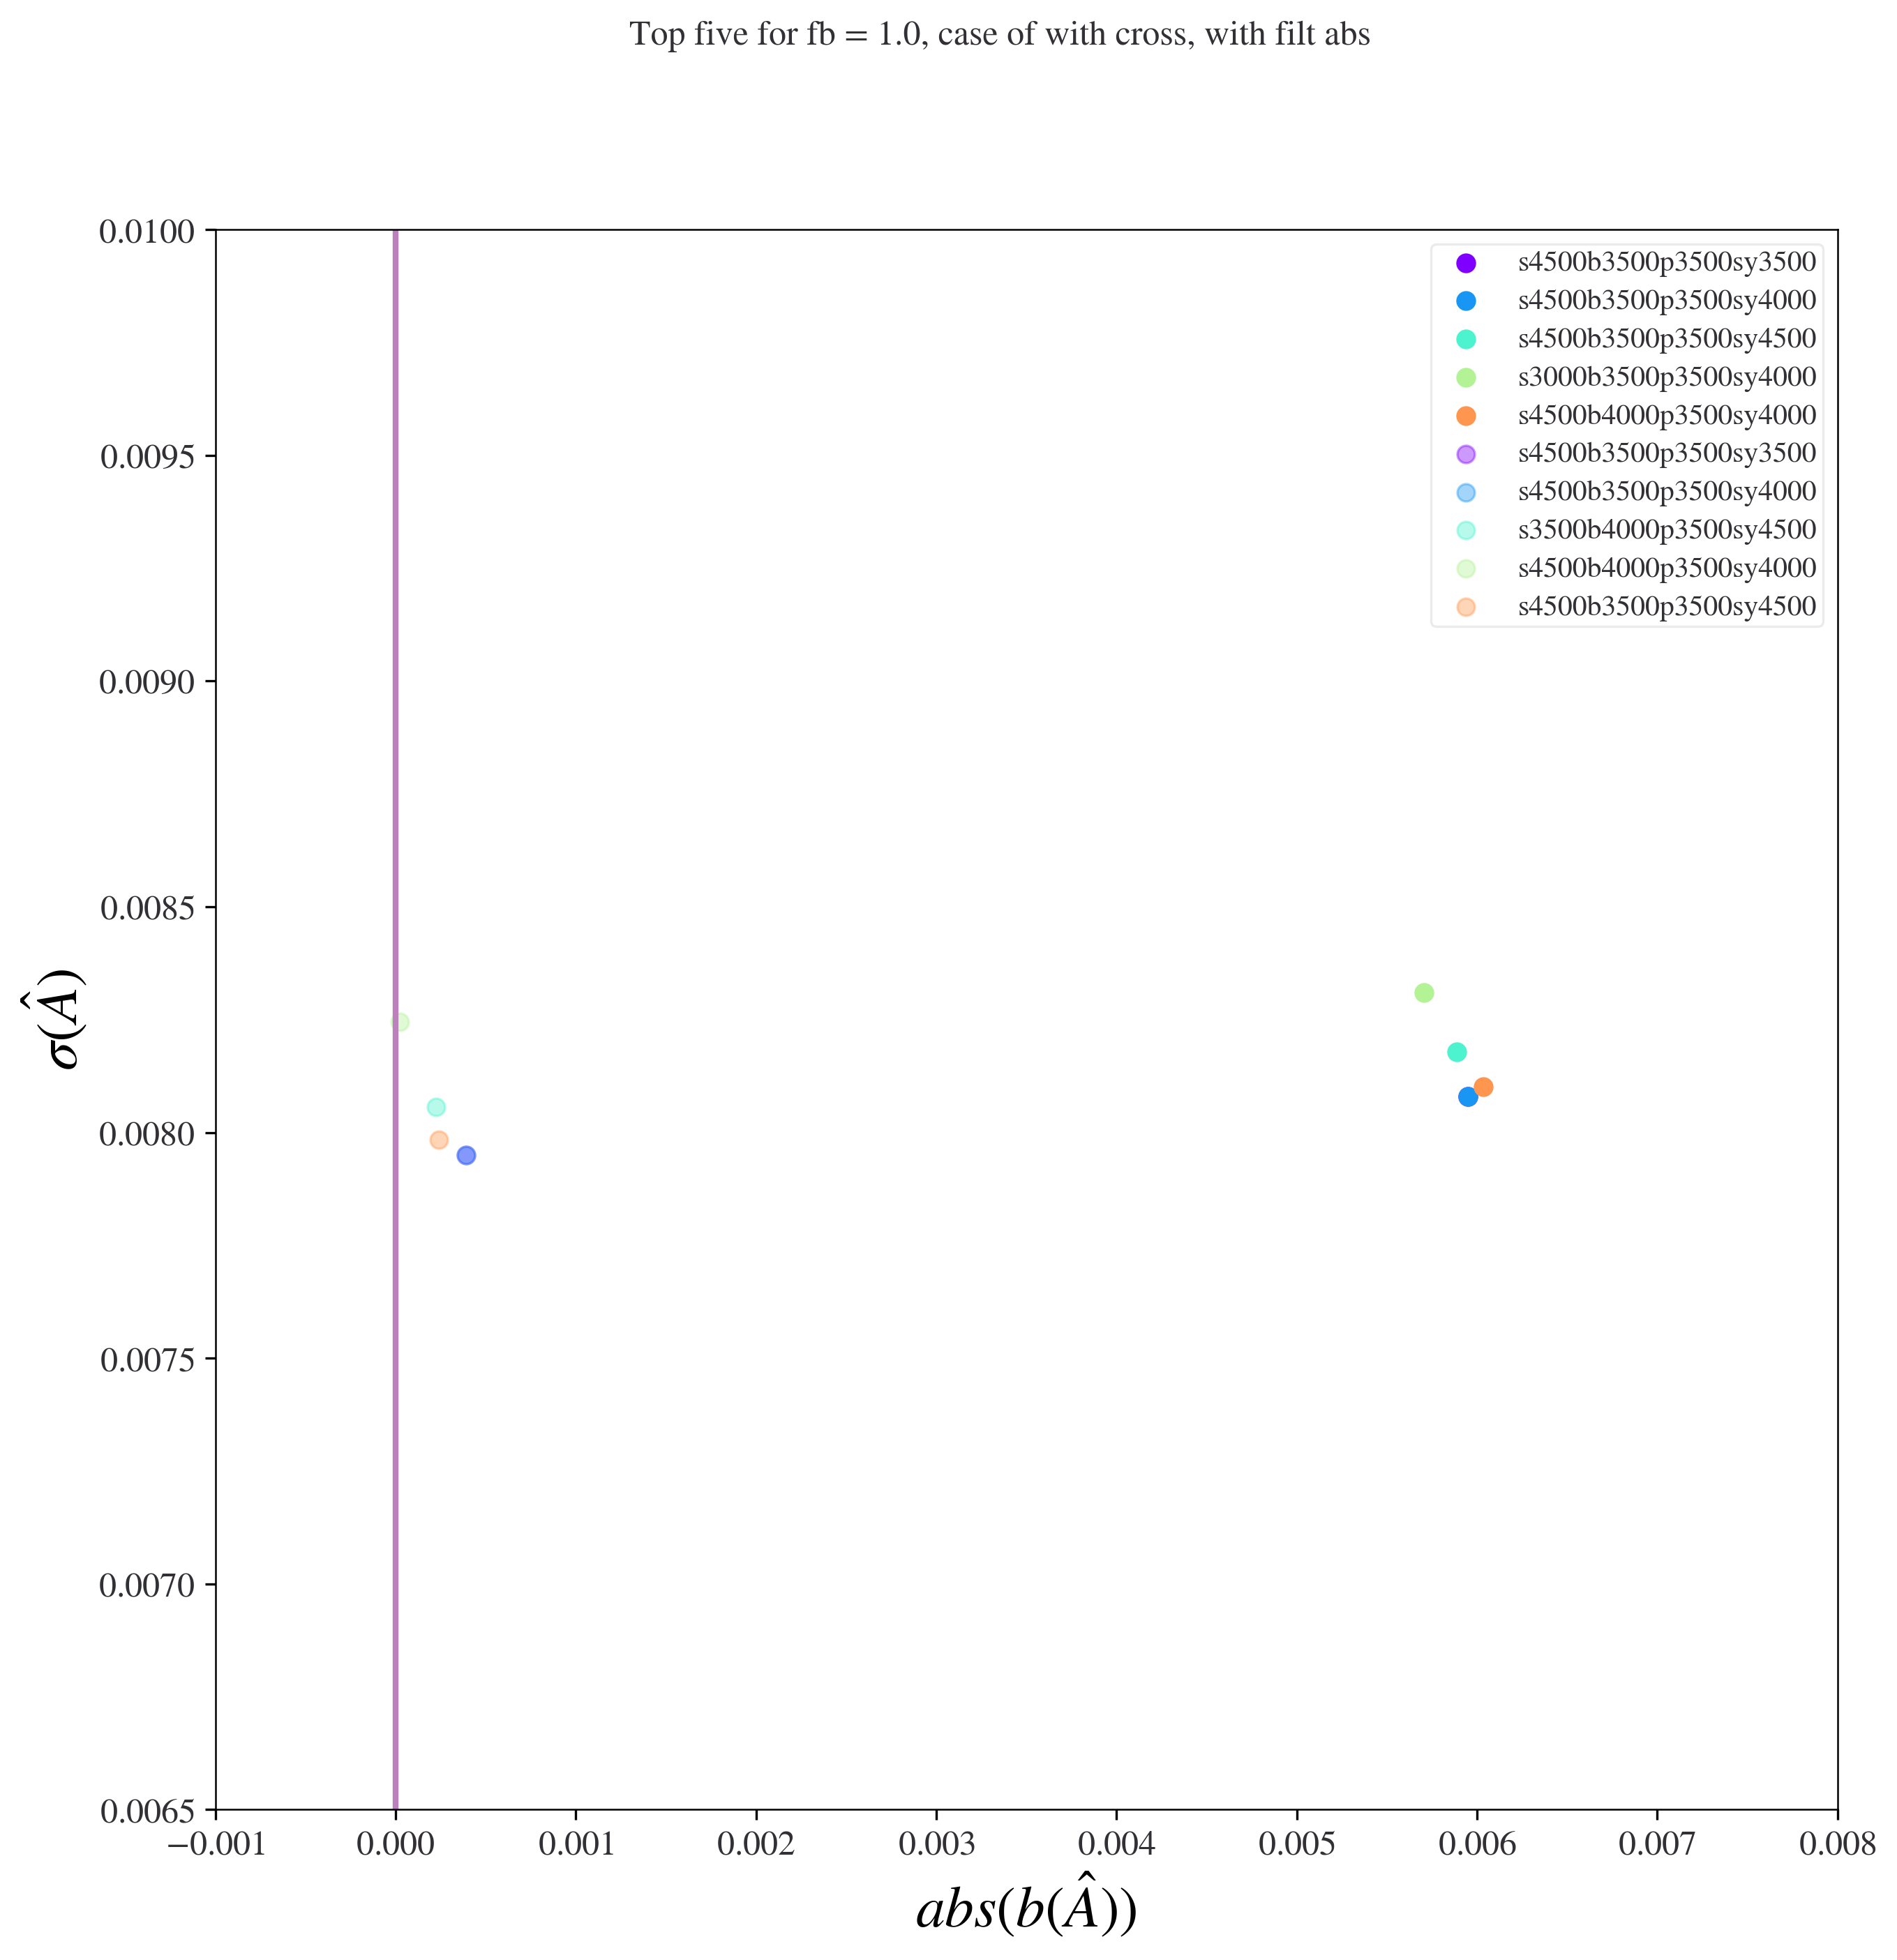

                      Name  Total Auto  Noise Auto  Bias Auto
95   s3000b4000p3500sy3500    0.000202    0.009515   0.005272
170  s4500b4500p3500sy3500    0.000205    0.009558   0.005335
254  s4000b3000p3500sy4500    0.000206    0.009653   0.005308
212  s3000b3500p3500sy3000    0.000209    0.009810   0.005316
58   s4500b3500p3500sy3000    0.000211    0.009732   0.005387
     Bias Auto  Noise Auto rtr  Bias Auto rtr
95    0.005272        1.387150       0.186509
170   0.005335        1.393365       0.188752
254   0.005308        1.407192       0.187803
212   0.005316        1.430069       0.188071
58    0.005387        1.418737       0.190601
s3000b4000p3500sy3500
0.00951522341616663 0.00951522341616663


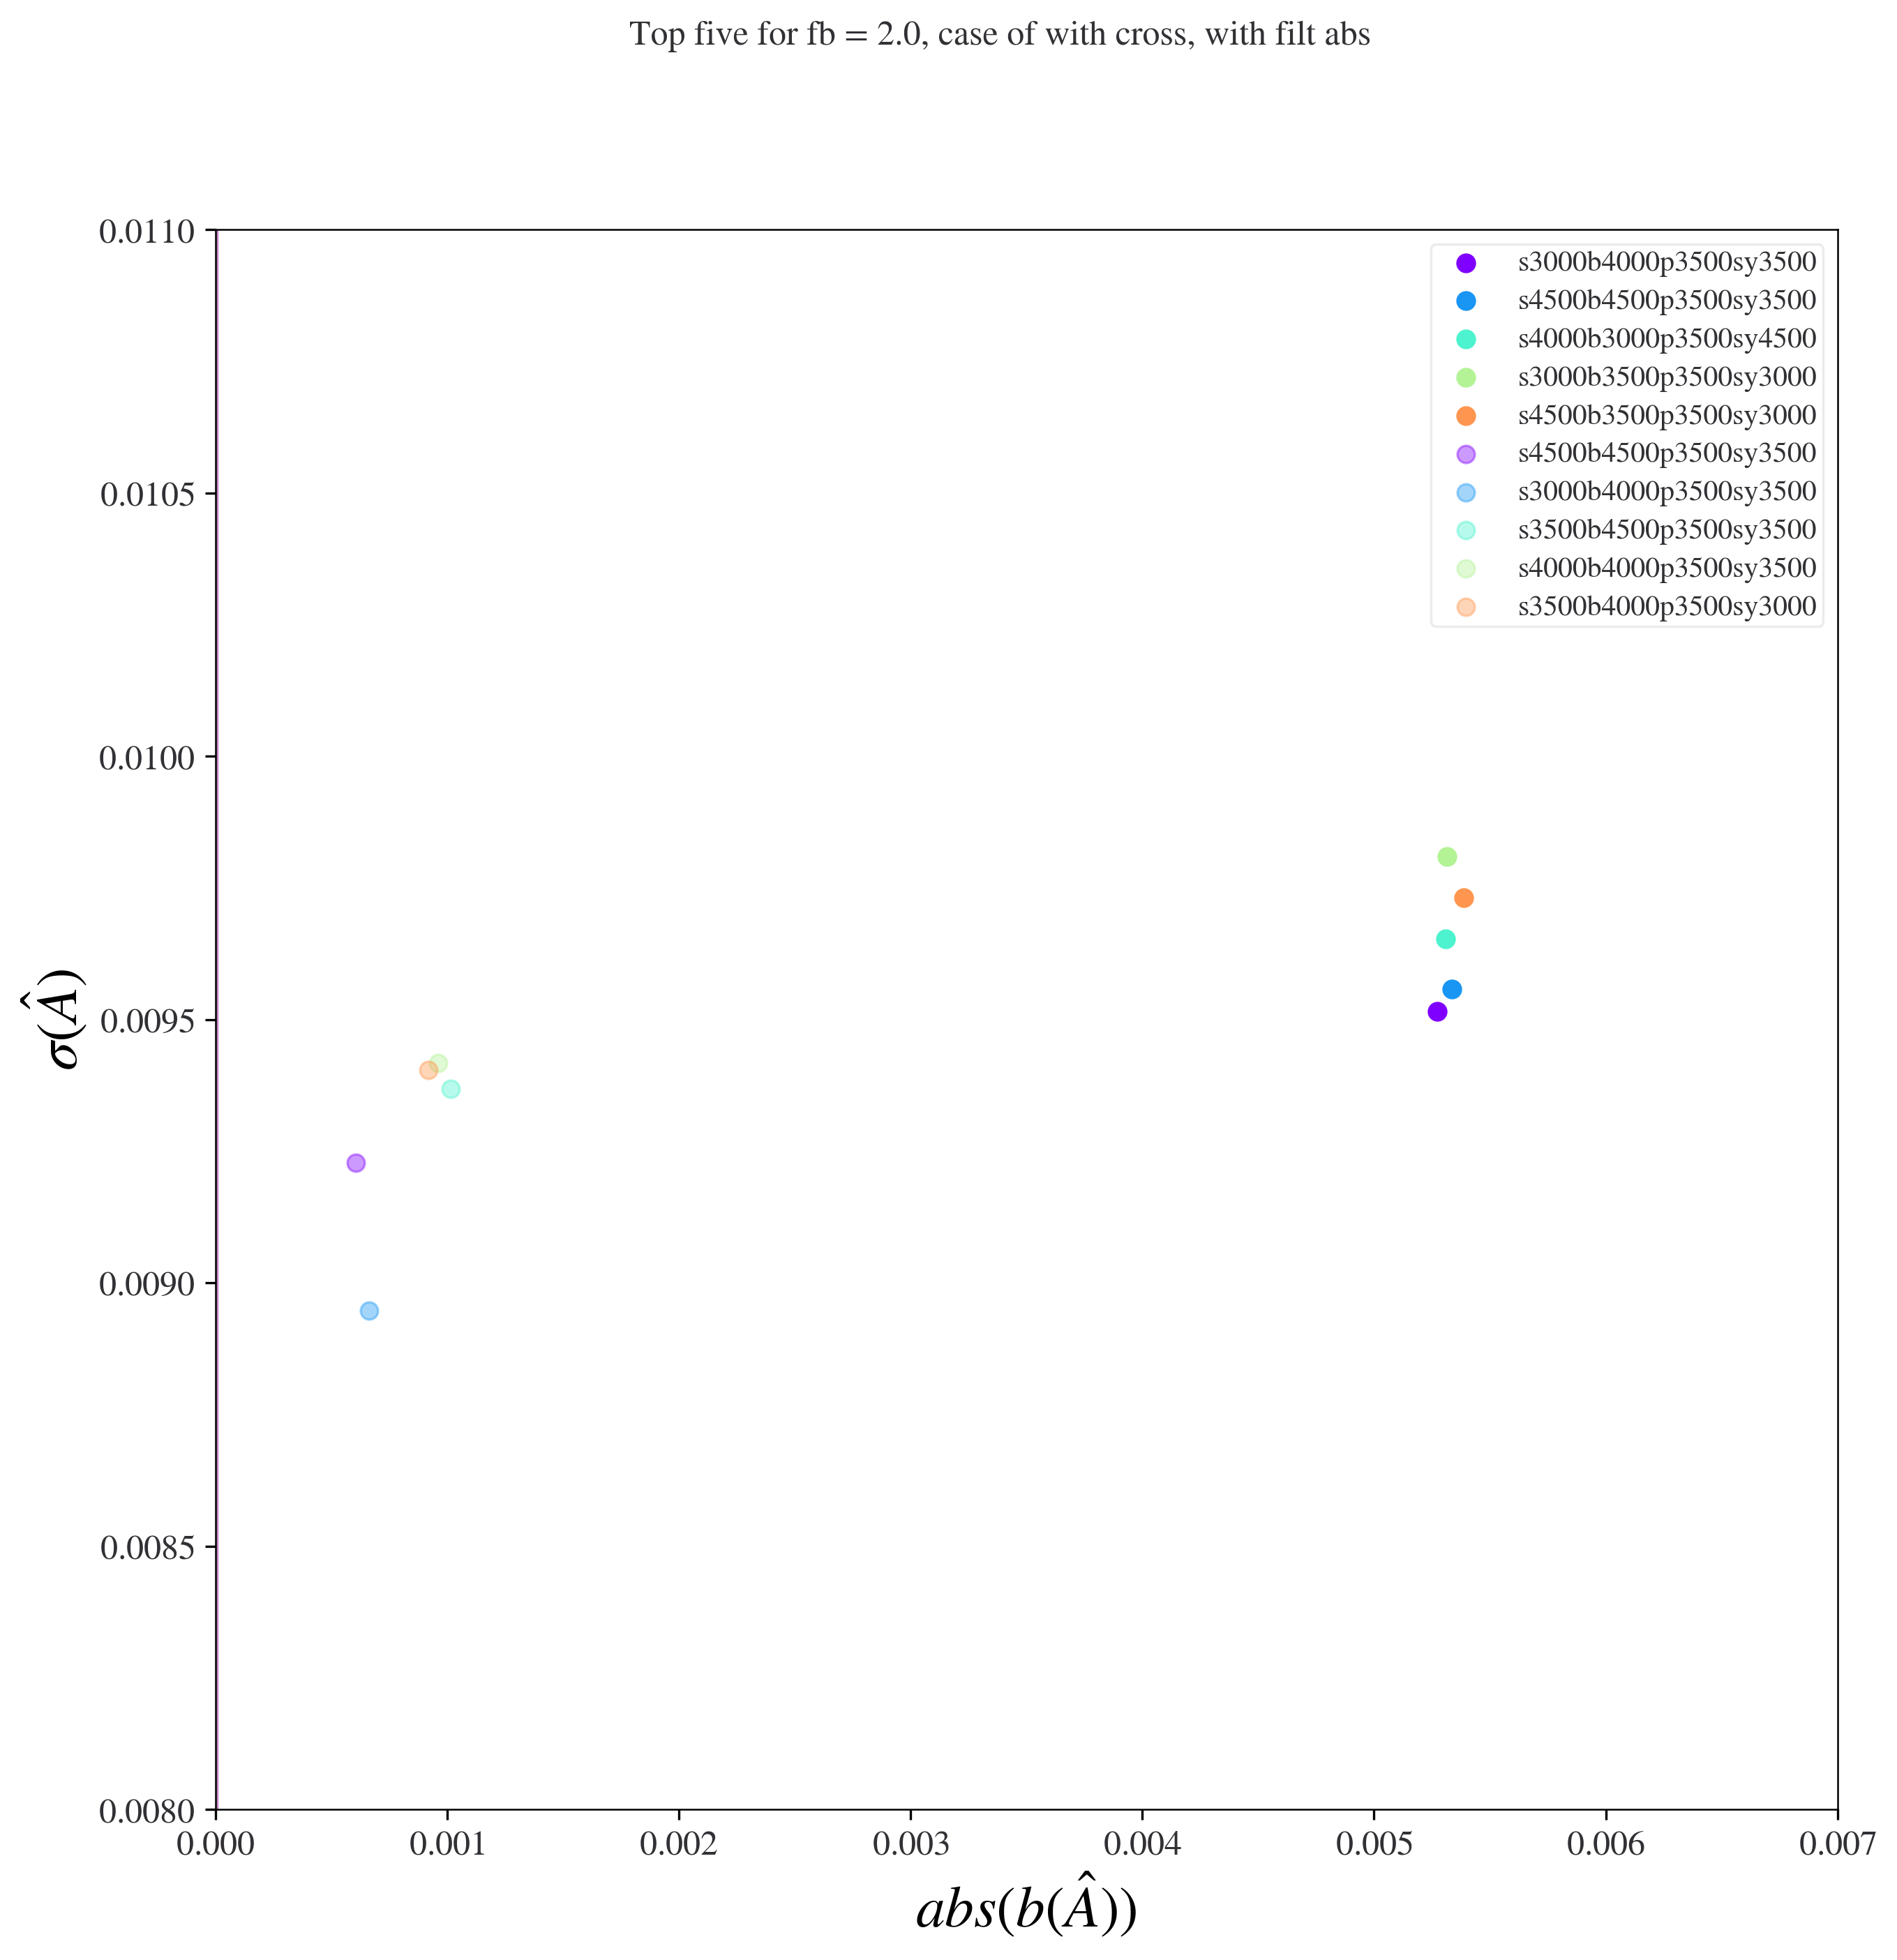

                      Name  Total Auto  Noise Auto  Bias Auto
165  s3000b3000p4000sy4500     0.00031    0.012959   0.003972
216  s3000b3500p4000sy4500     0.00031    0.012959   0.003972
31   s3000b3500p4000sy3000     0.00031    0.012959   0.003972
235  s3000b4000p4000sy4500     0.00031    0.012959   0.003972
221  s3000b3500p4000sy4000     0.00031    0.012959   0.003972
     Bias Auto  Noise Auto rtr  Bias Auto rtr
165   0.003972        1.889146       0.140519
216   0.003972        1.889146       0.140519
31    0.003972        1.889146       0.140519
235   0.003972        1.889146       0.140519
221   0.003972        1.889146       0.140519
s3000b3000p4000sy4500
0.012958691722327732 0.012958691722327732


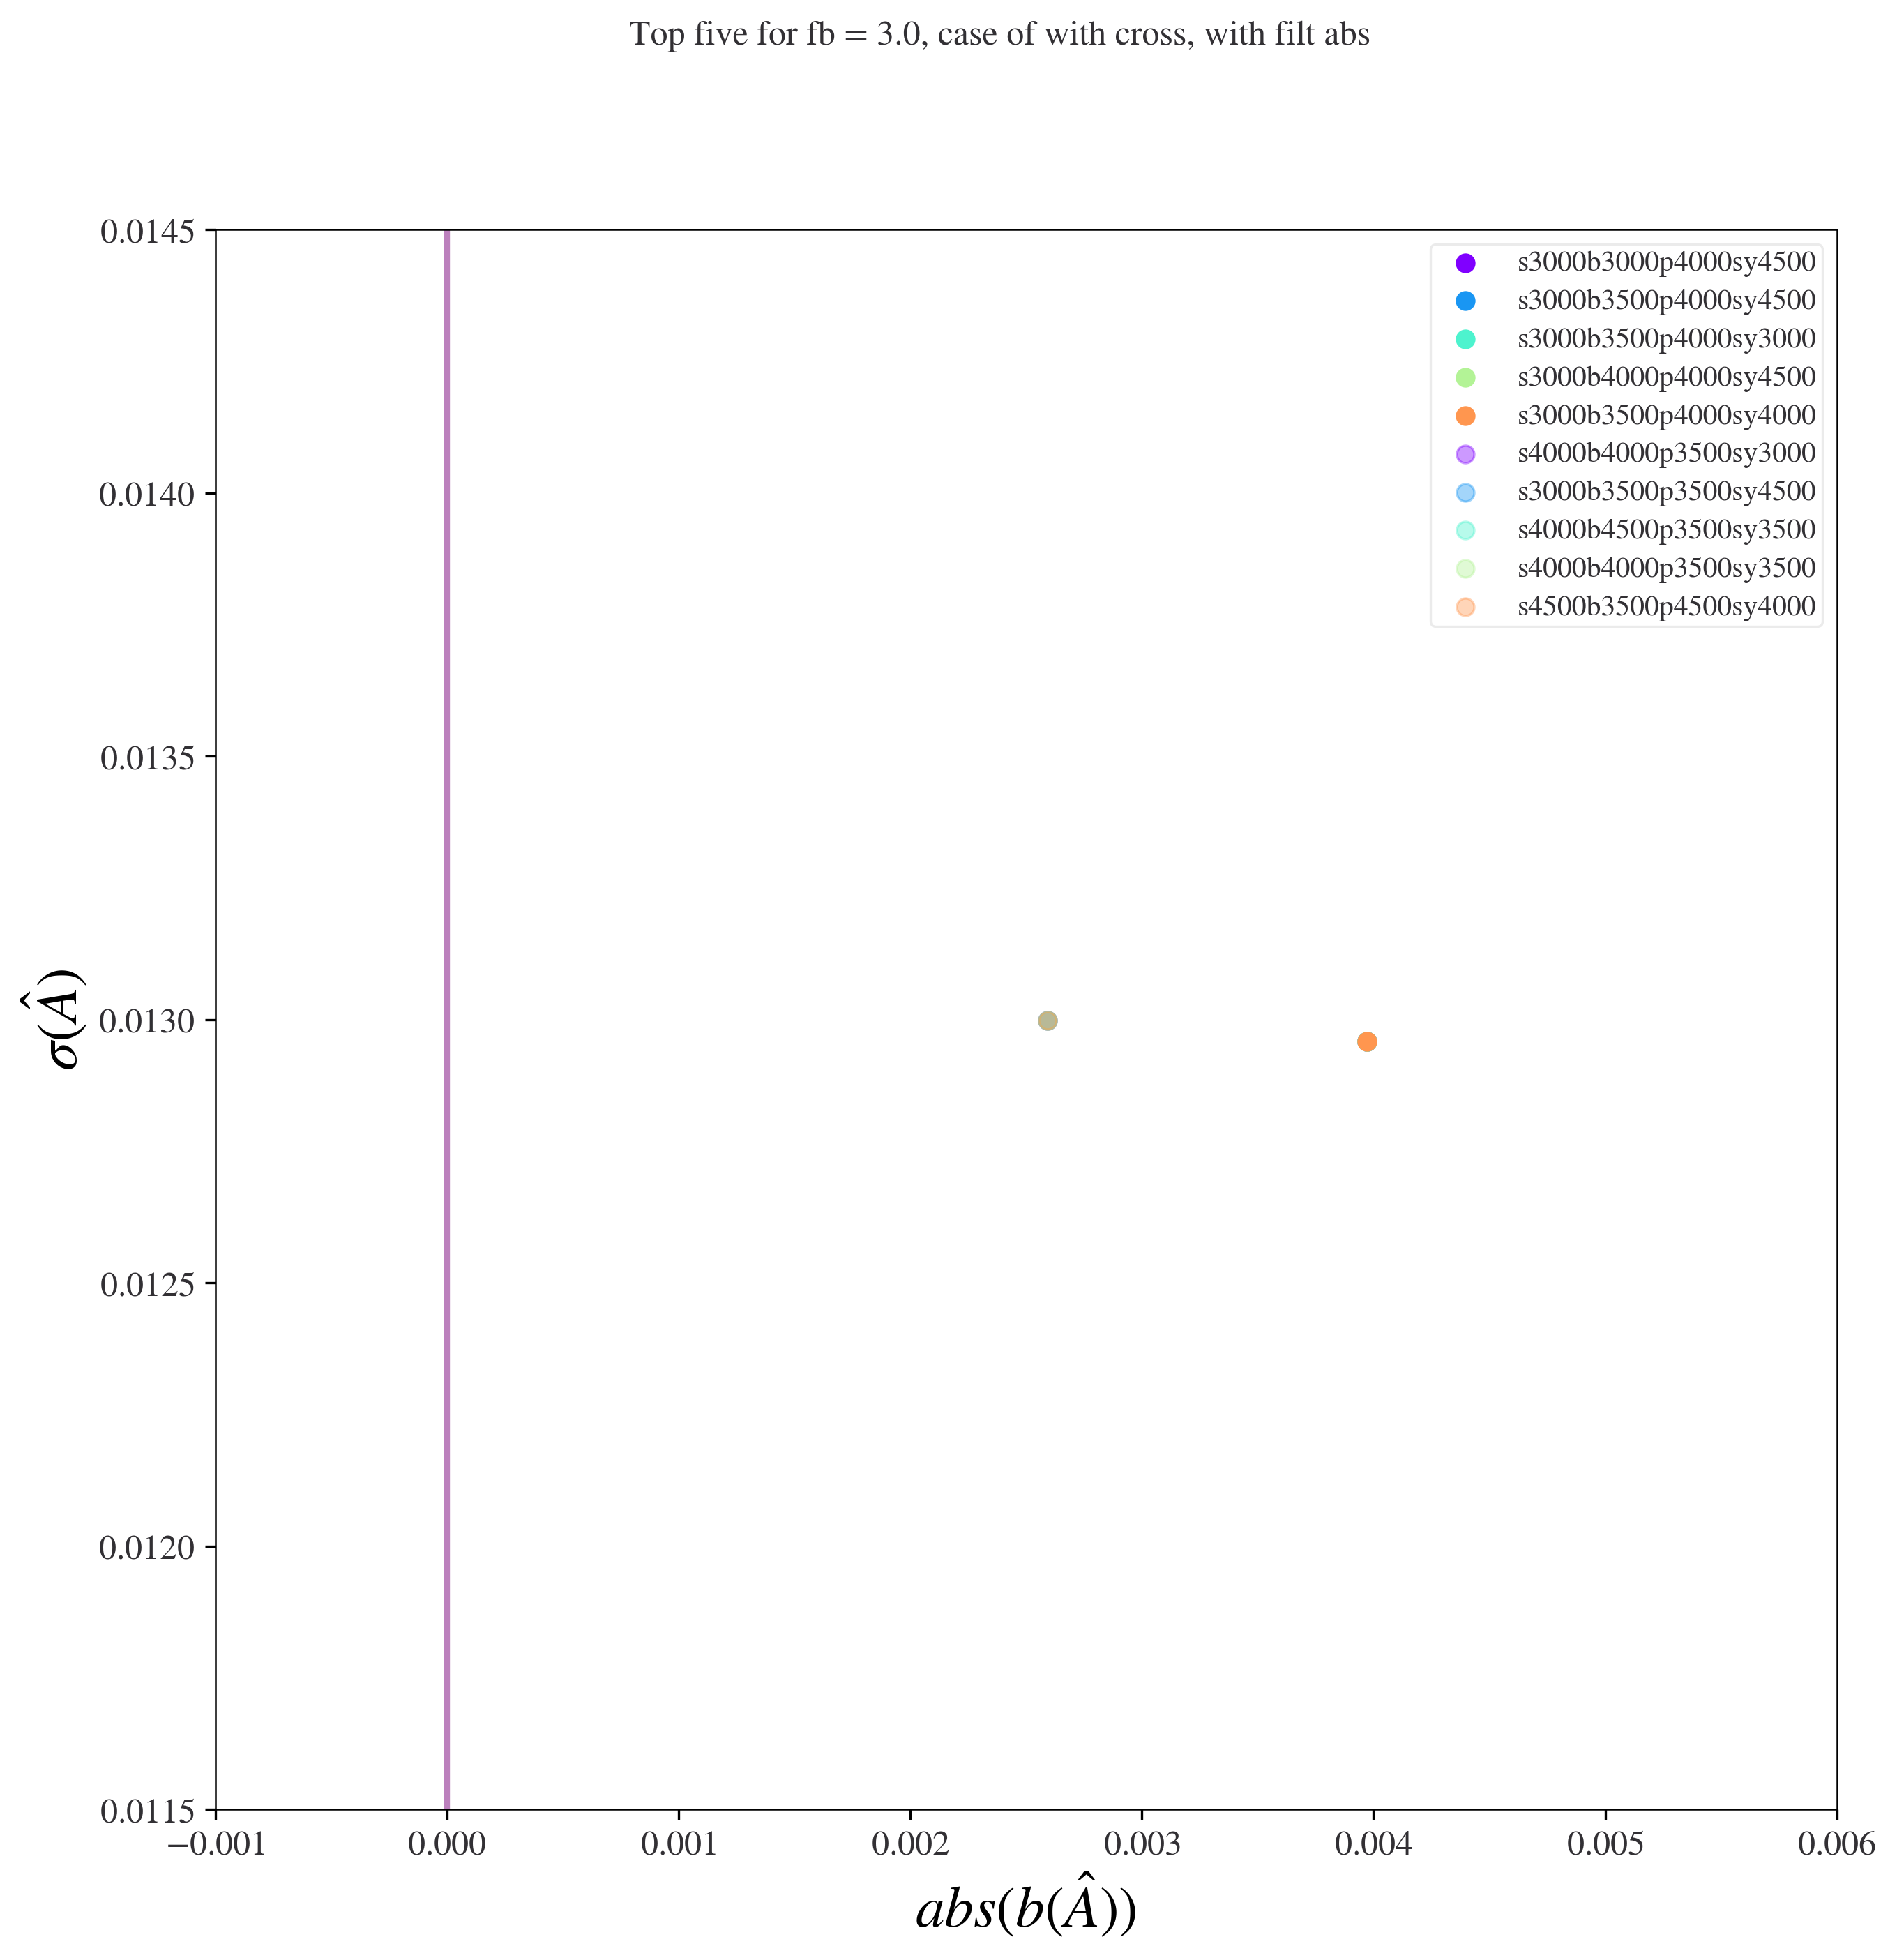

                      Name  Total Auto  Noise Auto  Bias Auto
221  s3000b3500p4000sy4000    0.000417    0.013373   0.003860
31   s3000b3500p4000sy3000    0.000422    0.013784   0.003804
135  s3000b4500p4000sy4500    0.000422    0.013806   0.003800
160  s3000b3500p4000sy3500    0.000422    0.013955   0.003768
165  s3000b3000p4000sy4500    0.000422    0.013955   0.003768
     Bias Auto  Noise Auto rtr  Bias Auto rtr
221   0.003860        1.949505       0.136547
31    0.003804        2.009494       0.134580
135   0.003800        2.012682       0.134436
160   0.003768        2.034453       0.133305
165   0.003768        2.034453       0.133305
s3000b3500p4000sy4000
0.01337272737155571 0.01337272737155571


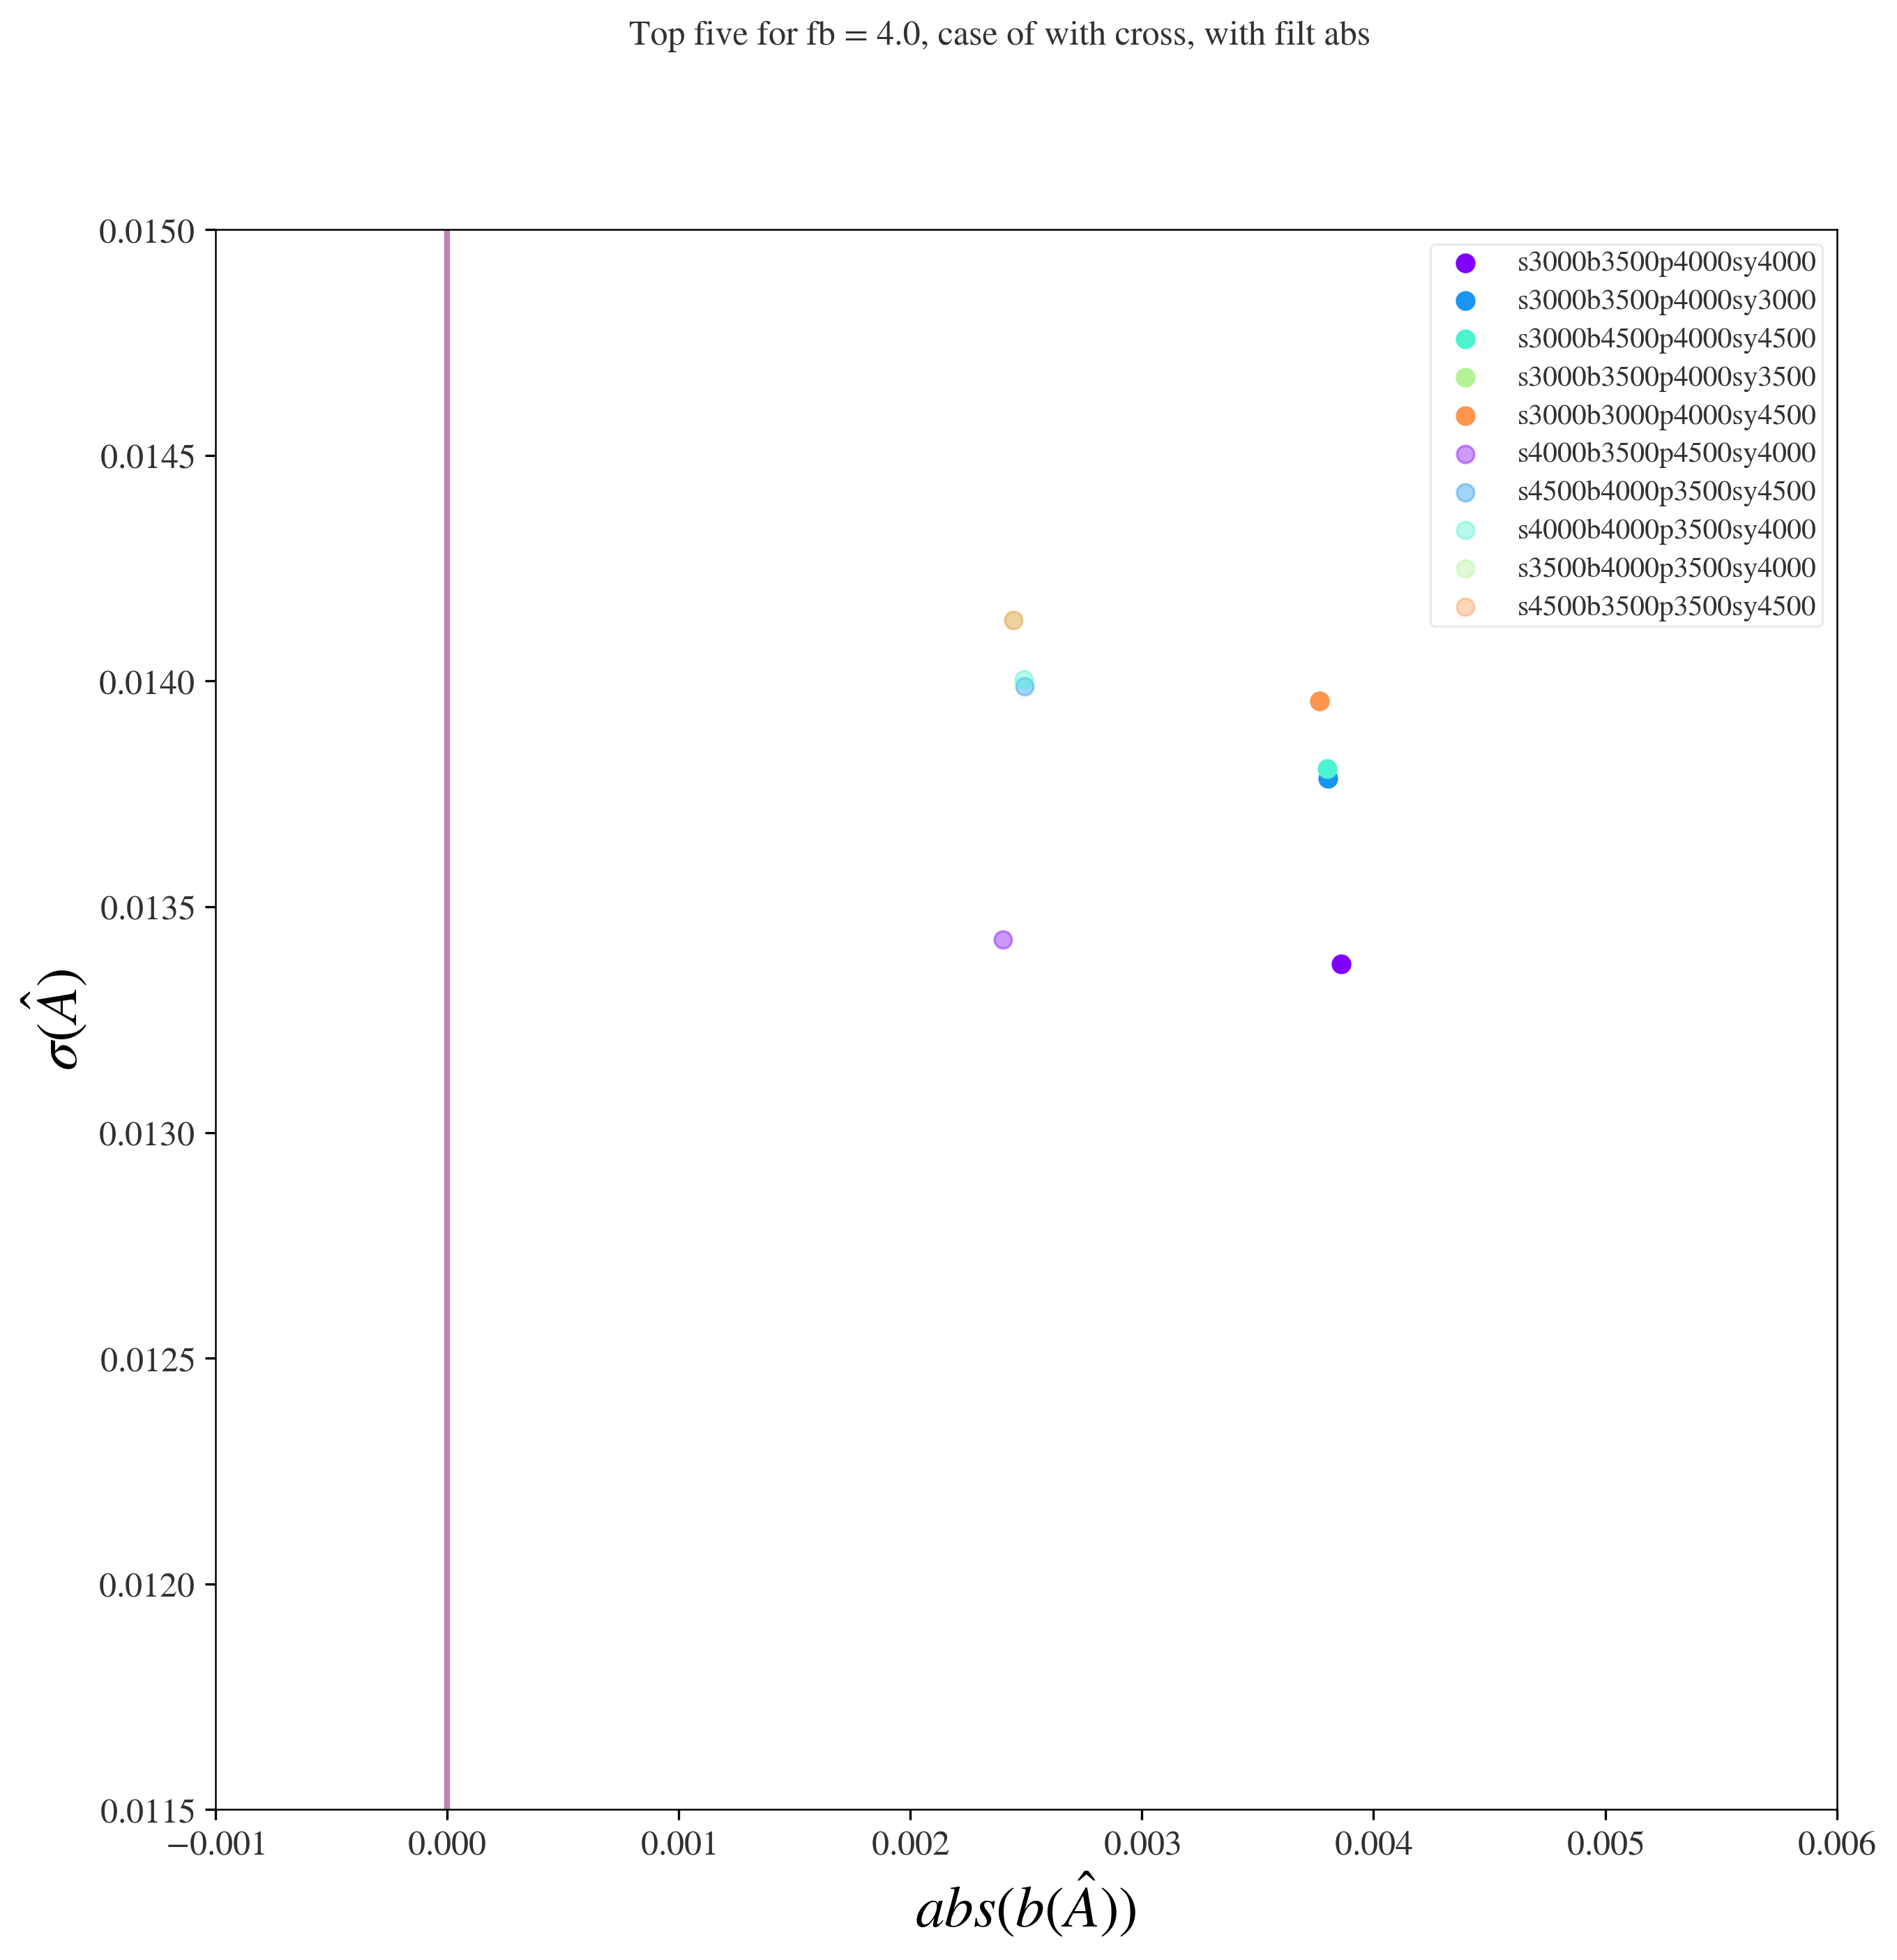

In [472]:
ns = np.array([])
bs = np.array([])
fs = np.array([])

ns_no_filt = np.array([])
bs_no_filt = np.array([])
fs_no_filt = np.array([])


all_best_direcs = []

names_W = list(names)+['$W_L$']
names_W

all_relevant_directorties_dict = {}

for ii, fb in enumerate(fbs):
    d = make_table(resultspath, all_lmaxes_directories, estimators, fb = fb, crosstag = crosstag, optimtag = optimtag, include_estimators = False, extradir = inv_variance_dir)
    
    d_no_filt = make_table(resultspath, all_lmaxes_directories, estimators, fb = fb, crosstag = crosstag, optimtag = '', include_estimators = False, extradir = inv_variance_dir)
    
    
    dref = make_table(resultspath, all_lmaxes_directories, estimators, fb = fb, crosstag = crosstag, optimtag = optimtag, all_ref = all_ref,
                      include_estimators = False, extradir = inv_variance_dir, include_ref = True)

    Ntop = 5
    
    print(d.sort_values(by = 'Total Auto').head(Ntop))
    
    print(dref.sort_values(by = 'Total Auto').head(Ntop).iloc[:5, 3:])

    top5 = list(d.sort_values(by = 'Total Auto').head(Ntop).iloc[:Ntop, 0])
    all_relevant_directorties_dict[fb] = top5
    
    top5_no_filt = list(d_no_filt.sort_values(by = 'Total Auto').head(Ntop).iloc[:Ntop, 0])
    
    direc = d.sort_values(by = 'Total Auto').head(1).iloc[0, 0]
    print(direc)
    lmax_directory = direc
    
    all_best_direcs += [direc]
    
    kk, theta, ells, biases, noises, w, x = get_info(pathlib.Path(direc), resultspath, fb = fb, invvardir = inv_variance_dir)
    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, (biases), noises, nocrosses = nocross)
    
    if optim:
        filtbiases = Optimizerkk.filter_(abs(Optimizerkk.biases_selected), sigma = 1.5)
        Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, Optimizerkk.ells_selected, Optimizerkk.theory_selected, Optimizerkk.theta_selected, filtbiases, Optimizerkk.noises_selected)              
                  
                  
    resultkk = best.Res()
    f, n, b = fnb_getter(Optimizerkk, fb_val = fb, invvar = invvariance)
    resultkk.load_all(resultspath/lmax_directory/inv_variance_dir, f'auto_fb_{fb}{crosstag}')
    
    results_array = np.load(resultspath/direc/inv_variance_dir/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
    ftemp, ntemp, btemp = results_array
    
    print(ntemp, n(resultkk.x))
    
    ns = np.append(ns, ntemp)
    bs = np.append(bs, btemp)
    fs = np.append(fs, ftemp)
    
    smallns = []
    smallbs = []
    
    smallns_no_filt = []
    smallbs_no_filt = []
    for temp_lmax_directory, temp_lmax_directory_no_filt in zip(top5, top5_no_filt):
        results_array = np.load(resultspath/temp_lmax_directory/inv_variance_dir/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
        ftemp, ntemp, btemp = results_array
        
        smallns += [ntemp]
        smallbs += [btemp]
        
        results_array = np.load(resultspath/temp_lmax_directory/inv_variance_dir/f'alens_{fb}{crosstag}.npy')[:, 0]
        ftemp, ntemp, btemp = results_array
        
        smallns_no_filt += [ntemp]
        smallbs_no_filt += [btemp]
        
    smallbs = np.array(smallbs)
    smallns = np.array(smallns)
    
    smallbs_no_filt = np.array(smallbs_no_filt)
    smallns_no_filt = np.array(smallns_no_filt)
        
    fig, ax = plt.subplots(figsize = (10, 10))
    fbname = np.round(np.sqrt(fb), 2)
    fig.suptitle(f'Top five for fb = {fbname}, case of {precisetitle}')
    ax.set_ylabel('$\\sigma(\hat{A})$', size = 20)
    ax.set_xlabel('$abs(b(\hat{A}))$', size = 20)
    for i, c in enumerate(zip(abs(smallbs), smallns)):
        b, n = c
        ax.scatter(b, n, color = colors_plotting[i], label = top5[i])
        
    for i, c in enumerate(zip(abs(smallbs_no_filt), smallns_no_filt)):
        b, n = c
        ax.scatter(b, n, color = colors_plotting[i], label = top5_no_filt[i], alpha = 0.4)
        
    ax.legend()
    ax.axvline(0., ymin = 0, ymax = 1)
    fbname = np.round(np.sqrt(fb), 2)
    fig.savefig(output_plots/f'top5_for_{fbname}.png', dpi = 300)
    plt.show()  


### Plots top 5

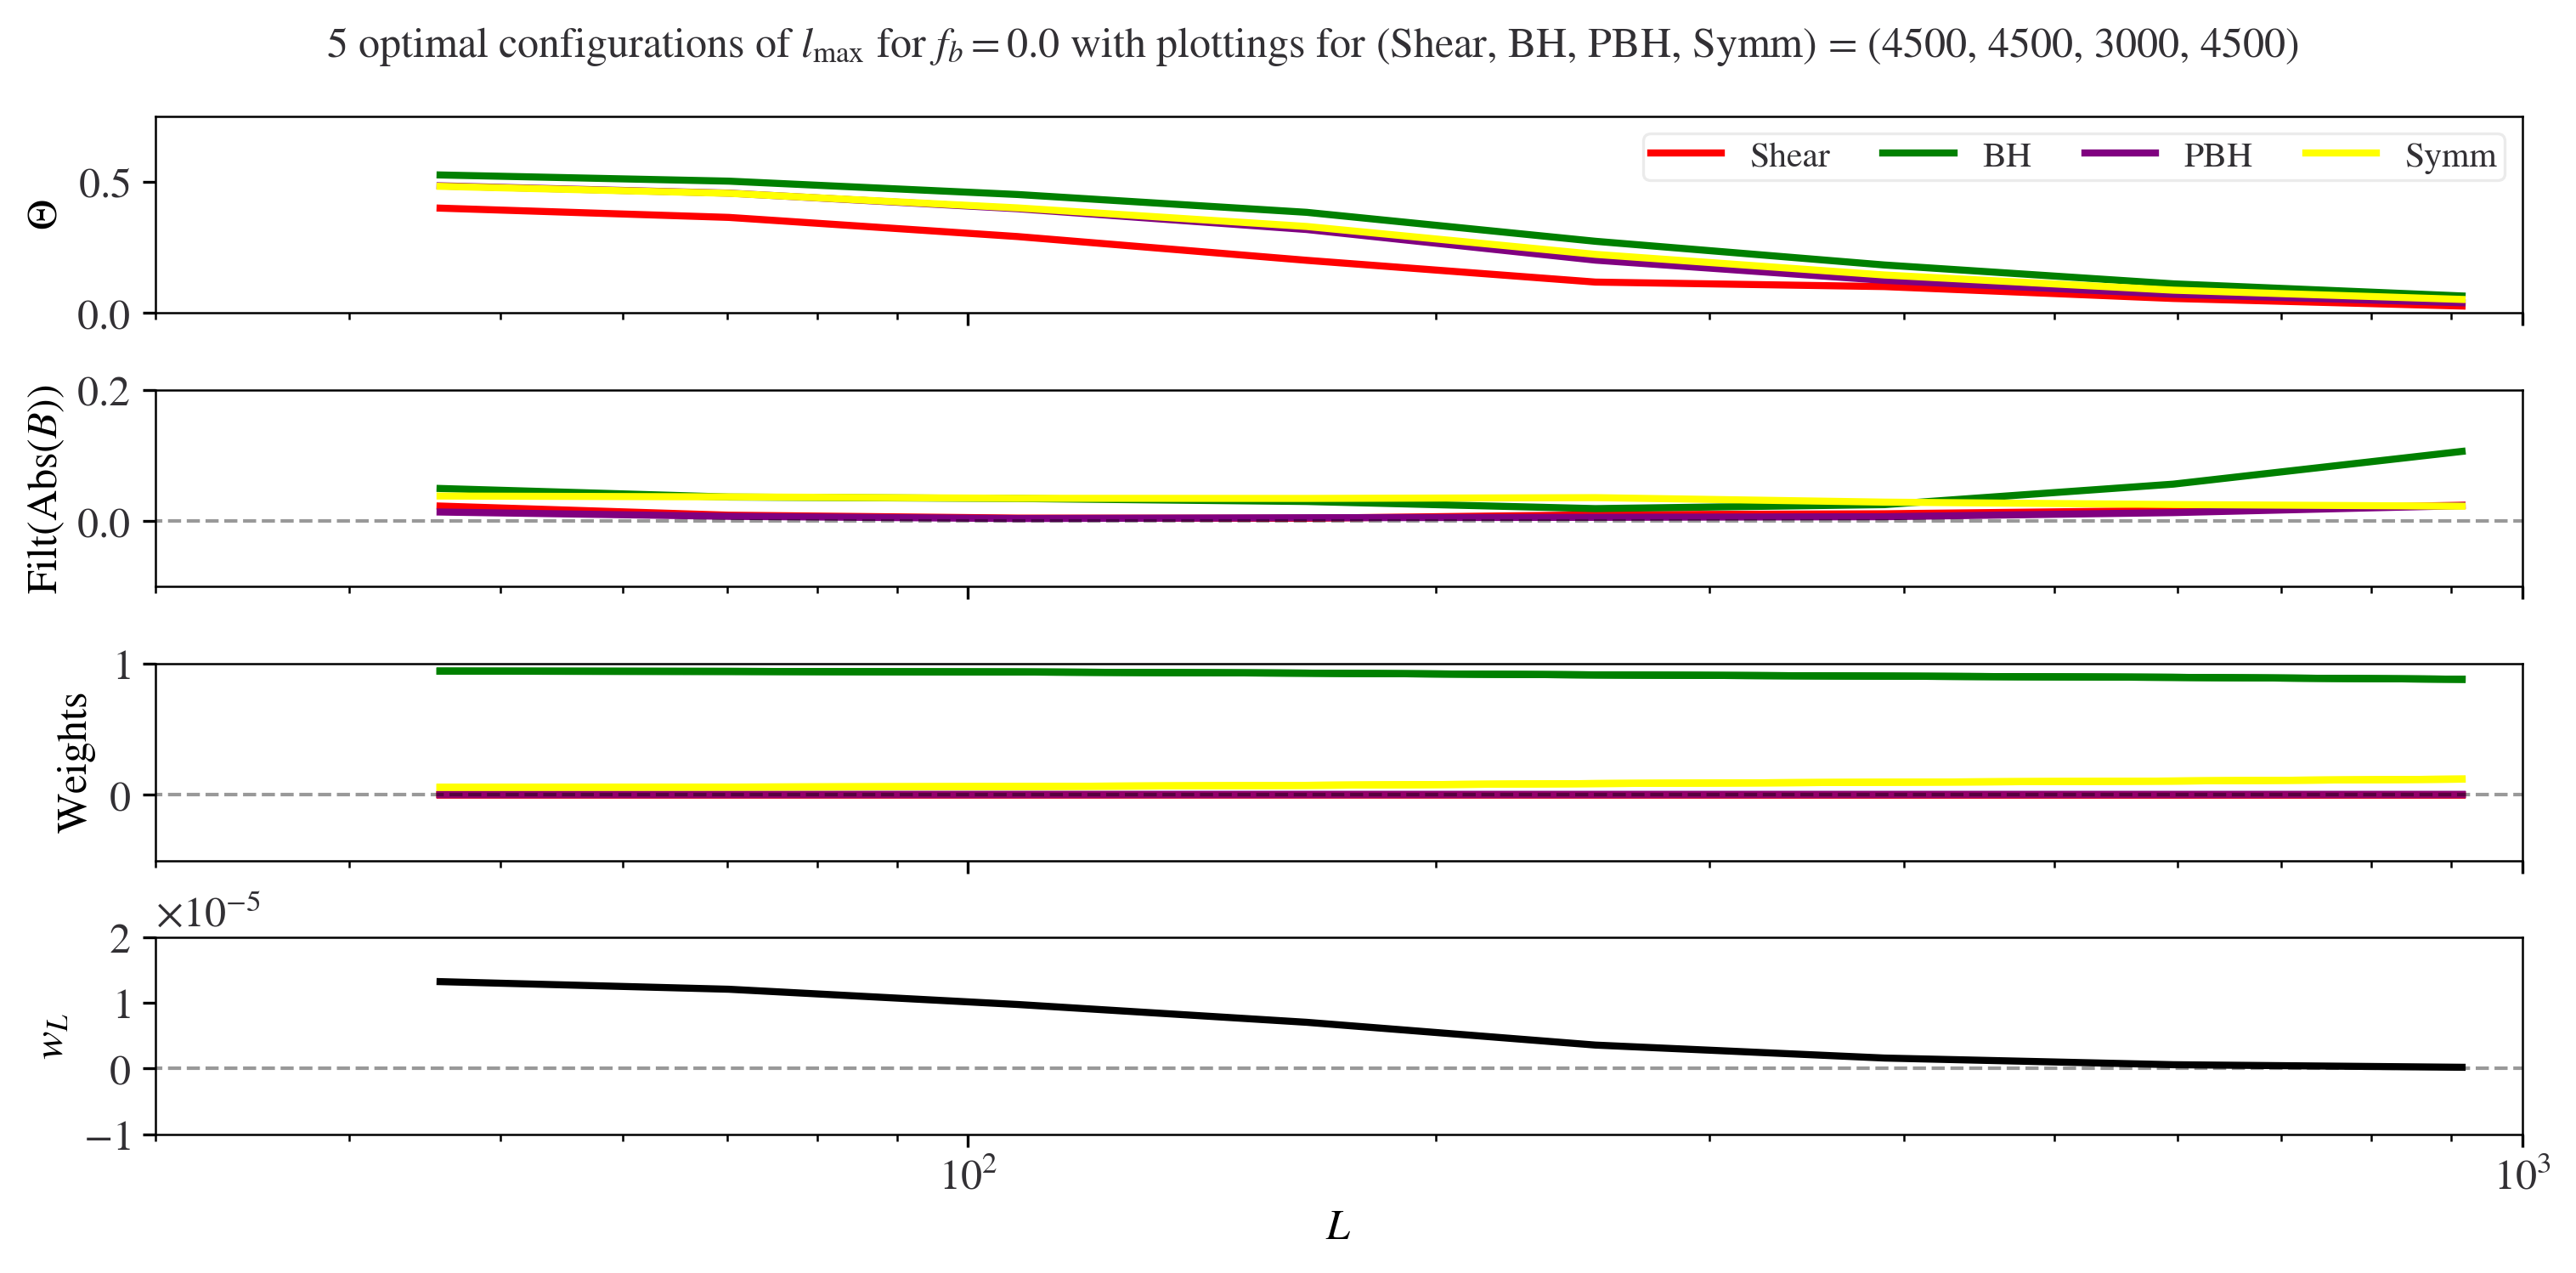

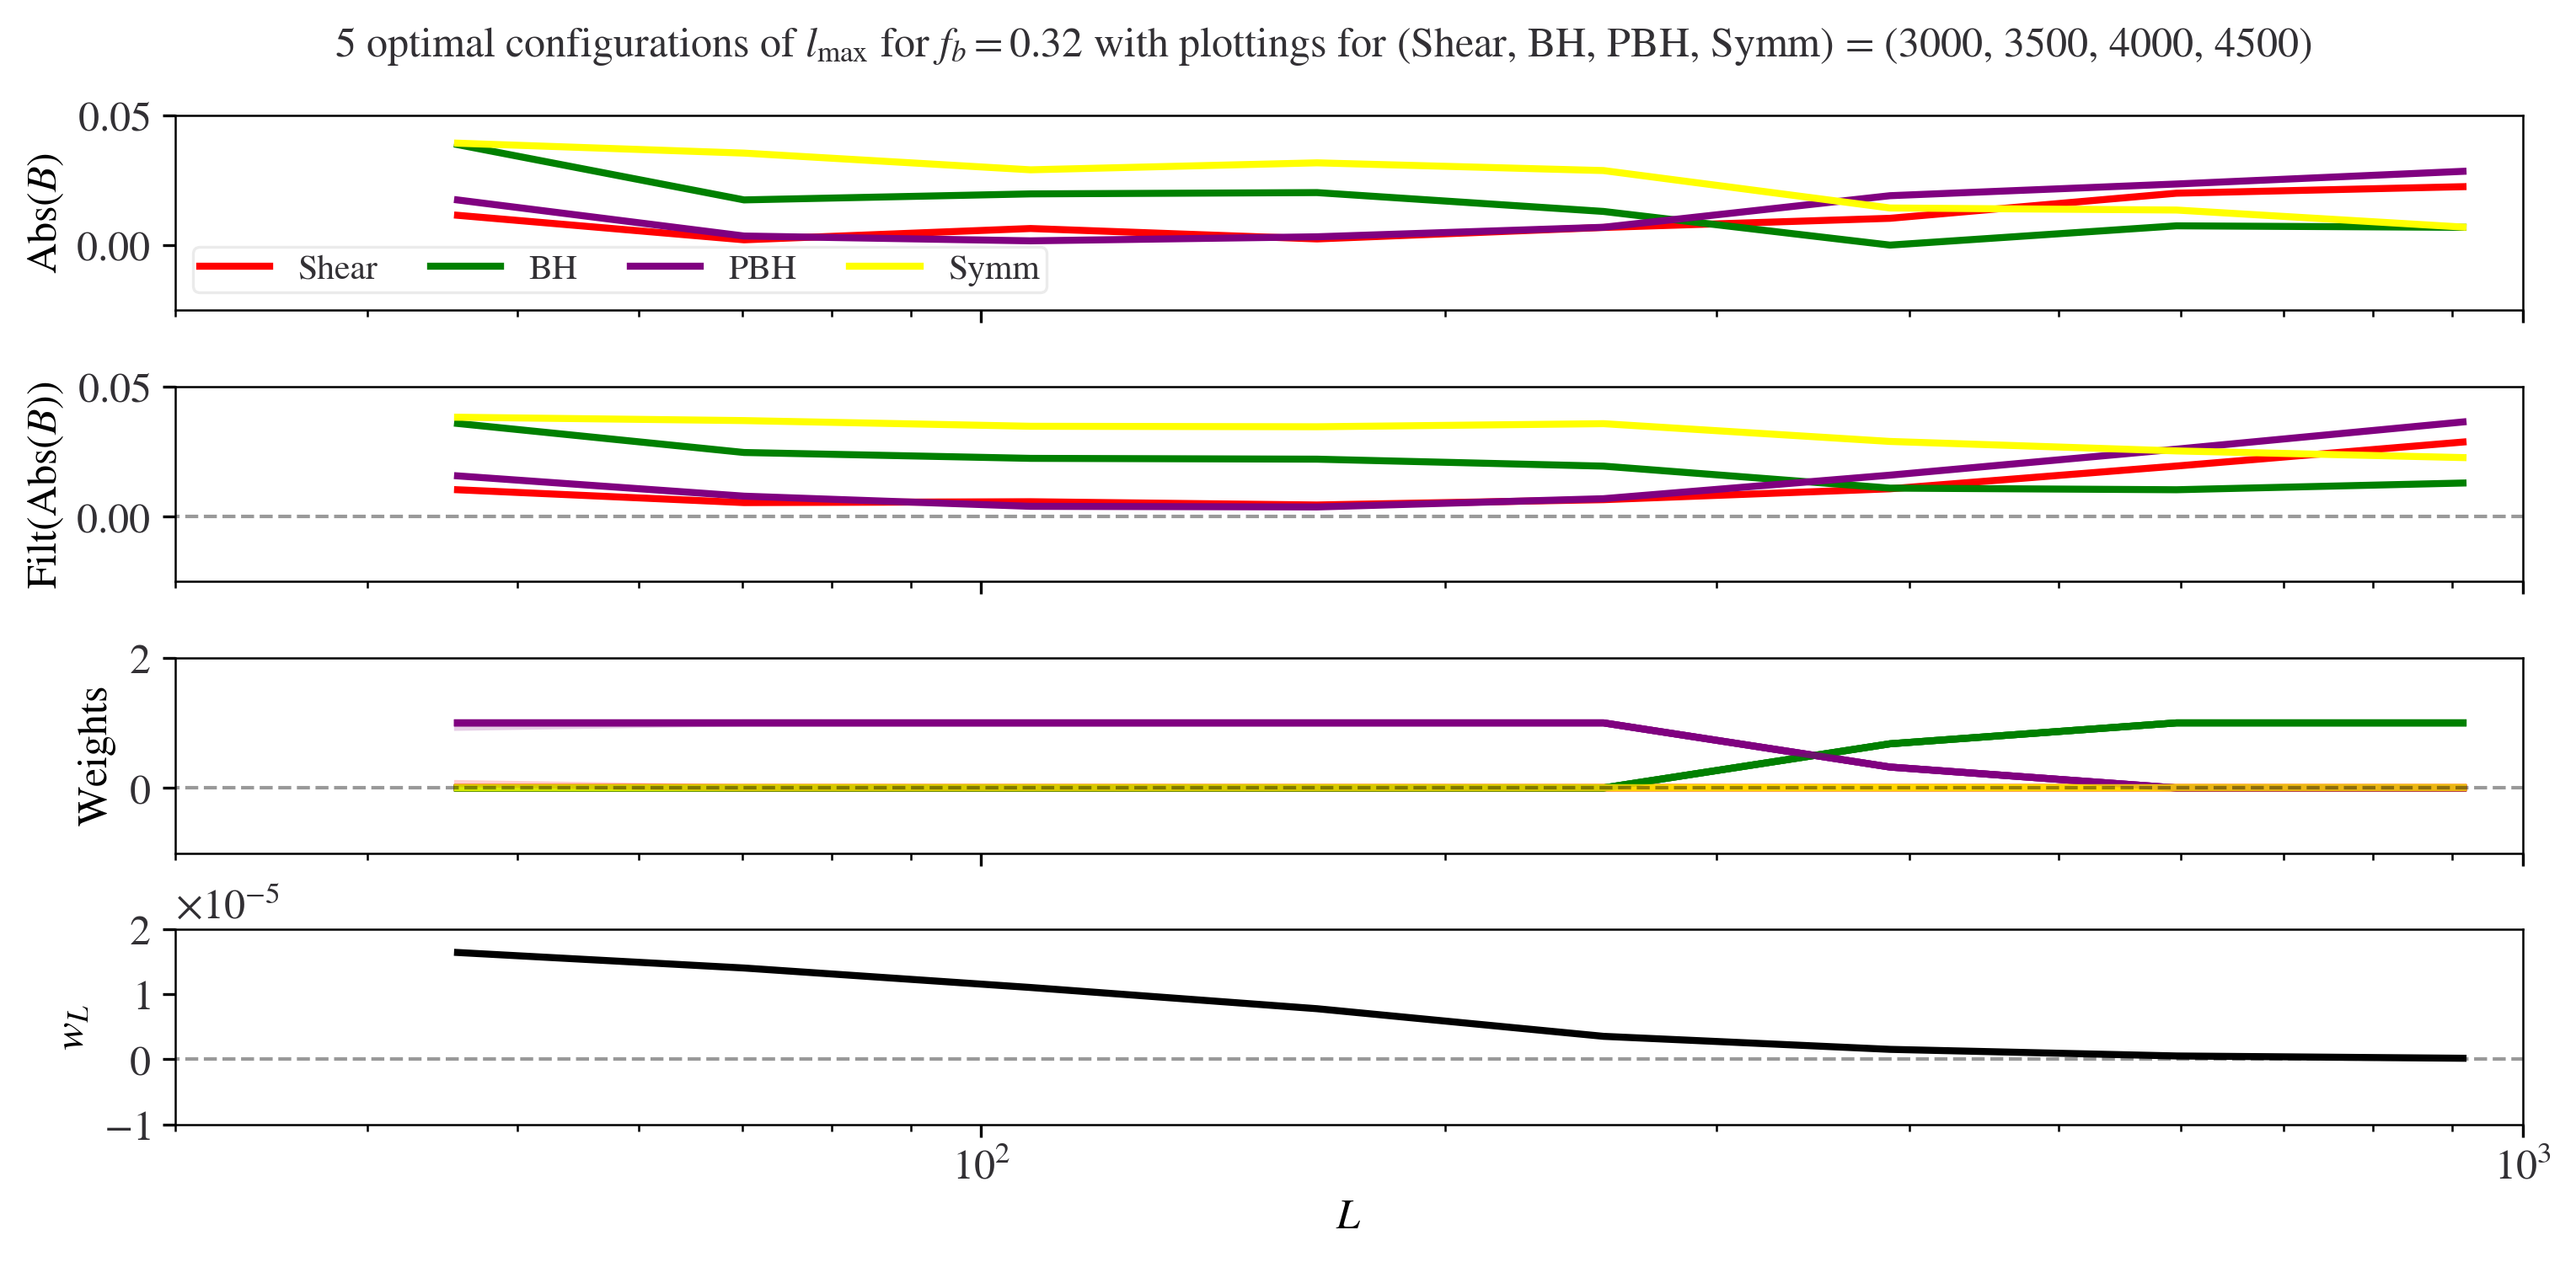

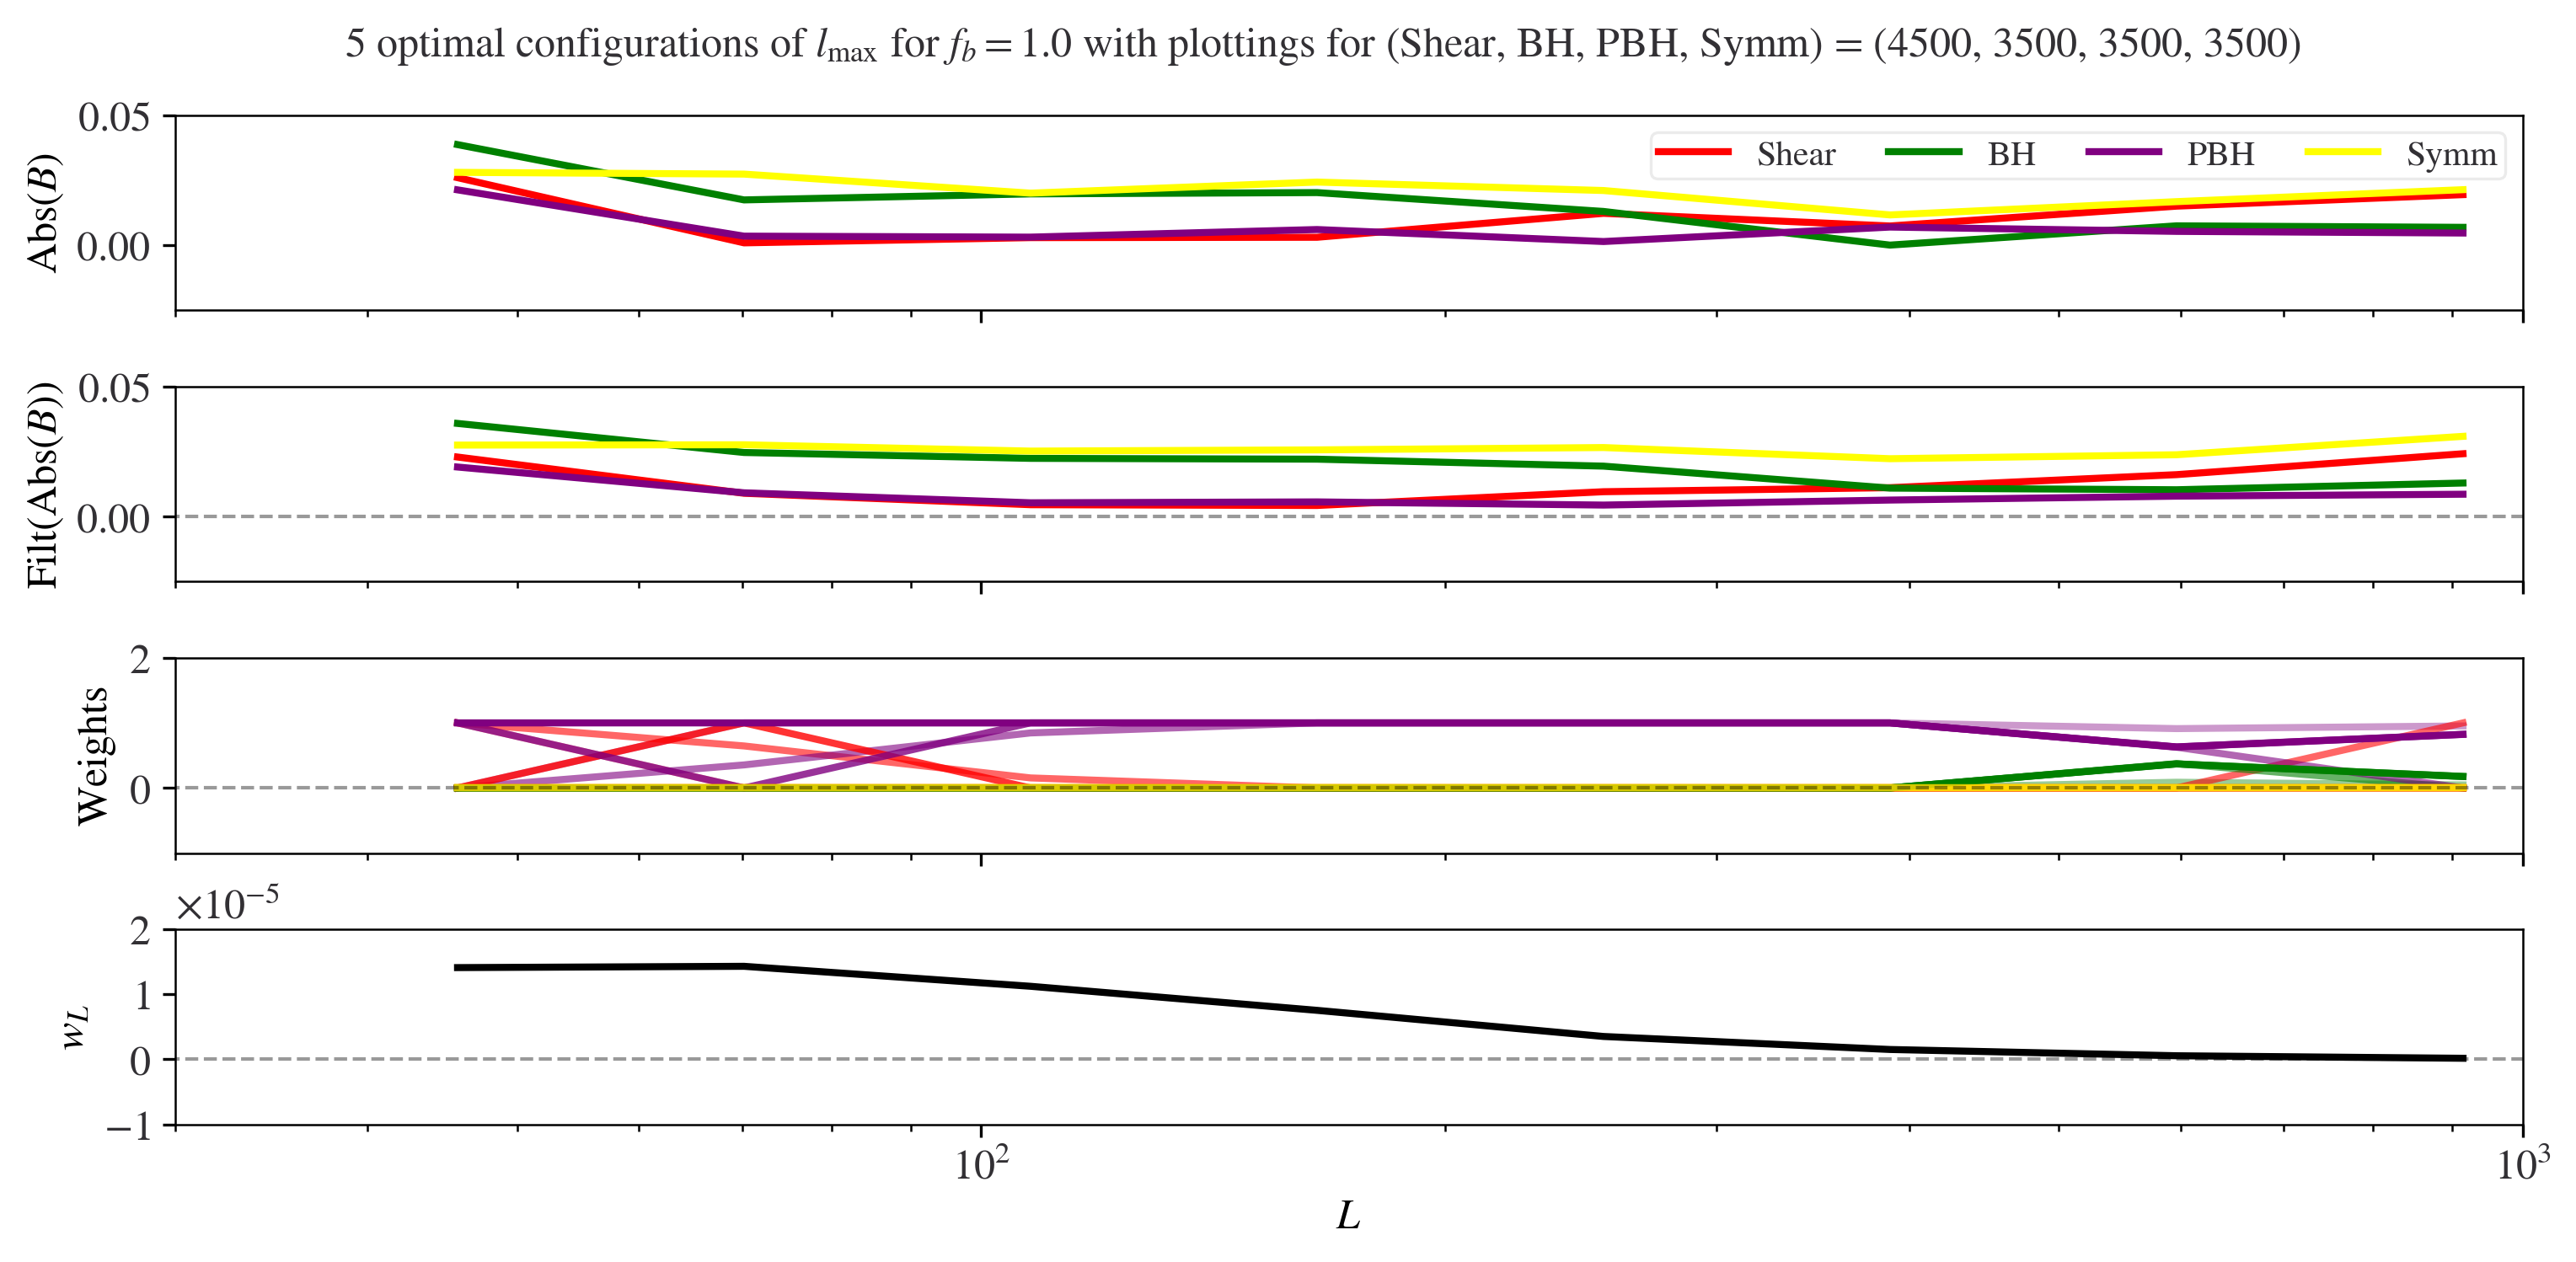

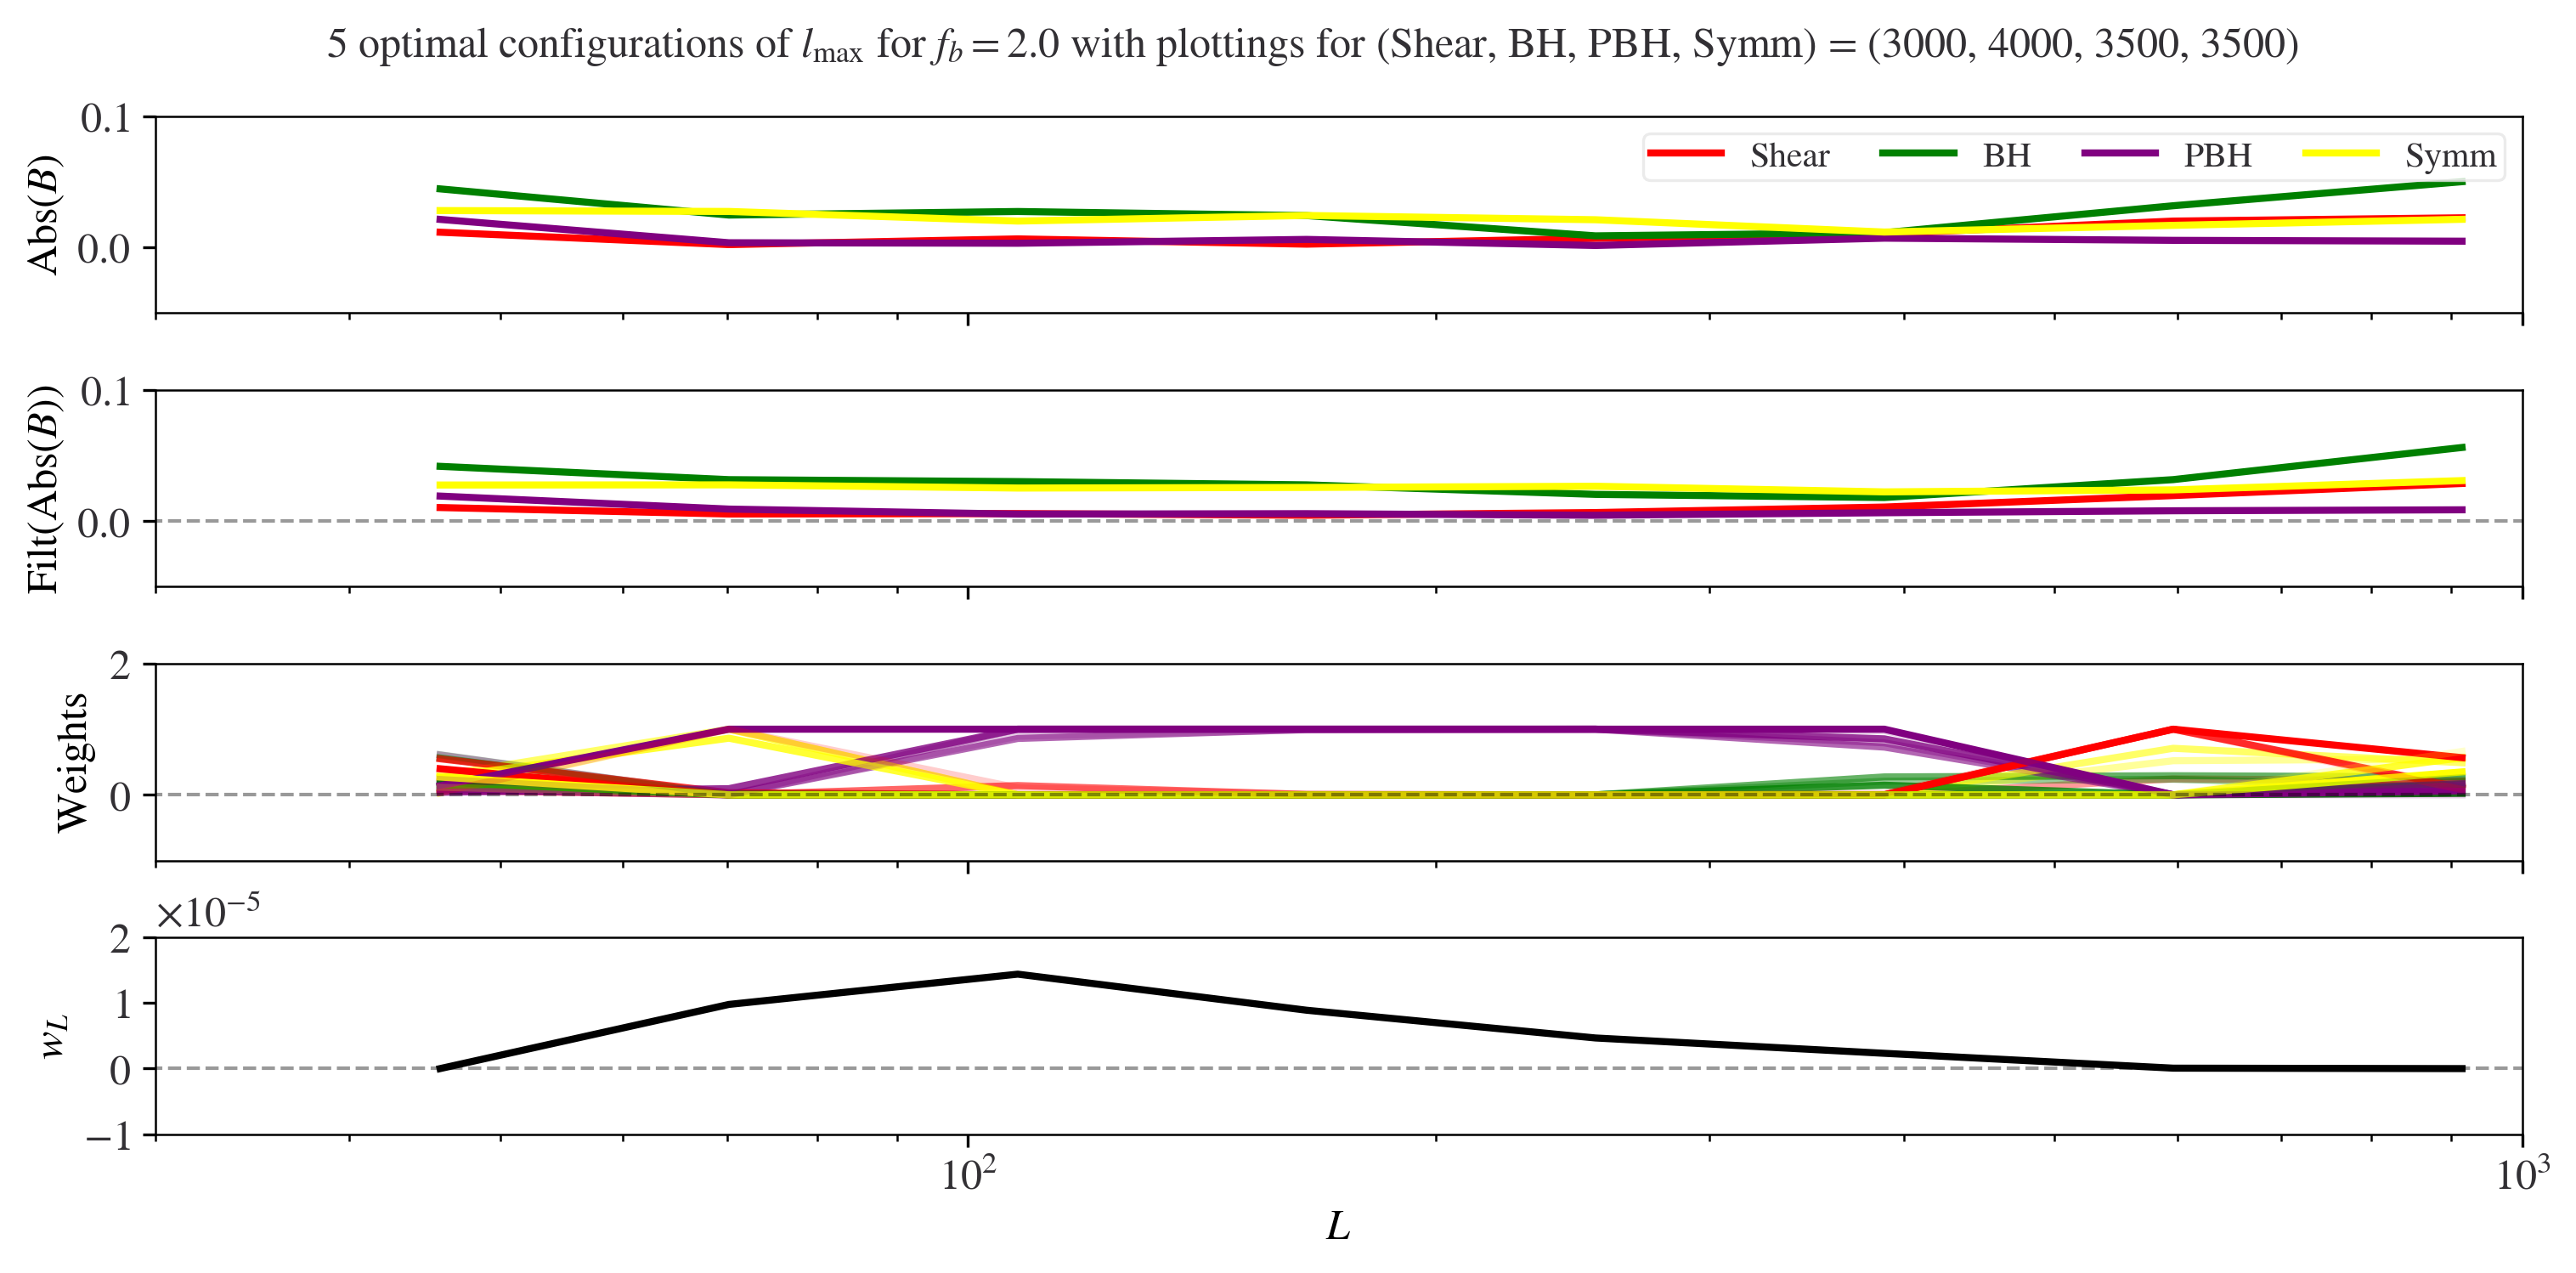

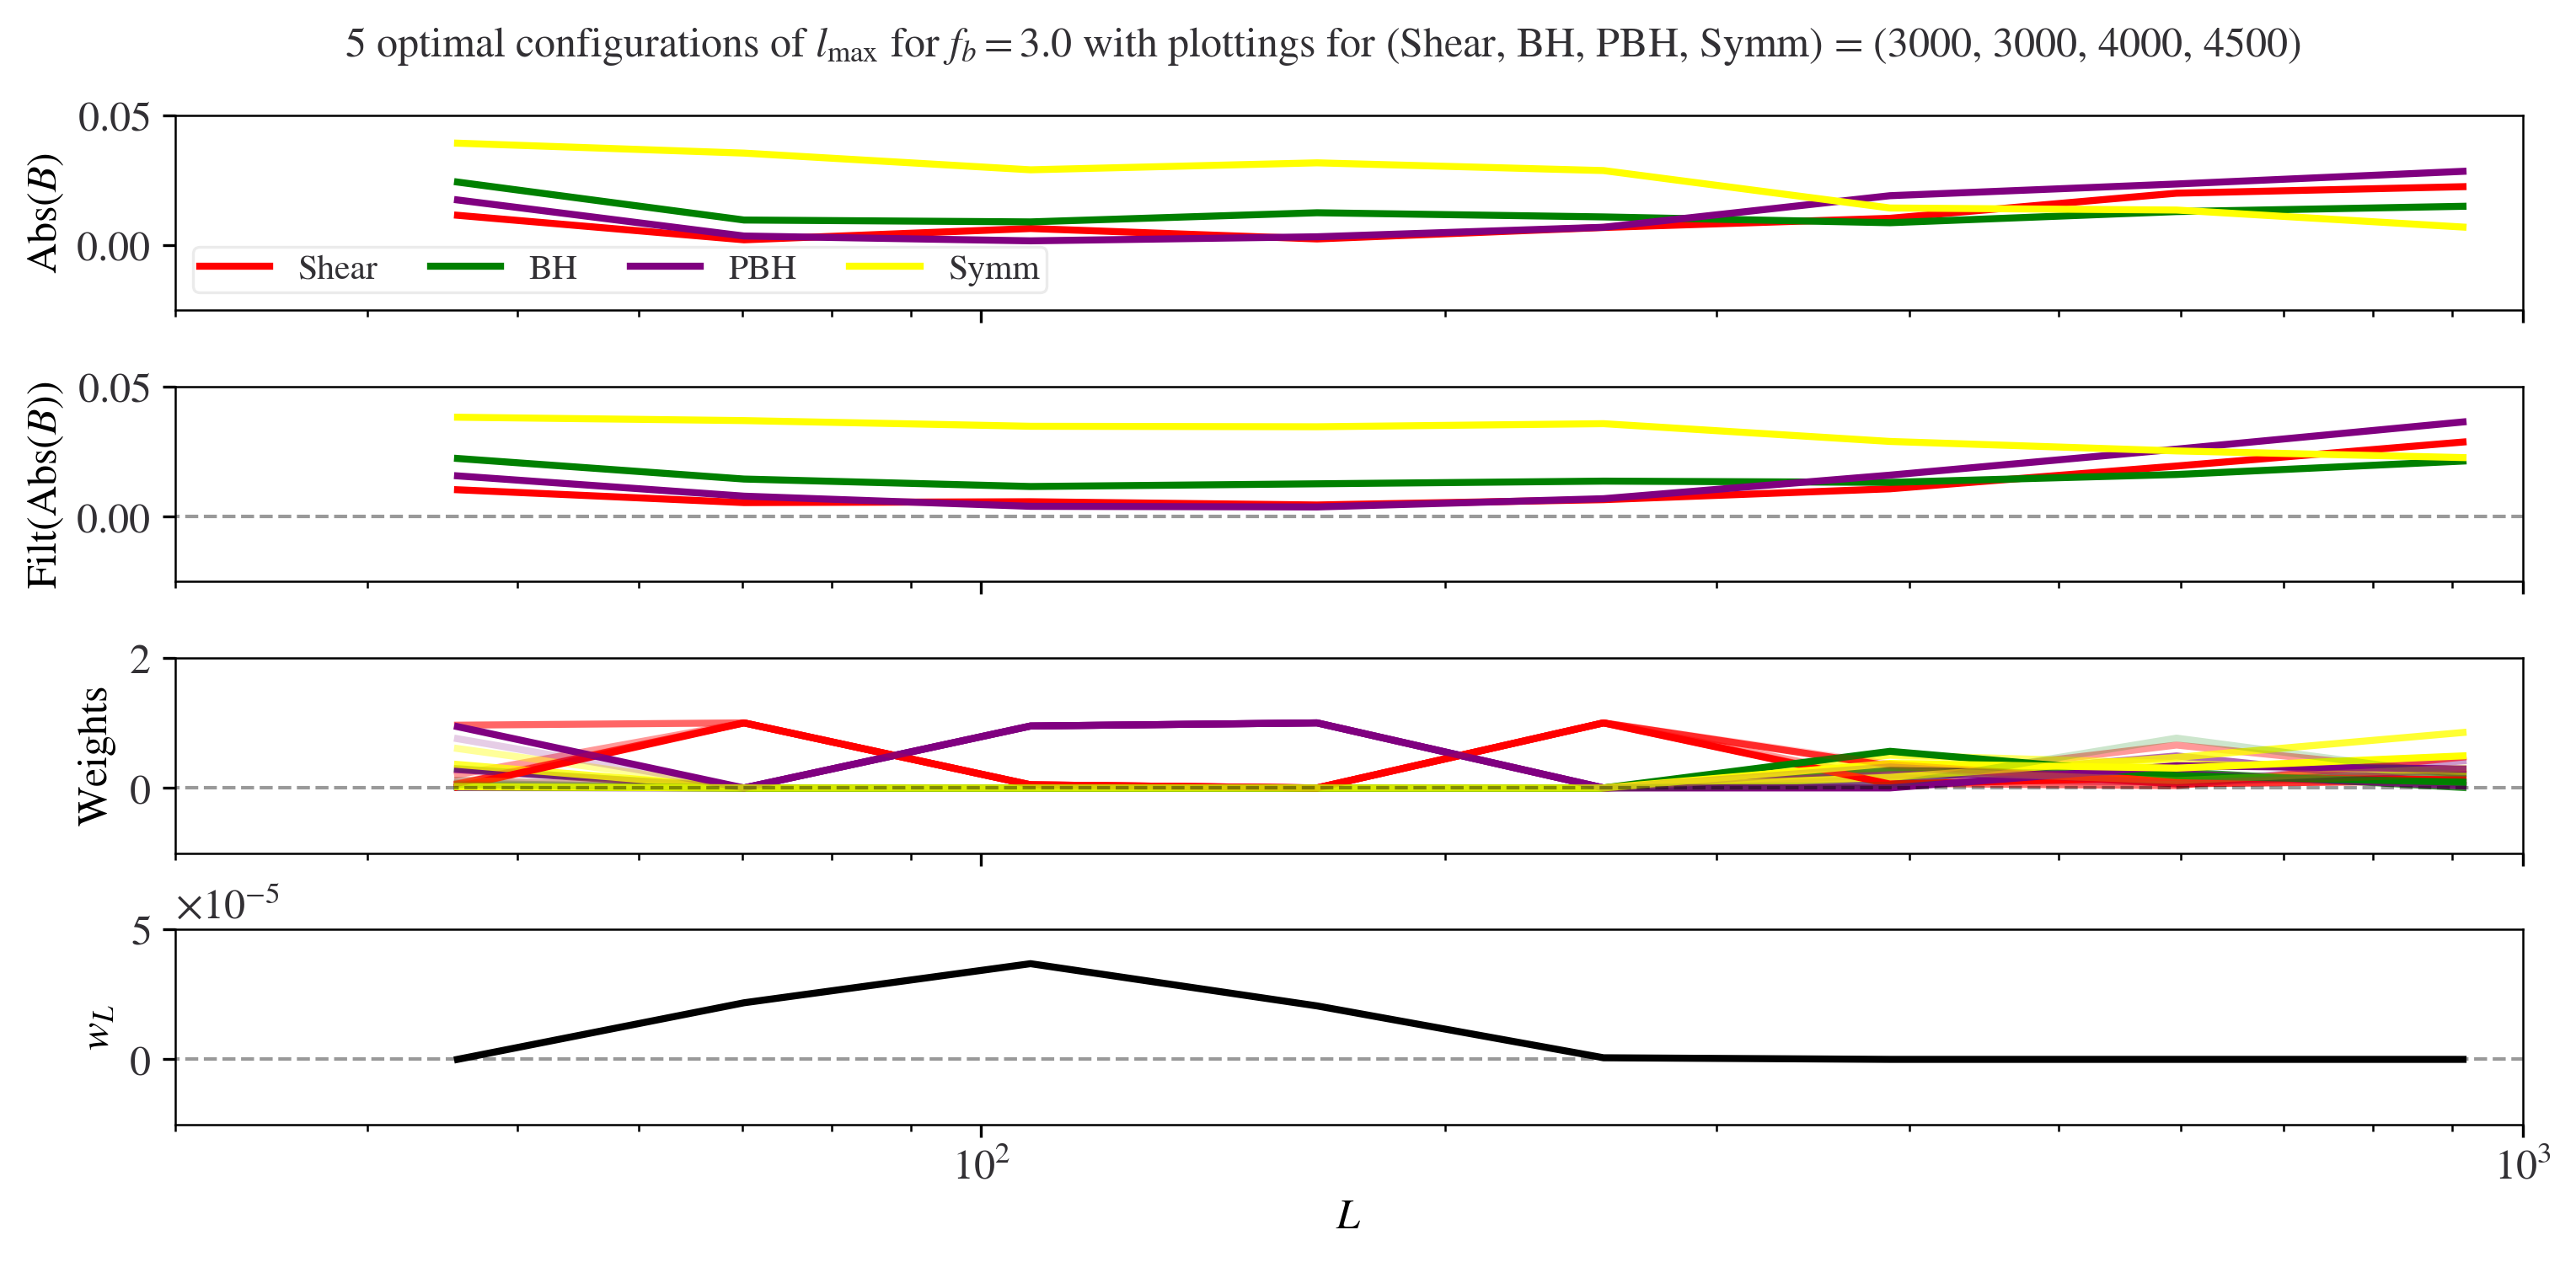

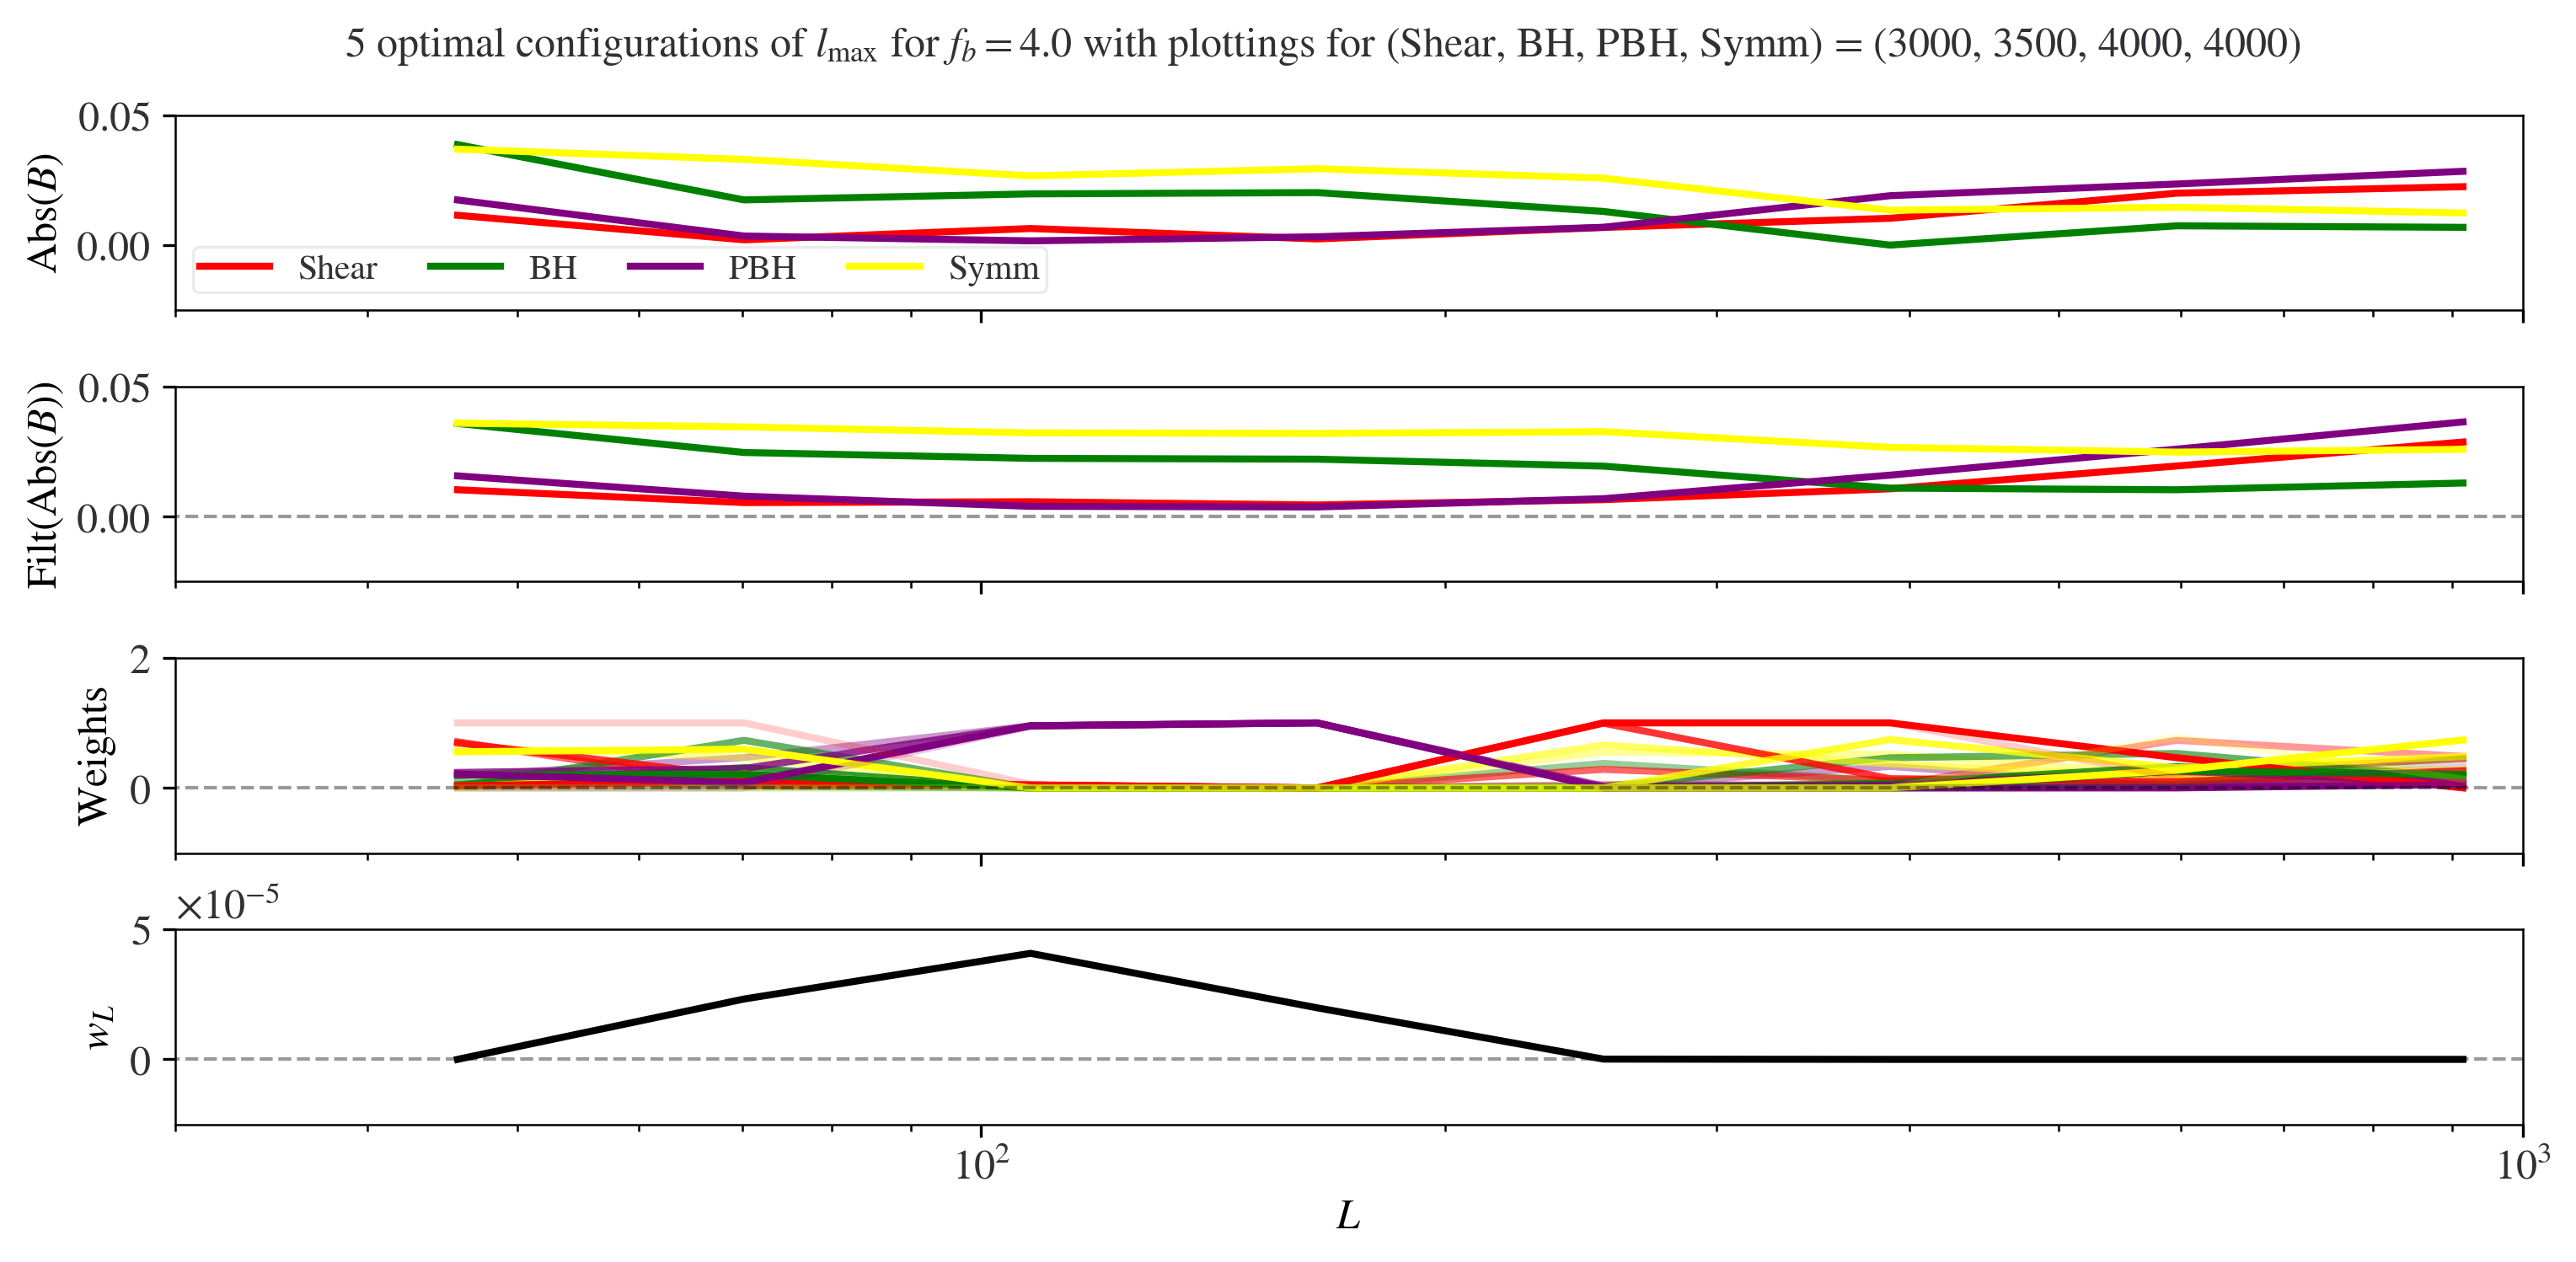

In [476]:
Ndir = len(relevant_directorties)

Nplots = 2
extranumber = 2
extraplots = 3


ns = np.array([])
bs = np.array([])
fs = np.array([])

for i, couple in enumerate(zip(relevant_directorties, fbs)):
    
    lmax_directory, fb = couple
    fbname = np.round(np.sqrt(fb), 2)
    
    lista_numeri = re.findall(r'\d+', lmax_directory)
    superlabel = '('
    superlabelnum = ' = ('
    for i_e, e in enumerate(estimators):
        extra = ', ' if i_e<len(estimators[:-1]) else ''
        superlabel += f'{labeling[e]}{extra}' 
        superlabelnum += f'${lista_numeri[i_e]}${extra}'
        
    superlabel += ')'
    superlabelnum += ')'
        
    superlabel += superlabelnum
    
    lmax_directory = pathlib.Path(lmax_directory)
    
    fig, axs = plt.subplots(nrows = Nplots+extranumber, figsize = (10, 5), sharex = True)

    fig.tight_layout(rect = [0, 0.03, 1, 0.95])
    fig.suptitle('5 optimal configurations of $l_{\mathrm{max}}$'+f' for $f_b={fbname}$ with plottings for {superlabel}')
    #fig.subplots_adjust(hspace = 0.8)

    
    kk, theta, ells, biases, noises, w, x = get_info(pathlib.Path(lmax_directory), resultspath, fb = fb, invvardir = inv_variance_dir)
    Optimizerkk = best.Opt(estimators, lmin_sel, lmax_sel, ells, kk, theta, abs(biases), noises)
    Ne = Optimizerkk.Ne
    
    for k in range(Optimizerkk.Ne):
        ff = lambda x: abs(x)
        #for j in range(k, Optimizerkk.Ne):
        if fb>0:
            axs[0].plot(Optimizerkk.ells_selected, ff(Optimizerkk.biases_selected[k, k]/Optimizerkk.theory_selected), label = labeling[names_W[k]], color = colors[k])
        elif fb == 0:
            axs[0].plot(Optimizerkk.ells_selected, np.sqrt((Optimizerkk.theta_selected[k, k, k, k]/Optimizerkk.theory_selected**2)**-1), label = labeling[names_W[k]], color = colors[k])
            
        axs[1].plot(Optimizerkk.ells_selected, Optimizerkk.filter_(abs(Optimizerkk.biases_selected), sigma = 1.5)[k, k]/Optimizerkk.theory_selected, color = colors[k])
    
    axs[1].plot(Optimizerkk.ells, Optimizerkk.ells*0., color = 'black', ls = '--', alpha = 0.4, lw = 1)
    axs[0].set_xscale('log')
    axs[1].set_xscale('log')
    
    
    
    top5list = all_relevant_directorties_dict[fb]
    top5list.reverse()
    
    alpha = 0.2
    
    for lmax_directory_specific in top5list:
    
        results_array = np.load(resultspath/lmax_directory_specific/inv_variance_dir/f'alens_{fb}{crosstag}{optimtag}.npy')[:, 0]
        ftemp, ntemp, btemp = results_array
    
        bs = np.append(bs, btemp)
        ns = np.append(ns, ntemp)
        fs = np.append(fs, ftemp)
        
        alpha += 0.2

        for k in range(Optimizerkk.Ne):
            resultkk = best.Res()
            #d = make_table(resultspath, all_lmaxes_directories, ['BH', 'SYBH', 'PH', 'SY'], fb = fb, include_estimators = False)
            #direc = d.sort_values(by = 'Total Auto').head(1).iloc[0, 0]
            resultkk.load_all(resultspath/lmax_directory_specific/inv_variance_dir, f'auto_fb_{fb}{crosstag}')
            weights = resultkk.ws[:, k]
            weights[weights<1e-5] = 0.
            #print(d.sort_values(by = 'Total Auto').head(1))
            fbname = np.round(np.sqrt(fb), 2)
            label = f'{fbname} {lmax_directory}' if k == 0 else None
            axs[0+extranumber].plot(Optimizerkk.ells_selected, weights, color = colors[k], alpha = alpha)
        
    axs[0+extranumber].set_ylabel('$\mathrm{Weights}$')
    #axs[0+extranumber].legend(ncol = 2, loc = 'best')
    #axs[0+extranumber].set_xlim(-0.01, 1.1)
    #axs[0+extranumber].set_xscale('log')
    
    wl = resultkk.ws[:, -1]
    axs[1+extranumber].plot(Optimizerkk.ells_selected, wl, color = 'black')
    #axs[1+extranumber].legend(ncol = 1, loc = 'best')
    axs[1+extranumber].set_ylabel('$w_L$')
    
    axs[1+extranumber].set_xlabel('$L$')    
    axs[1+extranumber].set_xscale('log')
    
    axs[0+extranumber].plot(Optimizerkk.ells, Optimizerkk.ells*0., color = 'black', ls = '--', alpha = 0.4, lw = 1)
    axs[1+extranumber].plot(Optimizerkk.ells, Optimizerkk.ells*0., color = 'black', ls = '--', alpha = 0.4, lw = 1)

    if fb > 0:
        axs[0].set_ylabel('$\mathrm{Abs}(B)$')
    elif fb == 0.:
        axs[0].set_ylabel('$\Theta$')
        
    axs[0].legend(ncol = Ne)
    axs[1].set_ylabel('$\mathrm{Filt}(\mathrm{Abs}(B))$')
    np.round(np.sqrt(fb), 2)
    
    axs[-1].set_xlim(30, 1000)
    fig.savefig(output_plots/f'top5_optimalcombs_{fbname}.png', bbox_inches = 'tight')
    plt.show()